In [607]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/project/dandofi_cgan_excess.csv
/kaggle/input/project/dandofi_gan_excess.csv
/kaggle/input/project/dandofi_wcgan_excess.csv
/kaggle/input/project/dandofi_gan_primary.csv
/kaggle/input/project/specie_cgan_excess.csv
/kaggle/input/project/specie_wcgan_excess.csv
/kaggle/input/project/dandoww_cgan_excess.csv
/kaggle/input/project/dandofi_wgan_primary.csv
/kaggle/input/project/specie_gan_primary.csv
/kaggle/input/project/dandoww_gan_excess.csv
/kaggle/input/project/dandoww_gan_primary.csv
/kaggle/input/project/specie_cleaned_data.txt
/kaggle/input/project/dandoww_wgan_primary.csv
/kaggle/input/project/fi_dando_cleaned_data.txt
/kaggle/input/project/specie_gan_excess.csv
/kaggle/input/project/dandoww_wgan_excess.csv
/kaggle/input/project/dando_ww_cleaned_data.txt
/kaggle/input/project/dandoww_wcgan_primary.csv
/kaggle/input/project/specie_wcgan_primary.csv
/kaggle/input/project/specie_wgan_primary.csv
/kaggle/input/project/dandoww_cgan_primary.csv
/kaggle/input/project/specie_

In [608]:
# ! pip install sweetviz

# import sweetviz as sv
# import IPython

In [609]:
!pip install imbalanced-learn

In [610]:
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from collections import Counter
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay

In [611]:
import gc
import os
import sys

from keras import applications
from keras import backend as K
from keras import layers
from keras import models
from keras import optimizers
import tensorflow as tf

In [612]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.compat.v1.keras import backend as K
from tensorflow.python.keras.backend import set_session
from tensorflow.python.keras.models import load_model

# Loading the Data

In [613]:
df_dandofi = pd.read_csv('../input/project/fi_dando_cleaned_data.txt')
df_dandofi.head()

,LifetimePolicyReference,PolicyReference,PriorPolicyRef,EclipsePolicyID,PriorEclipsePolicyID,GroupClass,PlacingBasis,SubClassCode,SubClass,StatsMinorClassCode,...,CLR_ExCat,ClaimFrequency,ILR_Cat,ILR_ExCat,ModelToActualRto,ModelToTechnicalRto,PLR_ex_adj,PLR_band,PLR_band_ex_adj,YOA_recent
0,TN677H19B000,TN677H19B000,NaN,917054,-1,FI D&O,OM,90433,GLOBAL FINANCIAL SERVICES,DT,...,0.0,0.000000,0.0,0.0,0.095669,0.142857,0.070571,Lower quantile,Upper Quantile,Recent
1,TM771N14B000,TM771N16B000,TM771N15B000,741401,687417,FI D&O,OM,90500,COMMERCIAL BANK,DP,...,0.0,72.673130,0.0,0.0,0.370370,0.500000,0.253500,Lower quantile,Upper Quantile,Recent
2,TP098H20A000,TP098H20A000,NaN,931416,-1,FI D&O,Re,90500,COMMERCIAL BANK,DS,...,0.0,0.000000,0.0,0.0,0.199283,0.222228,0.148671,Lower Middle,Upper Quantile,Recent
3,TM748N14A000,TM748N15A000,TM748N14A000,682670,626794,FI D&O,OM,90500,COMMERCIAL BANK,DN,...,0.0,227.795828,0.0,0.0,0.888937,0.689651,0.637238,Upper Quantile,Upper Quantile,History
4,TN677H18A000,TN677H19A000,TN677H18A000,903475,868731,FI D&O,OM,90433,GLOBAL FINANCIAL SERVICES,DT,...,0.0,6.147849,0.0,0.0,0.095677,0.142857,0.070571,Lower quantile,Upper Quantile,Recent


# Dropping features

#### Specie

In [614]:
df_dandofi.drop(['LifetimePolicyReference', 'PolicyReference', 'PriorPolicyRef', 
               'EclipsePolicyID', 'PriorEclipsePolicyID', 'GroupClass',
               'StatsMinorClassDescription', 'InceptionDate', 'ExpiryDate', 
               'RenewalDate', 'SubClassCode'], axis=1, inplace=True)
df_dandofi.head()

,PlacingBasis,SubClass,StatsMinorClassCode,Territory,YOA,Limit_100Pct_USD,GNWP,GGTP,GGWP,Inc,...,CLR_ExCat,ClaimFrequency,ILR_Cat,ILR_ExCat,ModelToActualRto,ModelToTechnicalRto,PLR_ex_adj,PLR_band,PLR_band_ex_adj,YOA_recent
0,OM,GLOBAL FINANCIAL SERVICES,DT,AUSTRALIA,2019.0,1.032765e+07,316.644988,218.048927,325.603088,0.0,...,0.0,0.000000,0.0,0.0,0.095669,0.142857,0.070571,Lower quantile,Upper Quantile,Recent
1,OM,COMMERCIAL BANK,DP,SLOVENIA,2016.0,5.615853e+07,13760.244069,13590.364512,18346.992092,0.0,...,0.0,72.673130,0.0,0.0,0.370370,0.500000,0.253500,Lower quantile,Upper Quantile,Recent
2,Re,COMMERCIAL BANK,DS,ISRAEL,2020.0,1.000000e+07,16200.000000,16141.500000,18000.000000,0.0,...,0.0,0.000000,0.0,0.0,0.199283,0.222228,0.148671,Lower Middle,Upper Quantile,Recent
3,OM,COMMERCIAL BANK,DN,AUSTRALIA,2015.0,1.721275e+07,8779.792047,12574.280849,9755.325677,0.0,...,0.0,227.795828,0.0,0.0,0.888937,0.689651,0.637238,Upper Quantile,Upper Quantile,History
4,OM,GLOBAL FINANCIAL SERVICES,DT,AUSTRALIA,2019.0,1.032765e+07,325317.033299,217877.652954,325317.033299,0.0,...,0.0,6.147849,0.0,0.0,0.095677,0.142857,0.070571,Lower quantile,Upper Quantile,Recent


In [615]:
df_dandofi.drop('PLR_band_ex_adj', axis=1, inplace=True)
df_dandofi.head()

,PlacingBasis,SubClass,StatsMinorClassCode,Territory,YOA,Limit_100Pct_USD,GNWP,GGTP,GGWP,Inc,...,CLR_Cat,CLR_ExCat,ClaimFrequency,ILR_Cat,ILR_ExCat,ModelToActualRto,ModelToTechnicalRto,PLR_ex_adj,PLR_band,YOA_recent
0,OM,GLOBAL FINANCIAL SERVICES,DT,AUSTRALIA,2019.0,1.032765e+07,316.644988,218.048927,325.603088,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.095669,0.142857,0.070571,Lower quantile,Recent
1,OM,COMMERCIAL BANK,DP,SLOVENIA,2016.0,5.615853e+07,13760.244069,13590.364512,18346.992092,0.0,...,0.0,0.0,72.673130,0.0,0.0,0.370370,0.500000,0.253500,Lower quantile,Recent
2,Re,COMMERCIAL BANK,DS,ISRAEL,2020.0,1.000000e+07,16200.000000,16141.500000,18000.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.199283,0.222228,0.148671,Lower Middle,Recent
3,OM,COMMERCIAL BANK,DN,AUSTRALIA,2015.0,1.721275e+07,8779.792047,12574.280849,9755.325677,0.0,...,0.0,0.0,227.795828,0.0,0.0,0.888937,0.689651,0.637238,Upper Quantile,History
4,OM,GLOBAL FINANCIAL SERVICES,DT,AUSTRALIA,2019.0,1.032765e+07,325317.033299,217877.652954,325317.033299,0.0,...,0.0,0.0,6.147849,0.0,0.0,0.095677,0.142857,0.070571,Lower quantile,Recent


In [616]:
df_dandofi.drop(['Exposure', 'LinePct'], axis=1, inplace=True)
df_dandofi.head()

,PlacingBasis,SubClass,StatsMinorClassCode,Territory,YOA,Limit_100Pct_USD,GNWP,GGTP,GGWP,Inc,...,CLR_Cat,CLR_ExCat,ClaimFrequency,ILR_Cat,ILR_ExCat,ModelToActualRto,ModelToTechnicalRto,PLR_ex_adj,PLR_band,YOA_recent
0,OM,GLOBAL FINANCIAL SERVICES,DT,AUSTRALIA,2019.0,1.032765e+07,316.644988,218.048927,325.603088,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.095669,0.142857,0.070571,Lower quantile,Recent
1,OM,COMMERCIAL BANK,DP,SLOVENIA,2016.0,5.615853e+07,13760.244069,13590.364512,18346.992092,0.0,...,0.0,0.0,72.673130,0.0,0.0,0.370370,0.500000,0.253500,Lower quantile,Recent
2,Re,COMMERCIAL BANK,DS,ISRAEL,2020.0,1.000000e+07,16200.000000,16141.500000,18000.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.199283,0.222228,0.148671,Lower Middle,Recent
3,OM,COMMERCIAL BANK,DN,AUSTRALIA,2015.0,1.721275e+07,8779.792047,12574.280849,9755.325677,0.0,...,0.0,0.0,227.795828,0.0,0.0,0.888937,0.689651,0.637238,Upper Quantile,History
4,OM,GLOBAL FINANCIAL SERVICES,DT,AUSTRALIA,2019.0,1.032765e+07,325317.033299,217877.652954,325317.033299,0.0,...,0.0,0.0,6.147849,0.0,0.0,0.095677,0.142857,0.070571,Lower quantile,Recent


In [617]:
# Since claims won’t be mature enough
df_dandofi.drop(df_dandofi[df_dandofi.YOA == 2020.0].index, inplace=True)
df_dandofi.drop(df_dandofi[df_dandofi.YOA == 2021.0].index, inplace=True)
df_dandofi.reset_index(drop=True, inplace=True)

In [618]:
df_dandofi.drop(df_dandofi[df_dandofi.PlacingBasis == 'Binder'].index, axis=0, inplace=True)
df_dandofi.drop(df_dandofi[df_dandofi.PlacingBasis == 'Other'].index, axis=0, inplace=True)
df_dandofi.reset_index(drop=True, inplace=True)

In [619]:
df_dandofi.replace(' ', '_', regex=True, inplace=True)
df_dandofi.head()

,PlacingBasis,SubClass,StatsMinorClassCode,Territory,YOA,Limit_100Pct_USD,GNWP,GGTP,GGWP,Inc,...,CLR_Cat,CLR_ExCat,ClaimFrequency,ILR_Cat,ILR_ExCat,ModelToActualRto,ModelToTechnicalRto,PLR_ex_adj,PLR_band,YOA_recent
0,OM,GLOBAL_FINANCIAL_SERVICES,DT,AUSTRALIA,2019.0,1.032765e+07,316.644988,218.048927,325.603088,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.095669,0.142857,0.070571,Lower_quantile,Recent
1,OM,COMMERCIAL_BANK,DP,SLOVENIA,2016.0,5.615853e+07,13760.244069,13590.364512,18346.992092,0.0,...,0.0,0.0,72.673130,0.0,0.0,0.370370,0.500000,0.253500,Lower_quantile,Recent
2,OM,COMMERCIAL_BANK,DN,AUSTRALIA,2015.0,1.721275e+07,8779.792047,12574.280849,9755.325677,0.0,...,0.0,0.0,227.795828,0.0,0.0,0.888937,0.689651,0.637238,Upper_Quantile,History
3,OM,GLOBAL_FINANCIAL_SERVICES,DT,AUSTRALIA,2019.0,1.032765e+07,325317.033299,217877.652954,325317.033299,0.0,...,0.0,0.0,6.147849,0.0,0.0,0.095677,0.142857,0.070571,Lower_quantile,Recent
4,Re,COMMERCIAL_BANK,DP,WORLDWIDE_(EXCLUDING_USA_&_CANADA),2013.0,5.000000e+05,3625.000000,4601.000000,5000.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.707800,0.769181,0.550349,Lower_Middle,History


# Classification

In [620]:
df_dandofi.drop(['Inc', 'Inc_Cat', 'ClaimFrequency', 'CLR_Cat', 
                'CLR_ExCat', 'Full_Inc_ExCat', 'Inc_ExCat', 
               'Inc_Cat', 'ILR_Cat', 'ILR_ExCat', 'GNWP'], axis=1, inplace=True)
df_dandofi.head()

,PlacingBasis,SubClass,StatsMinorClassCode,Territory,YOA,Limit_100Pct_USD,GGTP,GGWP,LeaderStatus,LeaderLinePct,...,PricingStrength2,BrokerFeePct,YOA_cat,Excess,Attachment,ModelToActualRto,ModelToTechnicalRto,PLR_ex_adj,PLR_band,YOA_recent
0,OM,GLOBAL_FINANCIAL_SERVICES,DT,AUSTRALIA,2019.0,1.032765e+07,218.048927,325.603088,LEAD,100.0,...,0.493257,2.751233,2019,Excess,1.445871e+08,0.095669,0.142857,0.070571,Lower_quantile,Recent
1,OM,COMMERCIAL_BANK,DP,SLOVENIA,2016.0,5.615853e+07,13590.364512,18346.992092,FOLLOW,20.0,...,0.350000,25.000000,2016,Excess,8.423780e+07,0.370370,0.500000,0.253500,Lower_quantile,Recent
2,OM,COMMERCIAL_BANK,DN,AUSTRALIA,2015.0,1.721275e+07,12574.280849,9755.325677,FOLLOW,30.0,...,-0.224184,10.000011,2015,Excess,2.926167e+08,0.888937,0.689651,0.637238,Upper_Quantile,History
3,OM,GLOBAL_FINANCIAL_SERVICES,DT,AUSTRALIA,2019.0,1.032765e+07,217877.652954,325317.033299,LEAD,100.0,...,0.493118,0.000000,2019,Excess,1.445871e+08,0.095677,0.142857,0.070571,Lower_quantile,Recent
4,Re,COMMERCIAL_BANK,DP,WORLDWIDE_(EXCLUDING_USA_&_CANADA),2013.0,5.000000e+05,4601.000000,5000.000000,LEAD,100.0,...,0.086720,27.500000,2013,Primary,2.000000e+04,0.707800,0.769181,0.550349,Lower_Middle,History


In [621]:
# Making 100% share basis
df_dandofi.GGTP = df_dandofi.GGTP / df_dandofi.EffectiveLine
df_dandofi.GGWP = df_dandofi.GGWP / df_dandofi.EffectiveLine
df_dandofi.GrossGrossModelPrice = df_dandofi.GrossGrossModelPrice / df_dandofi.EffectiveLine
df_dandofi.GrossNetModelPrice = df_dandofi.GrossNetModelPrice / df_dandofi.EffectiveLine
df_dandofi.GrossGrossTechnicalPrice = df_dandofi.GrossGrossTechnicalPrice / df_dandofi.EffectiveLine
df_dandofi.GrossNetTechnicalPrice = df_dandofi.GrossNetTechnicalPrice / df_dandofi.EffectiveLine

In [622]:
# Rename the columns
df_dandofi = df_dandofi.rename(columns={'GGTP': 'Full_GGTP'})
df_dandofi = df_dandofi.rename(columns={'GGWP': 'Full_GGWP'})
df_dandofi = df_dandofi.rename(columns={'GrossGrossModelPrice': 'Full_GrossGrossModelPrice'})
df_dandofi = df_dandofi.rename(columns={'GrossNetModelPrice': 'Full_GrossNetModelPrice'})
df_dandofi = df_dandofi.rename(columns={'GrossGrossTechnicalPrice': 'Full_GrossGrossTechnicalPrice'})
df_dandofi = df_dandofi.rename(columns={'GrossNetTechnicalPrice': 'Full_GrossNetTechnicalPrice'})

In [623]:
df_dandofi.drop('EffectiveLine', axis=1, inplace=True)

In [624]:
X = df_dandofi.copy()
X.head()

,PlacingBasis,SubClass,StatsMinorClassCode,Territory,YOA,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderStatus,LeaderLinePct,...,PricingStrength2,BrokerFeePct,YOA_cat,Excess,Attachment,ModelToActualRto,ModelToTechnicalRto,PLR_ex_adj,PLR_band,YOA_recent
0,OM,GLOBAL_FINANCIAL_SERVICES,DT,AUSTRALIA,2019.0,1.032765e+07,218.048927,325.603088,LEAD,100.0,...,0.493257,2.751233,2019,Excess,1.445871e+08,0.095669,0.142857,0.070571,Lower_quantile,Recent
1,OM,COMMERCIAL_BANK,DP,SLOVENIA,2016.0,5.615853e+07,123548.768294,166790.837197,FOLLOW,20.0,...,0.350000,25.000000,2016,Excess,8.423780e+07,0.370370,0.500000,0.253500,Lower_quantile,Recent
2,OM,COMMERCIAL_BANK,DN,AUSTRALIA,2015.0,1.721275e+07,53897.474706,41814.512118,FOLLOW,30.0,...,-0.224184,10.000011,2015,Excess,2.926167e+08,0.888937,0.689651,0.637238,Upper_Quantile,History
3,OM,GLOBAL_FINANCIAL_SERVICES,DT,AUSTRALIA,2019.0,1.032765e+07,217877.652954,325317.033299,LEAD,100.0,...,0.493118,0.000000,2019,Excess,1.445871e+08,0.095677,0.142857,0.070571,Lower_quantile,Recent
4,Re,COMMERCIAL_BANK,DP,WORLDWIDE_(EXCLUDING_USA_&_CANADA),2013.0,5.000000e+05,4601.000000,5000.000000,LEAD,100.0,...,0.086720,27.500000,2013,Primary,2.000000e+04,0.707800,0.769181,0.550349,Lower_Middle,History


In [625]:
df_dandofi.drop(['YOA', 'YOA_cat', 'YOA_recent'], axis=1, inplace=True)
X = X.drop(['YOA', 'YOA_cat', 'YOA_recent'], axis=1).copy()

In [626]:
X['Class'] = X['ClaimCount'] / X['ClaimCount']
X['Class'] = X['Class'].fillna(0)
X.head()

,PlacingBasis,SubClass,StatsMinorClassCode,Territory,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderStatus,LeaderLinePct,BrokerUltimateName,...,PricingStrength,PricingStrength2,BrokerFeePct,Excess,Attachment,ModelToActualRto,ModelToTechnicalRto,PLR_ex_adj,PLR_band,Class
0,OM,GLOBAL_FINANCIAL_SERVICES,DT,AUSTRALIA,1.032765e+07,218.048927,325.603088,LEAD,100.0,MARSH,...,1.493257,0.493257,2.751233,Excess,1.445871e+08,0.095669,0.142857,0.070571,Lower_quantile,0.0
1,OM,COMMERCIAL_BANK,DP,SLOVENIA,5.615853e+07,123548.768294,166790.837197,FOLLOW,20.0,R_K_HARRISON,...,1.350000,0.350000,25.000000,Excess,8.423780e+07,0.370370,0.500000,0.253500,Lower_quantile,1.0
2,OM,COMMERCIAL_BANK,DN,AUSTRALIA,1.721275e+07,53897.474706,41814.512118,FOLLOW,30.0,MARSH,...,0.775816,-0.224184,10.000011,Excess,2.926167e+08,0.888937,0.689651,0.637238,Upper_Quantile,1.0
3,OM,GLOBAL_FINANCIAL_SERVICES,DT,AUSTRALIA,1.032765e+07,217877.652954,325317.033299,LEAD,100.0,MARSH,...,1.493118,0.493118,0.000000,Excess,1.445871e+08,0.095677,0.142857,0.070571,Lower_quantile,1.0
4,Re,COMMERCIAL_BANK,DP,WORLDWIDE_(EXCLUDING_USA_&_CANADA),5.000000e+05,4601.000000,5000.000000,LEAD,100.0,ARTHUR_J._GALLAGHER_&_CO.,...,1.086720,0.086720,27.500000,Primary,2.000000e+04,0.707800,0.769181,0.550349,Lower_Middle,0.0


In [627]:
df_dandofi.drop('ClaimCount', axis=1, inplace=True)
X.drop('ClaimCount', axis=1, inplace=True)

In [628]:
# Divide into primary and excess business
X_p = X.copy()
X_p.drop(X_p[X_p.Excess == 'Excess'].index, axis=0, inplace=True)
X_p.drop(['Excess', 'XS_100Pct_USD'], axis=1, inplace=True)
X_p.reset_index(drop=True, inplace=True)
X_p.head()

,PlacingBasis,SubClass,StatsMinorClassCode,Territory,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderStatus,LeaderLinePct,BrokerUltimateName,...,Full_GNWP,PricingStrength,PricingStrength2,BrokerFeePct,Attachment,ModelToActualRto,ModelToTechnicalRto,PLR_ex_adj,PLR_band,Class
0,Re,COMMERCIAL_BANK,DP,WORLDWIDE_(EXCLUDING_USA_&_CANADA),5.000000e+05,4601.000000,5000.000000,LEAD,100.00,ARTHUR_J._GALLAGHER_&_CO.,...,3625.000000,1.086720,0.086720,27.500000,20000.000000,0.707800,0.769181,0.550349,Lower_Middle,0.0
1,OM,COMMERCIAL_BANK,DP,CONGO_(DEM._REP.),5.000000e+06,9000.000000,14850.000000,LEAD,50.00,OXFORD_INSURANCE_BROKERS,...,11137.499815,1.650000,0.650000,25.000001,0.000000,0.303030,0.500000,0.207500,Lower_quantile,0.0
2,OM,FUND_MANAGERS,DP,WORLDWIDE,2.246341e+07,53652.737388,55961.976184,LEAD,66.67,AON_BENFIELD,...,44769.580947,1.043040,0.043040,20.000000,28079.265521,0.958736,1.000000,0.745500,Upper_Middle,0.0
3,OM,FUND_MANAGERS,DP,UNITED_KINGDOM,6.178000e+06,24094.200000,24712.000000,LEAD,62.50,MILLER_INSURANCE_SERVICES,...,19769.600000,1.025641,0.025641,20.000000,61780.000000,0.750000,0.769231,0.534231,Lower_Middle,0.0
4,OM,FUND_MANAGERS,DP,SWITZERLAND,1.055347e+07,15163.601985,12196.567443,LEAD,40.00,WILLIS,...,9452.336911,0.804332,-0.195668,22.500023,105534.677144,1.275099,1.025602,0.926222,Upper_Quantile,0.0


In [629]:
# Divide into primary and excess business
X_e = X.copy()
X_e.drop(X_e[X_e.Excess == 'Primary'].index, axis=0, inplace=True)
X_e.drop('Excess', axis=1, inplace=True)
X_e.reset_index(drop=True, inplace=True)
X_e.head()

,PlacingBasis,SubClass,StatsMinorClassCode,Territory,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderStatus,LeaderLinePct,BrokerUltimateName,...,Full_GNWP,PricingStrength,PricingStrength2,BrokerFeePct,Attachment,ModelToActualRto,ModelToTechnicalRto,PLR_ex_adj,PLR_band,Class
0,OM,GLOBAL_FINANCIAL_SERVICES,DT,AUSTRALIA,1.032765e+07,218.048927,325.603088,LEAD,100.0,MARSH,...,316.644988,1.493257,0.493257,2.751233,1.445871e+08,0.095669,0.142857,0.070571,Lower_quantile,0.0
1,OM,COMMERCIAL_BANK,DP,SLOVENIA,5.615853e+07,123548.768294,166790.837197,FOLLOW,20.0,R_K_HARRISON,...,125093.127898,1.350000,0.350000,25.000000,8.423780e+07,0.370370,0.500000,0.253500,Lower_quantile,1.0
2,OM,COMMERCIAL_BANK,DN,AUSTRALIA,1.721275e+07,53897.474706,41814.512118,FOLLOW,30.0,MARSH,...,37633.056351,0.775816,-0.224184,10.000011,2.926167e+08,0.888937,0.689651,0.637238,Upper_Quantile,1.0
3,OM,GLOBAL_FINANCIAL_SERVICES,DT,AUSTRALIA,1.032765e+07,217877.652954,325317.033299,LEAD,100.0,MARSH,...,325317.033299,1.493118,0.493118,0.000000,1.445871e+08,0.095677,0.142857,0.070571,Lower_quantile,1.0
4,Re,SPECIALTY_/_FINANCE_/_PROFESSIONAL_SERVI,DP,BAHRAIN,1.500000e+07,16931.000000,21164.000000,FOLLOW,32.5,LONSDALE_INSURANCE_BROKERS_LIMITED,...,15872.999601,1.250015,0.250015,25.000002,1.000000e+07,2.399973,3.000002,1.980002,Lower_Middle,0.0


In [630]:
# Data scaling
# Scale only columns that have values greater than 1
to_scale = [col for col in X.columns[X.dtypes != 'object'] if X[col].max() > 1]
mms = MinMaxScaler()
scaled = mms.fit_transform(X[to_scale])
scaled = pd.DataFrame(scaled, columns=to_scale)

X_scaled = X.copy()
# Replace original columns with scaled ones
for col in scaled:
    X_scaled[col] = scaled[col]
    
X_scaled.head()

,PlacingBasis,SubClass,StatsMinorClassCode,Territory,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderStatus,LeaderLinePct,BrokerUltimateName,...,PricingStrength,PricingStrength2,BrokerFeePct,Excess,Attachment,ModelToActualRto,ModelToTechnicalRto,PLR_ex_adj,PLR_band,Class
0,OM,GLOBAL_FINANCIAL_SERVICES,DT,AUSTRALIA,0.030963,0.000008,0.000015,LEAD,0.241535,MARSH,...,0.269429,0.112140,0.060748,Excess,0.150000,0.002264,0.002200,0.002245,Lower_quantile,0.0
1,OM,COMMERCIAL_BANK,DP,SLOVENIA,0.171778,0.008035,0.010849,FOLLOW,0.043352,R_K_HARRISON,...,0.239583,0.100072,0.552011,Excess,0.087391,0.008763,0.007700,0.008063,Lower_quantile,1.0
2,OM,COMMERCIAL_BANK,DN,AUSTRALIA,0.052118,0.003502,0.002715,FOLLOW,0.068125,MARSH,...,0.119962,0.051704,0.220804,Excess,0.303571,0.021033,0.010621,0.020269,Upper_Quantile,1.0
3,OM,GLOBAL_FINANCIAL_SERVICES,DT,AUSTRALIA,0.030963,0.014175,0.021167,LEAD,0.241535,MARSH,...,0.269400,0.112128,0.000000,Excess,0.150000,0.002264,0.002200,0.002245,Lower_quantile,1.0
4,Re,COMMERCIAL_BANK,DP,WORLDWIDE_(EXCLUDING_USA_&_CANADA),0.000768,0.000293,0.000319,LEAD,0.241535,ARTHUR_J._GALLAGHER_&_CO.,...,0.184733,0.077894,0.607212,Primary,0.000021,0.016747,0.011846,0.017505,Lower_Middle,0.0


In [631]:
# Divide into primary and excess business
X_p_scaled = X_scaled.copy()
X_p_scaled.drop(X_p_scaled[X_p_scaled.Excess == 'Excess'].index, axis=0, inplace=True)
X_p_scaled.drop('Excess', axis=1, inplace=True)
X_p_scaled.reset_index(drop=True, inplace=True)
# X_p_scaled.head()

X_e_scaled = X_scaled.copy()
X_e_scaled.drop(X_e_scaled[X_e_scaled.Excess == 'Primary'].index, axis=0, inplace=True)
X_e_scaled.drop('Excess', axis=1, inplace=True)
X_e_scaled.reset_index(drop=True, inplace=True)
# X_e_scaled.head()

### One-hot encoding

In [632]:
X_encoded = pd.get_dummies(X_scaled, columns = ['PlacingBasis', 'SubClass', 'StatsMinorClassCode', 
                                        'Territory', 'LeaderStatus', 'BrokerUltimateName', 
                                         'Excess', 'PLR_band'])
X_encoded_p = pd.get_dummies(X_p_scaled, columns = ['PlacingBasis', 'SubClass', 'StatsMinorClassCode', 
                                        'Territory', 'LeaderStatus', 'BrokerUltimateName', 'PLR_band'])
X_encoded_e = pd.get_dummies(X_e_scaled, columns = ['PlacingBasis', 'SubClass', 'StatsMinorClassCode', 
                                        'Territory', 'LeaderStatus', 'BrokerUltimateName', 'PLR_band'])

In [633]:
y = X_scaled['Class'].copy()
y_p = X_p_scaled['Class'].copy()
y_e = X_e_scaled['Class'].copy()

In [634]:
X_encoded.drop('Class', axis=1, inplace=True)
X_encoded_p.drop('Class', axis=1, inplace=True)
X_encoded_e.drop('Class', axis=1, inplace=True)

### EDA

In [635]:
X.describe()

,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,Full_GrossNetModelPrice,...,Full_GrossNetTechnicalPrice,Full_GNWP,PricingStrength,PricingStrength2,BrokerFeePct,Attachment,ModelToActualRto,ModelToTechnicalRto,PLR_ex_adj,Class
count,2.626000e+03,2.626000e+03,2.626000e+03,2626.000000,2.626000e+03,2.626000e+03,2626.000000,2626.000000,2.626000e+03,2.626000e+03,...,2.626000e+03,2.626000e+03,2626.000000,2626.000000,2626.000000,2.626000e+03,2626.000000,2626.000000,2626.000000,2626.000000
mean,2.170003e+07,1.453192e+05,1.499008e+05,49.281679,3.860082e+07,2.432486e+06,0.760881,-0.000615,1.386794e+05,1.231081e+05,...,1.289045e+05,1.325429e+05,1.092449,0.100535,16.942028,4.103331e+07,1.362727,1.252591,1.003583,0.207159
std,2.666564e+07,6.104171e+05,6.290720e+05,31.642795,8.744020e+07,4.216119e+07,0.303581,0.123426,4.719978e+05,4.118952e+05,...,5.251731e+05,5.439672e+05,0.469836,0.564714,10.437150,9.648022e+07,2.163022,1.972431,1.623743,0.405348
min,2.500000e+05,1.000000e+02,1.000000e+02,2.500000,0.000000e+00,0.000000e+00,0.000000,-0.640000,0.000000e+00,0.000000e+00,...,6.525405e+01,6.524995e+01,0.200000,-0.837959,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,5.528963e+06,1.476547e+04,1.500000e+04,25.000000,0.000000e+00,0.000000e+00,0.638350,0.000000,1.388940e+04,1.104669e+04,...,1.126047e+04,1.168129e+04,0.890934,-0.109066,7.500002,2.807927e+04,0.600000,0.689655,0.435599,0.000000
50%,1.235600e+07,3.535006e+04,3.344488e+04,40.000000,0.000000e+00,2.500000e+04,0.726400,0.000000,3.369512e+04,2.888218e+04,...,2.966040e+04,2.823565e+04,1.008073,0.008073,20.000000,5.000000e+05,0.979387,1.000000,0.712755,0.000000
75%,2.807927e+07,9.349422e+04,9.364100e+04,62.500000,3.671044e+07,1.000000e+05,0.828800,0.000000,9.938423e+04,8.636476e+04,...,8.125838e+04,8.511997e+04,1.155555,0.155555,25.000000,3.706800e+07,1.550346,1.333333,1.126306,0.000000
max,3.257195e+08,1.536414e+07,1.536414e+07,406.168831,8.500000e+08,9.639140e+08,5.310000,2.020000,1.306206e+07,1.110275e+07,...,1.305952e+07,1.305952e+07,5.000000,11.033068,45.288985,9.639140e+08,42.264799,64.934393,31.439785,1.000000


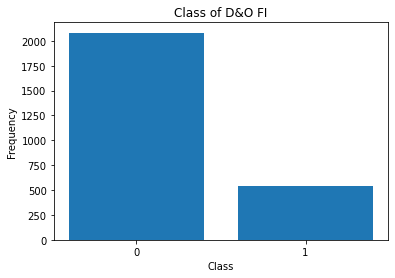

In [636]:
plt.bar(dict(Counter(y)).keys(), dict(Counter(y)).values())
plt.xticks(np.arange(2))
plt.title('Class of D&O FI')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [637]:
# report = sv.analyze(X_scaled, 'Class')
# report.show_html(filepath='D&O FI.html',
#                  open_browser=True,
#                  layout='vertical',
#                  scale=None)

In [638]:
# X[["Excess", "Class"]].groupby(['Excess'], as_index=False).mean().sort_values(
#     by='Class', ascending=False)

In [639]:
# X[["Territory", "Class"]].groupby(['Territory'], as_index=False).mean().sort_values(
#     by='Class', ascending=False)

In [640]:
# X[["BrokerUltimateName", "Class"]].groupby(['BrokerUltimateName'], as_index=False).mean().sort_values(
#     by='Class', ascending=False)

In [641]:
# X[["BrokerUltimateName", "XS_100Pct_USD"]].groupby(['BrokerUltimateName'], as_index=False).mean().sort_values(
#     by='XS_100Pct_USD', ascending=False)
# # X['XS_100Pct_USD'].mean()

#### Primary Business

In [642]:
X_p.describe()

,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,Full_GrossNetModelPrice,Full_GrossGrossTechnicalPrice,Full_GrossNetTechnicalPrice,Full_GNWP,PricingStrength,PricingStrength2,BrokerFeePct,Attachment,ModelToActualRto,ModelToTechnicalRto,PLR_ex_adj,Class
count,1.448000e+03,1.448000e+03,1.448000e+03,1448.000000,1.448000e+03,1448.000000,1448.000000,1.448000e+03,1.448000e+03,1.448000e+03,1.448000e+03,1.448000e+03,1448.000000,1448.000000,1448.000000,1.448000e+03,1448.000000,1448.000000,1448.000000,1448.000000
mean,1.165704e+07,9.985339e+04,9.726748e+04,60.790380,3.836668e+06,0.750700,0.001961,1.093924e+05,9.446125e+04,1.005528e+05,8.590595e+04,8.284360e+04,1.096459,0.102489,20.819176,3.836668e+06,1.366229,1.265589,1.010181,0.109116
std,1.364587e+07,5.937736e+05,5.978327e+05,29.549816,5.669071e+07,0.268778,0.123643,5.733692e+05,4.935267e+05,5.941161e+05,5.040314e+05,5.088460e+05,0.456340,0.522841,8.830505,5.669071e+07,2.580524,2.431942,1.950768,0.311892
min,2.500000e+05,1.000000e+02,1.000000e+02,5.000000,0.000000e+00,0.000000,-0.640000,0.000000e+00,0.000000e+00,1.000000e+02,6.525405e+01,6.524995e+01,0.230724,-0.769276,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,3.000000e+06,9.237956e+03,1.012500e+04,35.000000,2.838887e+03,0.640975,0.000000,7.916219e+03,6.225297e+03,9.261903e+03,6.952358e+03,7.650782e+03,0.890747,-0.109253,20.000000,2.838887e+03,0.595369,0.714286,0.433437,0.000000
50%,8.633094e+06,2.163026e+04,2.203119e+04,50.000000,3.089000e+04,0.729800,0.000000,2.176150e+04,1.762102e+04,2.163027e+04,1.743570e+04,1.750026e+04,1.006444,0.006444,22.500000,3.089000e+04,0.974232,1.000000,0.712300,0.000000
75%,1.500000e+07,5.117670e+04,4.600000e+04,100.000000,1.000000e+05,0.833025,0.000000,5.163231e+04,4.293427e+04,5.117669e+04,4.084877e+04,3.795075e+04,1.149129,0.149129,25.985001,1.000000e+05,1.455793,1.282686,1.066535,0.000000
max,1.377020e+08,1.306206e+07,1.306206e+07,100.000000,9.639140e+08,5.310000,1.600000,1.306206e+07,1.110275e+07,1.306206e+07,1.110275e+07,1.110275e+07,5.000000,7.500002,45.288985,9.639140e+08,42.264799,64.934393,31.439785,1.000000


In [643]:
X_p.skew()

Limit_100Pct_USD                  3.548018
Full_GGTP                        17.063288
Full_GGWP                        16.940663
LeaderLinePct                     0.318434
Ded_100Pct_USD                   16.811365
PLR                               4.713565
RARC                              5.824973
Full_GrossGrossModelPrice        16.956530
Full_GrossNetModelPrice          15.902264
Full_GrossGrossTechnicalPrice    17.031223
Full_GrossNetTechnicalPrice      16.494297
Full_GNWP                        16.392955
PricingStrength                   3.427569
PricingStrength2                  6.044763
BrokerFeePct                     -0.980147
Attachment                       16.811365
ModelToActualRto                 11.459891
ModelToTechnicalRto              17.314568
PLR_ex_adj                       11.005356
Class                             2.509997
dtype: float64

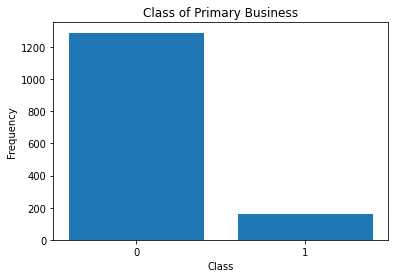

In [644]:
plt.bar(dict(Counter(y_p)).keys(), dict(Counter(y_p)).values())
plt.xticks(np.arange(2))
plt.title('Class of Primary Business')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [645]:
# report_p = sv.analyze(X_p_scaled, 'Class')
# report_p.show_html(filepath='D&O FI Primary.html',
#                  open_browser=True,
#                  layout='vertical',
#                  scale=None)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


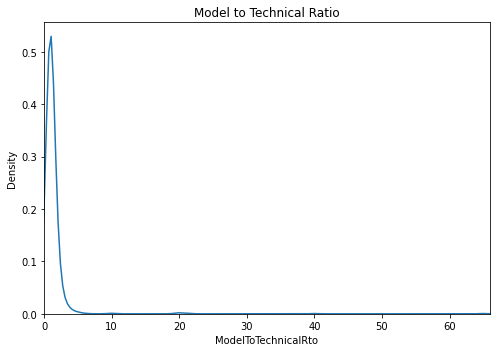

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


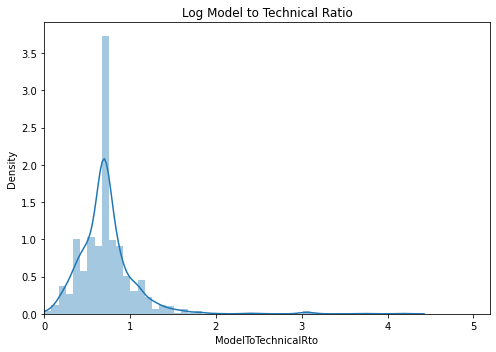

In [646]:
# Looking at the skewness of Full_GrossGrossModelPrice
plt.figure(figsize=(7,5))
sns.distplot(X_p.ModelToTechnicalRto, hist=False)
plt.title(f"Model to Technical Ratio")
plt.xlim(0, X_p.ModelToTechnicalRto.max()+1)
plt.tight_layout()
plt.show()

# Log-transform
plt.figure(figsize=(7,5))
sns.distplot(np.log1p(X_p.ModelToTechnicalRto))
plt.title(f"Log Model to Technical Ratio")
plt.xlim(0, np.log1p(X_p.ModelToTechnicalRto).max()+1)
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


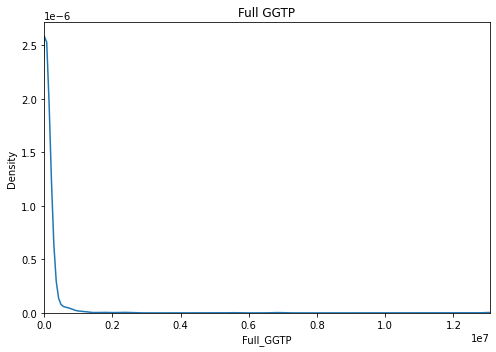

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


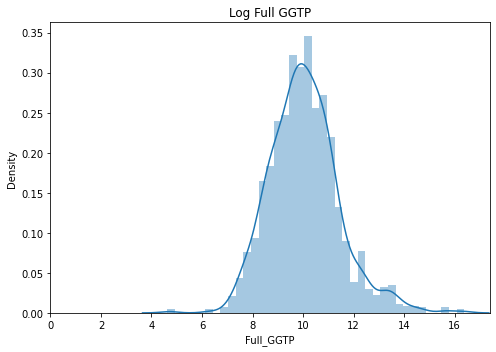

In [647]:
# Looking at the skewness of Full_GrossNetModelPrice
plt.figure(figsize=(7,5))
sns.distplot(X_p.Full_GGTP, hist=False)
plt.title(f"Full GGTP")
# plt.ylabel("Count of readings")
# plt.xlabel(f"Measured consumption")
plt.xlim(0, X_p.Full_GGTP.max()+1)
plt.tight_layout()
plt.show()

# Log transform
plt.figure(figsize=(7,5))
sns.distplot(np.log1p(X_p.Full_GGTP))
plt.title(f"Log Full GGTP")
# plt.ylabel("Count of readings")
# plt.xlabel(f"Measured consumption")
plt.xlim(0, np.log1p(X_p.Full_GGTP).max()+1)
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


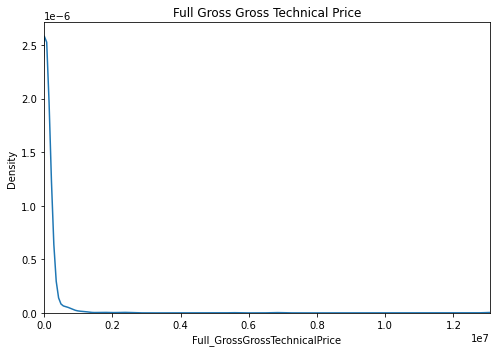

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


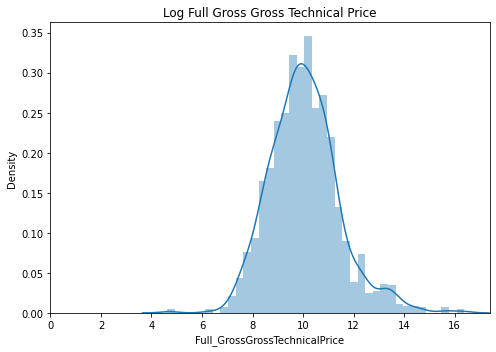

In [648]:
# Looking at the skewness of Full_GrossGrossModelPrice
plt.figure(figsize=(7,5))
sns.distplot(X_p.Full_GrossGrossTechnicalPrice, hist=False)
plt.title(f"Full Gross Gross Technical Price")
plt.xlim(0, X_p.Full_GrossGrossTechnicalPrice.max()+1)
plt.tight_layout()
plt.show()

# Log-transform
plt.figure(figsize=(7,5))
sns.distplot(np.log1p(X_p.Full_GrossGrossTechnicalPrice))
plt.title(f"Log Full Gross Gross Technical Price")
plt.xlim(0, np.log1p(X_p.Full_GrossGrossTechnicalPrice).max()+1)
plt.tight_layout()
plt.show()

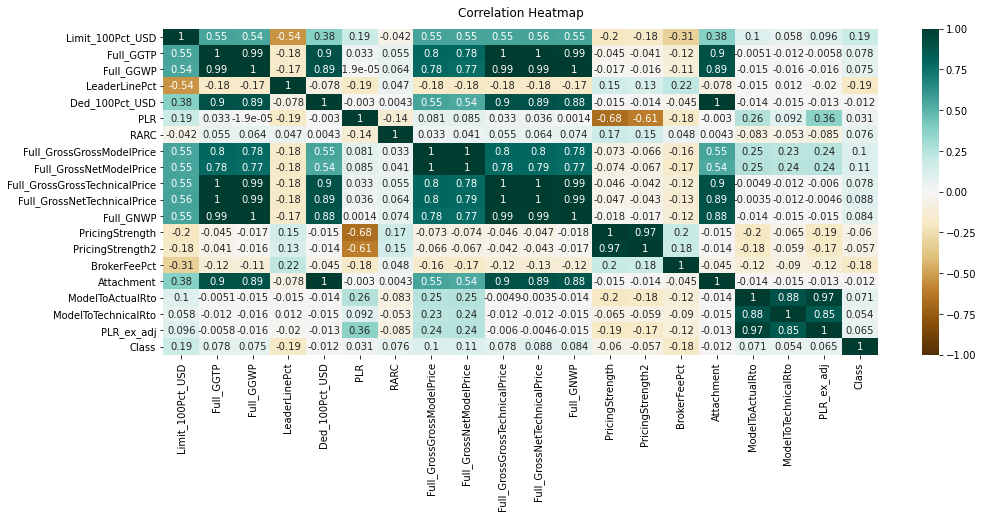

In [649]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(X_p.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

#### Excess Business

In [650]:
X_e.describe()

,Limit_100Pct_USD,Full_GGTP,Full_GGWP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,Full_GrossNetModelPrice,...,Full_GrossNetTechnicalPrice,Full_GNWP,PricingStrength,PricingStrength2,BrokerFeePct,Attachment,ModelToActualRto,ModelToTechnicalRto,PLR_ex_adj,Class
count,1.178000e+03,1.178000e+03,1.178000e+03,1178.000000,1.178000e+03,1.178000e+03,1178.000000,1178.000000,1.178000e+03,1.178000e+03,...,1.178000e+03,1.178000e+03,1178.000000,1178.000000,1178.000000,1.178000e+03,1178.000000,1178.000000,1178.000000,1178.000000
mean,3.404488e+07,2.012059e+05,2.145978e+05,35.135161,8.604903e+07,7.064627e+05,0.773395,-0.003781,1.746791e+05,1.583208e+05,...,1.817584e+05,1.936334e+05,1.087521,0.098134,12.176229,8.675550e+07,1.358423,1.236614,0.995472,0.327674
std,3.286786e+07,6.260159e+05,6.599927e+05,28.219348,1.138668e+08,2.814816e+06,0.341240,0.123138,3.005651e+05,2.769211e+05,...,5.456384e+05,5.786501e+05,0.486062,0.612493,10.288764,1.140814e+08,1.499285,1.185411,1.096155,0.469565
min,5.755396e+05,1.235600e+02,1.235600e+02,2.500000,1.000000e+05,0.000000e+00,0.060000,-0.550000,0.000000e+00,0.000000e+00,...,1.158500e+02,1.158369e+02,0.200000,-0.837959,0.000000,1.000000e+05,0.000000,0.000000,0.000000,0.000000
25%,1.235600e+07,2.858968e+04,2.895800e+04,17.500000,1.835522e+07,0.000000e+00,0.633000,0.000000,2.604134e+04,2.179275e+04,...,2.471677e+04,2.471200e+04,0.891482,-0.108518,2.999998,1.853400e+07,0.606060,0.666669,0.441394,0.000000
50%,2.500000e+07,6.500433e+04,6.425120e+04,27.403889,5.000000e+07,0.000000e+00,0.723250,0.000000,6.281638e+04,5.673692e+04,...,5.689943e+04,5.823527e+04,1.008720,0.008720,10.000000,5.000000e+07,0.985318,1.000000,0.715436,0.000000
75%,4.015700e+07,1.889737e+05,1.791795e+05,50.000000,1.122302e+08,9.106118e+04,0.823900,0.000000,1.869921e+05,1.727752e+05,...,1.796093e+05,1.665358e+05,1.166209,0.166209,22.500000,1.122302e+08,1.661600,1.428569,1.212187,1.000000
max,3.257195e+08,1.536414e+07,1.536414e+07,406.168831,8.500000e+08,3.671044e+07,4.762400,2.020000,3.068017e+06,2.761215e+06,...,1.305952e+07,1.305952e+07,5.000000,11.033068,35.000055,8.500000e+08,28.843219,26.218534,20.544843,1.000000


In [651]:
X_e.skew()

Limit_100Pct_USD                  3.571935
Full_GGTP                        16.811196
Full_GGWP                        14.749389
LeaderLinePct                     3.384349
XS_100Pct_USD                     3.068156
Ded_100Pct_USD                    7.161563
PLR                               3.987159
RARC                              9.443898
Full_GrossGrossModelPrice         4.457694
Full_GrossNetModelPrice           4.428016
Full_GrossGrossTechnicalPrice    16.792789
Full_GrossNetTechnicalPrice      15.739771
Full_GNWP                        13.696380
PricingStrength                   3.989897
PricingStrength2                  8.419986
BrokerFeePct                      0.335505
Attachment                        3.056126
ModelToActualRto                  7.230454
ModelToTechnicalRto               9.359697
PLR_ex_adj                        6.907442
Class                             0.735230
dtype: float64

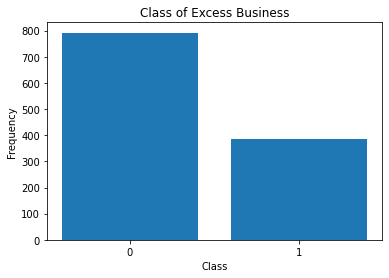

In [652]:
plt.bar(dict(Counter(y_e)).keys(), dict(Counter(y_e)).values())
plt.xticks(np.arange(2))
plt.title('Class of Excess Business')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

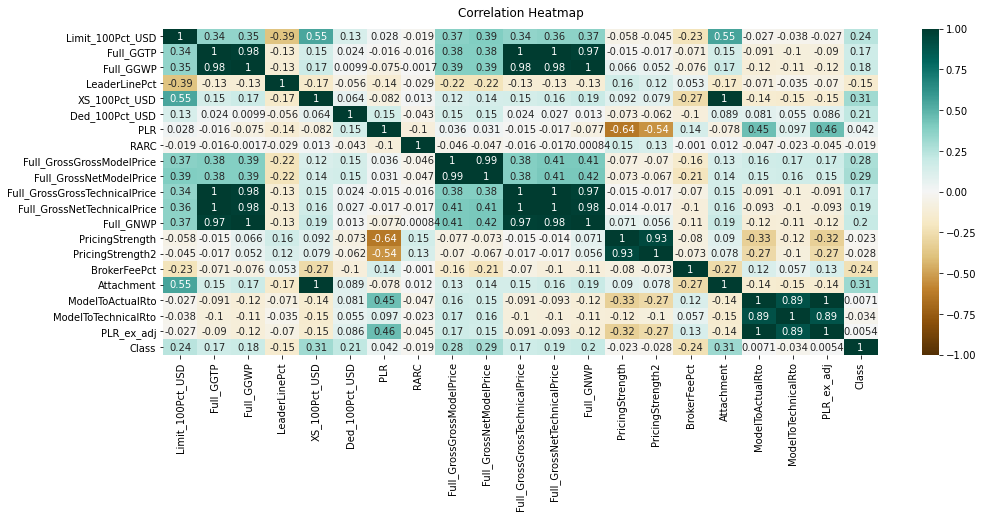

In [653]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(X_e.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [654]:
# report_e = sv.analyze(X_e_scaled, 'Class')
# report_e.show_html(filepath='D&O FI Excess.html',
#                  open_browser=True,
#                  layout='vertical',
#                  scale=None)

### Changing the data into log-transform

In [655]:
# Primary business
X_p['Full_GGTP'] = np.log1p(X_p.Full_GGTP)
X_p['Full_GGWP'] = np.log1p(X_p.Full_GGWP)
X_p['Ded_100Pct_USD'] = np.log1p(X_p.Ded_100Pct_USD)
X_p['Full_GrossGrossModelPrice'] = np.log1p(X_p.Full_GrossGrossModelPrice)
X_p['Full_GrossNetModelPrice'] = np.log1p(X_p.Full_GrossNetModelPrice)
X_p['Full_GrossGrossTechnicalPrice'] = np.log1p(X_p.Full_GrossGrossTechnicalPrice)
X_p['Full_GrossNetTechnicalPrice'] = np.log1p(X_p.Full_GrossNetTechnicalPrice)
X_p['Full_GNWP'] = np.log1p(X_p.Full_GNWP)
X_p['Attachment'] = np.log1p(X_p.Attachment)
X_p['ModelToActualRto'] = np.log1p(X_p.ModelToActualRto)
X_p['ModelToTechnicalRto'] = np.log1p(X_p.ModelToTechnicalRto)
X_p['PLR_ex_adj'] = np.log1p(X_p.PLR_ex_adj)

# Excess business
X_e['Full_GGTP'] = np.log1p(X_e.Full_GGTP)
X_e['Full_GGWP'] = np.log1p(X_e.Full_GGWP)
X_e['Full_GrossGrossTechnicalPrice'] = np.log1p(X_e.Full_GrossGrossTechnicalPrice)
X_e['Full_GrossNetTechnicalPrice'] = np.log1p(X_e.Full_GrossNetTechnicalPrice)
X_e['Full_GNWP'] = np.log1p(X_e.Full_GNWP)

In [656]:
# Dropping highly correlated features
correlated_features = set()
correlation_matrix = X_p.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
            
print(correlated_features)
X_p.drop(labels=correlated_features, axis=1, inplace=True)
X_p.head()

{'PricingStrength2', 'Full_GNWP', 'PLR_ex_adj', 'Full_GGWP', 'ModelToTechnicalRto', 'Full_GrossNetModelPrice', 'Full_GrossGrossTechnicalPrice', 'Attachment', 'Full_GrossNetTechnicalPrice'}


,PlacingBasis,SubClass,StatsMinorClassCode,Territory,Limit_100Pct_USD,Full_GGTP,LeaderStatus,LeaderLinePct,BrokerUltimateName,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,PLR_band,Class
0,Re,COMMERCIAL_BANK,DP,WORLDWIDE_(EXCLUDING_USA_&_CANADA),5.000000e+05,8.434246,LEAD,100.00,ARTHUR_J._GALLAGHER_&_CO.,9.903538,0.7155,0.0,8.171882,1.086720,27.500000,0.535206,Lower_Middle,0.0
1,OM,COMMERCIAL_BANK,DP,CONGO_(DEM._REP.),5.000000e+06,9.105091,LEAD,50.00,OXFORD_INSURANCE_BROKERS,0.000000,0.4150,0.0,8.412055,1.650000,25.000001,0.264693,Lower_quantile,0.0
2,OM,FUND_MANAGERS,DP,WORLDWIDE,2.246341e+07,10.890306,LEAD,66.67,AON_BENFIELD,10.242822,0.7455,0.0,10.890306,1.043040,20.000000,0.672299,Upper_Middle,0.0
3,OM,FUND_MANAGERS,DP,UNITED_KINGDOM,6.178000e+06,10.089768,LEAD,62.50,MILLER_INSURANCE_SERVICES,11.031351,0.6945,0.0,9.827416,1.025641,20.000000,0.559616,Lower_Middle,0.0
4,OM,FUND_MANAGERS,DP,SWITZERLAND,1.055347e+07,9.626719,LEAD,40.00,WILLIS,11.566804,0.9031,-0.1,9.651998,0.804332,22.500023,0.822023,Upper_Quantile,0.0


In [657]:
correlated_features = set()
correlation_matrix = X_e.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
            
print(correlated_features)
X_e.drop(labels=correlated_features, axis=1, inplace=True)
X_e.head()

{'PricingStrength2', 'Full_GNWP', 'PLR_ex_adj', 'Full_GGWP', 'Full_GrossNetModelPrice', 'Full_GrossGrossTechnicalPrice', 'Attachment', 'Full_GrossNetTechnicalPrice'}


,PlacingBasis,SubClass,StatsMinorClassCode,Territory,Limit_100Pct_USD,Full_GGTP,LeaderStatus,LeaderLinePct,BrokerUltimateName,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,ModelToTechnicalRto,PLR_band,Class
0,OM,GLOBAL_FINANCIAL_SERVICES,DT,AUSTRALIA,1.032765e+07,5.389295,LEAD,100.0,MARSH,1.445871e+08,0.0,0.494,0.00,31.150000,1.493257,2.751233,0.095669,0.142857,Lower_quantile,0.0
1,OM,COMMERCIAL_BANK,DP,SLOVENIA,5.615853e+07,11.724399,FOLLOW,20.0,R_K_HARRISON,8.423780e+07,0.0,0.507,-0.13,61774.363636,1.350000,25.000000,0.370370,0.500000,Lower_quantile,1.0
2,OM,COMMERCIAL_BANK,DN,AUSTRALIA,1.721275e+07,10.894857,FOLLOW,30.0,MARSH,2.926167e+08,0.0,0.924,0.02,37170.467210,0.775816,10.000011,0.888937,0.689651,Upper_Quantile,1.0
3,OM,GLOBAL_FINANCIAL_SERVICES,DT,AUSTRALIA,1.032765e+07,12.291694,LEAD,100.0,MARSH,1.445871e+08,0.0,0.494,0.00,31125.280000,1.493118,0.000000,0.095677,0.142857,Lower_quantile,1.0
4,Re,SPECIALTY_/_FINANCE_/_PROFESSIONAL_SERVI,DP,BAHRAIN,1.500000e+07,9.736961,FOLLOW,32.5,LONSDALE_INSURANCE_BROKERS_LIMITED,1.000000e+07,0.0,0.660,0.00,50793.019545,1.250015,25.000002,2.399973,3.000002,Lower_Middle,0.0


In [658]:
# Data scaling
# Scale only columns that have values greater than 1
to_scale = [col for col in X_p.columns[X_p.dtypes != 'object'] if X_p[col].max() > 1]
mms = MinMaxScaler()
scaled = mms.fit_transform(X_p[to_scale])
scaled = pd.DataFrame(scaled, columns=to_scale)

X_p_scaled = X_p.copy()
# Replace original columns with scaled ones
for col in scaled:
    X_p_scaled[col] = scaled[col]
    
X_p_scaled.head()

,PlacingBasis,SubClass,StatsMinorClassCode,Territory,Limit_100Pct_USD,Full_GGTP,LeaderStatus,LeaderLinePct,BrokerUltimateName,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,PLR_band,Class
0,Re,COMMERCIAL_BANK,DP,WORLDWIDE_(EXCLUDING_USA_&_CANADA),0.001819,0.324477,LEAD,1.000000,ARTHUR_J._GALLAGHER_&_CO.,0.478744,0.134746,0.285714,0.498735,0.179481,0.607212,0.142065,Lower_Middle,0.0
1,OM,COMMERCIAL_BANK,DP,CONGO_(DEM._REP.),0.034558,0.381473,LEAD,0.473684,OXFORD_INSURANCE_BROKERS,0.000000,0.078154,0.285714,0.513393,0.297587,0.552011,0.070260,Lower_quantile,0.0
2,OM,FUND_MANAGERS,DP,WORLDWIDE,0.161609,0.533146,LEAD,0.649158,AON_BENFIELD,0.495145,0.140395,0.285714,0.664642,0.170323,0.441608,0.178455,Upper_Middle,0.0
3,OM,FUND_MANAGERS,DP,UNITED_KINGDOM,0.043128,0.465132,LEAD,0.605263,MILLER_INSURANCE_SERVICES,0.533263,0.130791,0.285714,0.599773,0.166675,0.441608,0.148544,Lower_Middle,0.0
4,OM,FUND_MANAGERS,DP,SWITZERLAND,0.074960,0.425791,LEAD,0.368421,WILLIS,0.559147,0.170075,0.241071,0.589067,0.120272,0.496810,0.218197,Upper_Quantile,0.0


In [659]:
# Data scaling
# Scale only columns that have values greater than 1
to_scale = [col for col in X_e.columns[X_e.dtypes != 'object'] if X_e[col].max() > 1]
mms = MinMaxScaler()
scaled = mms.fit_transform(X_e[to_scale])
scaled = pd.DataFrame(scaled, columns=to_scale)

X_e_scaled = X_e.copy()
# Replace original columns with scaled ones
for col in scaled:
    X_e_scaled[col] = scaled[col]
    
X_e_scaled.head()

,PlacingBasis,SubClass,StatsMinorClassCode,Territory,Limit_100Pct_USD,Full_GGTP,LeaderStatus,LeaderLinePct,BrokerUltimateName,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,ModelToTechnicalRto,PLR_band,Class
0,OM,GLOBAL_FINANCIAL_SERVICES,DT,AUSTRALIA,0.029993,0.048155,LEAD,0.241535,MARSH,0.170005,0.0,0.092293,0.214008,0.000010,0.269429,0.078607,0.003317,0.005449,Lower_quantile,0.0
1,OM,COMMERCIAL_BANK,DP,SLOVENIA,0.170949,0.588566,FOLLOW,0.043352,R_K_HARRISON,0.098997,0.0,0.095058,0.163424,0.020135,0.239583,0.714285,0.012841,0.019070,Lower_quantile,1.0
2,OM,COMMERCIAL_BANK,DN,AUSTRALIA,0.051169,0.517802,FOLLOW,0.068125,MARSH,0.344178,0.0,0.183736,0.221790,0.012115,0.119962,0.285714,0.030820,0.026304,Upper_Quantile,1.0
3,OM,GLOBAL_FINANCIAL_SERVICES,DT,AUSTRALIA,0.029993,0.636958,LEAD,0.241535,MARSH,0.170005,0.0,0.092293,0.214008,0.010145,0.269400,0.000000,0.003317,0.005449,Lower_quantile,1.0
4,Re,SPECIALTY_/_FINANCE_/_PROFESSIONAL_SERVI,DP,BAHRAIN,0.044363,0.419029,FOLLOW,0.074318,LONSDALE_INSURANCE_BROKERS_LIMITED,0.011648,0.0,0.127594,0.214008,0.016556,0.218753,0.714285,0.083208,0.114423,Lower_Middle,0.0


In [660]:
X_encoded_p = pd.get_dummies(X_p_scaled, columns = ['PlacingBasis', 'SubClass', 'StatsMinorClassCode', 
                                        'Territory', 'LeaderStatus', 'BrokerUltimateName', 'PLR_band'])
X_encoded_e = pd.get_dummies(X_e_scaled, columns = ['PlacingBasis', 'SubClass', 'StatsMinorClassCode', 
                                        'Territory', 'LeaderStatus', 'BrokerUltimateName', 'PLR_band'])
X_encoded_p.drop('Class', axis=1, inplace=True)
X_encoded_e.drop('Class', axis=1, inplace=True)

In [661]:
# X_p_scaled[X_p_scaled.LeaderStatus == 'LEAD'].Full_GNWP.describe()
# X_p_scaled[["LeaderStatus", "Full_GNWP"]].groupby(['LeaderStatus'], as_index=False).mean().sort_values(
#     by='LeaderStatus', ascending=False)

### XGBoost

#### Primary business

In [662]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded_p, y_p, test_size=0.2, 
                                                    stratify = y_p, random_state=42)
# dtrain = xgb.DMatrix(X_train, y_train, feature_names=X_encoded.columns)
# dtest = xgb.DMatrix(X_test, y_test, feature_names=X_encoded.columns)

In [663]:
# param_grid ={
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.1, 1.0],
#     'reg_lambda': [1.0, 5.0, 10.0],
#     'scale_pos_weight' : [7, 8, 9]
# }

# # AUC since data is imbalance
# # Choose only 90% random subset of the data and for each tree, choose only 50% of the columns to
# # improve the speed and prevent overfitting
# optimal_params = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42, 
#                                                 subsample=0.9, colsample_bytree=0.5),
#                              param_grid=param_grid,
#                               scoring='roc_auc',
#                              verbose=2,
# #                               n_jobs=10,
#                              cv=3)

# optimal_params.fit(X_train, y_train, verbose=False, early_stopping_rounds=10, 
#             eval_metric='aucpr', eval_set=[(X_test, y_test)])

In [664]:
# print(optimal_params.best_params_)

In [665]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0,
                          learning_rate=0.01,
                          max_depth=5,
                          reg_lambda=10,
                          scale_pos_weight=8,
                           seed=42,
                           subsample=0.9, 
                            colsample_bytree=0.5)
clf_xgb.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, 
            eval_metric='aucpr', eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.23915
[1]	validation_0-aucpr:0.29085
[2]	validation_0-aucpr:0.29992
[3]	validation_0-aucpr:0.32928
[4]	validation_0-aucpr:0.36086
[5]	validation_0-aucpr:0.35763
[6]	validation_0-aucpr:0.36625


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[7]	validation_0-aucpr:0.39040
[8]	validation_0-aucpr:0.42878
[9]	validation_0-aucpr:0.43585
[10]	validation_0-aucpr:0.44863
[11]	validation_0-aucpr:0.45337
[12]	validation_0-aucpr:0.48834
[13]	validation_0-aucpr:0.49069
[14]	validation_0-aucpr:0.48586
[15]	validation_0-aucpr:0.49442
[16]	validation_0-aucpr:0.49921
[17]	validation_0-aucpr:0.49921
[18]	validation_0-aucpr:0.49724
[19]	validation_0-aucpr:0.49687
[20]	validation_0-aucpr:0.50019
[21]	validation_0-aucpr:0.50245
[22]	validation_0-aucpr:0.50699
[23]	validation_0-aucpr:0.50691
[24]	validation_0-aucpr:0.51352
[25]	validation_0-aucpr:0.51226
[26]	validation_0-aucpr:0.51269
[27]	validation_0-aucpr:0.50912
[28]	validation_0-aucpr:0.50884
[29]	validation_0-aucpr:0.51013
[30]	validation_0-aucpr:0.51309
[31]	validation_0-aucpr:0.51369
[32]	validation_0-aucpr:0.51393
[33]	validation_0-aucpr:0.51533
[34]	validation_0-aucpr:0.51174
[35]	validation_0-aucpr:0.51398
[36]	validation_0-aucpr:0.51055
[37]	validation_0-aucpr:0.51268
[38]	valida

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=10, scale_pos_weight=8, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [666]:
print('Best score:', clf_xgb.best_score)
print('Best iteration:', clf_xgb.best_iteration)

Best score: 0.521604
Best iteration: 58


Top 10 most important features
Feature: BrokerUltimateName_AON 
 Score: 0.02088
Feature: BrokerUltimateName_MARSH 
 Score: 0.02157
Feature: SubClass_INVESTMENT_BANK 
 Score: 0.02297
Feature: Territory_NEW_YORK 
 Score: 0.02387
Feature: Territory_SOUTH_AFRICA 
 Score: 0.02692
Feature: BrokerFeePct 
 Score: 0.02843
Feature: LeaderLinePct 
 Score: 0.02953
Feature: Full_GrossGrossModelPrice 
 Score: 0.03457
Feature: SubClass_FUND_MANAGERS 
 Score: 0.03673
Feature: Full_GGTP 
 Score: 0.07708


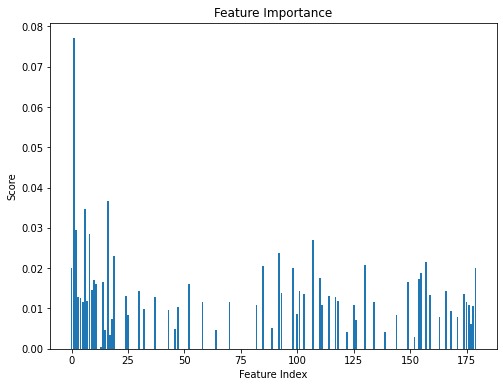

In [667]:
# Feature of importance
importance = clf_xgb.feature_importances_

# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' % (i,v))

feature = np.argsort(importance)[-10:]
score = importance[np.argsort(importance)[-10:]]

fs = zip(feature,score)
imp = tuple(fs)

print('Top 10 most important features')
for i in range(len(imp)):
    print('Feature:', X_train.columns[imp[i][0]], '\n Score: %.5f' % imp[i][1])

# plot feature importance
plt.figure(figsize=(8,6))
plt.bar([x for x in range(len(importance))], importance)
plt.title('Feature Importance')
plt.xlabel('Feature Index')
plt.ylabel('Score')
plt.show()

In [668]:
# Dropping unimportant features
drop_cols = X_train.columns[np.where(importance == 0)]
X_encoded_p.drop(drop_cols, axis=1, inplace=True)

In [669]:
# make predictions for test data
y_pred = clf_xgb.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)
roc_auc = roc_auc_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC:", roc_auc)
print(report)

Accuracy: 75.17%
ROC AUC: 0.7099079457364341
              precision    recall  f1-score   support

         0.0       0.95      0.76      0.85       258
         1.0       0.26      0.66      0.37        32

    accuracy                           0.75       290
   macro avg       0.60      0.71      0.61       290
weighted avg       0.87      0.75      0.79       290



/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ROC AUC: 0.8120155038759691
Precision-Recall AUC: 0.5213038354343169


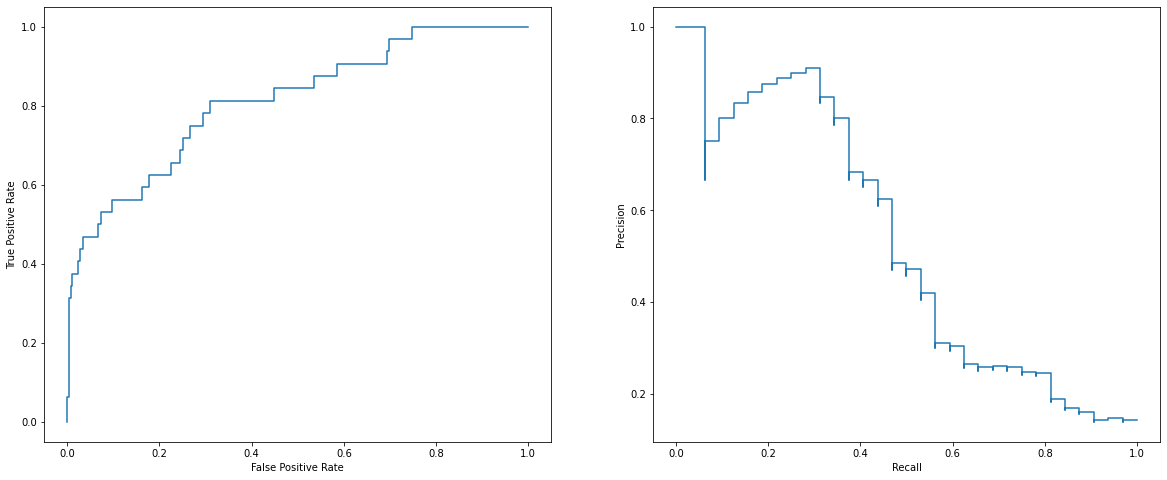

In [670]:
y_prob = clf_xgb.predict_proba(X_test)
probabilities = y_prob[:,1]

fpr_p, tpr_p, _ = roc_curve(y_test, probabilities)
roc_display_p = RocCurveDisplay(fpr=fpr_p, tpr=tpr_p)
roc_auc_p = auc(fpr_p, tpr_p)

prec_p, recall_p, _ = precision_recall_curve(y_test, probabilities)
pr_auc_p = auc(recall_p, prec_p)
pr_display_p = PrecisionRecallDisplay(precision=prec_p, recall=recall_p)

print('ROC AUC:', roc_auc_p)
print('Precision-Recall AUC:', pr_auc_p)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

roc_display_p.plot(ax=ax1)
pr_display_p.plot(ax=ax2)
plt.show()

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


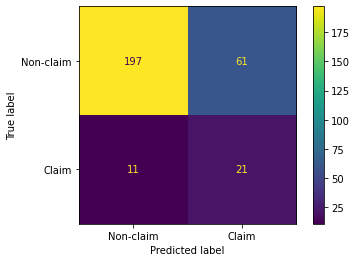

In [671]:
plot_confusion_matrix(clf_xgb, X_test, y_test, values_format='d', 
                      display_labels=['Non-claim', 'Claim'])

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:14:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight:  {'Full_GGTP': 4, 'BrokerUltimateName_MARSH': 1, 'SubClass_STOCKBROKERS': 1, 'BrokerUltimateName_AON': 1, 'Territory_UGANDA': 1, 'PLR': 4, 'SubClass_FUND_MANAGERS': 1, 'BrokerUltimateName_LONMAR_GLOBAL_RISKS_LIMITED': 1, 'Territory_USA': 1, 'BrokerUltimateName_LOCKTON': 1, 'ModelToActualRto': 4, 'BrokerFeePct': 1, 'BrokerUltimateName_HOWDEN': 1, 'Limit_100Pct_USD': 1}
gain:  {'Full_GGTP': 114.4498256575, 'BrokerUltimateName_MARSH': 13.1034241, 'SubClass_STOCKBROKERS': 13.8659973, 'BrokerUltimateName_AON': 15.1479492, 'Territory_UGANDA': 14.72995, 'PLR': 7.5968858, 'SubClass_FUND_MANAGERS': 63.3991089, 'BrokerUltimateName_LONMAR_GLOBAL_RISKS_LIMITED': 23.0765228, 'Territory_USA': 17.6887207, 'BrokerUltimateName_LOCKTON': 16.56427, 

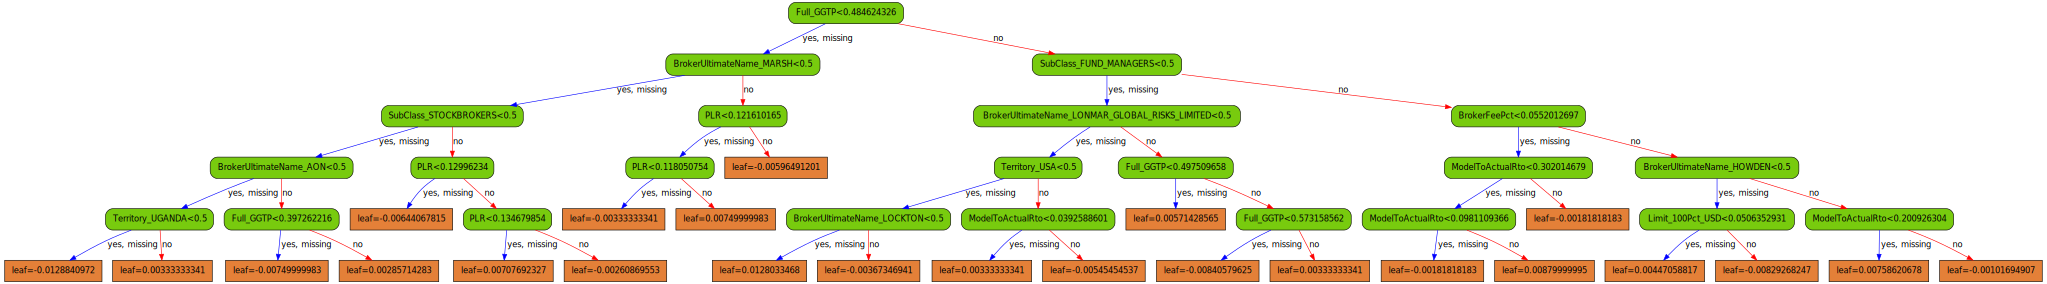

In [672]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0,
                          learning_rate=0.01,
                          max_depth=5,
                          reg_lambda=10,
                          scale_pos_weight=8,
                           seed=42,
                           n_estimators=1)
clf_xgb.fit(X_train, y_train)
bst=clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)


#### Excess business

In [673]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded_e, y_e, test_size=0.2, 
                                                    stratify = y_e, random_state=42)
# dtrain = xgb.DMatrix(X_train, y_train, feature_names=X_encoded.columns)
# dtest = xgb.DMatrix(X_test, y_test, feature_names=X_encoded.columns)

In [674]:
# param_grid ={
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.1, 1.0],
#     'reg_lambda': [1.0, 5.0, 10.0],
#     'scale_pos_weight' : [1, 2, 3]
# }

# # AUC since data is imbalance
# # Choose only 90% random subset of the data and for each tree, choose only 50% of the columns to
# # improve the speed and prevent overfitting
# optimal_params = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42, 
#                                                 subsample=0.9, colsample_bytree=0.5),
#                              param_grid=param_grid,
#                               scoring='roc_auc',
#                              verbose=2,
# #                               n_jobs=10,
#                              cv=3)

# optimal_params.fit(X_train, y_train, verbose=False, early_stopping_rounds=10, 
#             eval_metric='aucpr', eval_set=[(X_test, y_test)])

In [675]:
# print(optimal_params.best_params_)

In [676]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0.1,
                          learning_rate=0.1,
                          max_depth=4,
                          reg_lambda=5,
                          scale_pos_weight=2,
                           seed=42,
                           subsample=0.9, 
                            colsample_bytree=0.5
                           )
clf_xgb.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, 
            eval_metric='aucpr', eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.60657


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-aucpr:0.70641
[2]	validation_0-aucpr:0.71414
[3]	validation_0-aucpr:0.71619
[4]	validation_0-aucpr:0.72396
[5]	validation_0-aucpr:0.71288
[6]	validation_0-aucpr:0.71425
[7]	validation_0-aucpr:0.71132
[8]	validation_0-aucpr:0.71200
[9]	validation_0-aucpr:0.71920
[10]	validation_0-aucpr:0.71840
[11]	validation_0-aucpr:0.72609
[12]	validation_0-aucpr:0.72661
[13]	validation_0-aucpr:0.71598
[14]	validation_0-aucpr:0.71545
[15]	validation_0-aucpr:0.72849
[16]	validation_0-aucpr:0.73144
[17]	validation_0-aucpr:0.73606
[18]	validation_0-aucpr:0.74046
[19]	validation_0-aucpr:0.74010
[20]	validation_0-aucpr:0.73943
[21]	validation_0-aucpr:0.74392
[22]	validation_0-aucpr:0.74398
[23]	validation_0-aucpr:0.74897
[24]	validation_0-aucpr:0.74720
[25]	validation_0-aucpr:0.75547
[26]	validation_0-aucpr:0.75289
[27]	validation_0-aucpr:0.75919
[28]	validation_0-aucpr:0.76475
[29]	validation_0-aucpr:0.76896
[30]	validation_0-aucpr:0.76877
[31]	validation_0-aucpr:0.76652
[32]	validation_0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=5, scale_pos_weight=2, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [677]:
print('Best score:', clf_xgb.best_score)
print('Best iteration:', clf_xgb.best_iteration)

Best score: 0.79267
Best iteration: 67


Top 10 most important features
Feature: Territory_AUSTRALIA 
 Score: 0.02719
Feature: PlacingBasis_OM 
 Score: 0.02871
Feature: XS_100Pct_USD 
 Score: 0.03407
Feature: Territory_JAPAN 
 Score: 0.03944
Feature: Full_GGTP 
 Score: 0.04370
Feature: BrokerUltimateName_LOCKTON 
 Score: 0.04377
Feature: SubClass_COMMERCIAL_BANK 
 Score: 0.04687
Feature: StatsMinorClassCode_DP 
 Score: 0.05265
Feature: SubClass_GLOBAL_FINANCIAL_SERVICES 
 Score: 0.06435
Feature: SubClass_FUND_MANAGERS 
 Score: 0.13470


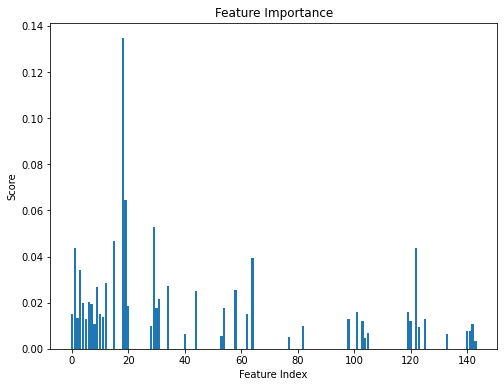

In [678]:
# Feature of importance
importance = clf_xgb.feature_importances_

# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' % (i,v))

feature = np.argsort(importance)[-10:]
score = importance[np.argsort(importance)[-10:]]

fs = zip(feature,score)
imp = tuple(fs)

print('Top 10 most important features')
for i in range(len(imp)):
    print('Feature:', X_train.columns[imp[i][0]], '\n Score: %.5f' % imp[i][1])

# plot feature importance
plt.figure(figsize=(8,6))
plt.bar([x for x in range(len(importance))], importance)
plt.title('Feature Importance')
plt.xlabel('Feature Index')
plt.ylabel('Score')
plt.show()

In [679]:
# Dropping unimportant features
drop_cols = X_train.columns[np.where(importance == 0)]
X_encoded_e.drop(drop_cols, axis=1, inplace=True)

In [680]:
# make predictions for test data
y_pred = clf_xgb.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)
roc_auc = roc_auc_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC:", roc_auc)
print(report)

Accuracy: 79.24%
ROC AUC: 0.7822837539818672
              precision    recall  f1-score   support

         0.0       0.87      0.81      0.84       159
         1.0       0.66      0.75      0.70        77

    accuracy                           0.79       236
   macro avg       0.77      0.78      0.77       236
weighted avg       0.80      0.79      0.80       236



/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ROC AUC: 0.8698031528220207
Precision-Recall AUC: 0.7925998831464198


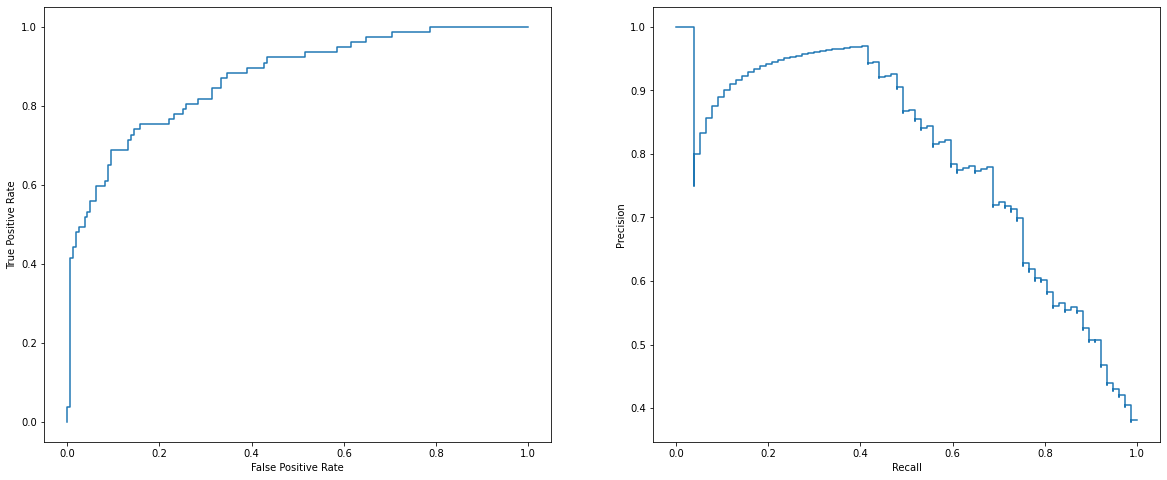

In [681]:
y_prob = clf_xgb.predict_proba(X_test)
probabilities = y_prob[:,1]

fpr_e, tpr_e, _ = roc_curve(y_test, probabilities)
roc_display_e = RocCurveDisplay(fpr=fpr_e, tpr=tpr_e)
roc_auc_e = auc(fpr_e, tpr_e)

prec_e, recall_e, _ = precision_recall_curve(y_test, probabilities)
pr_auc_e = auc(recall_e, prec_e)
pr_display_e = PrecisionRecallDisplay(precision=prec_e, recall=recall_e)

print('ROC AUC:', roc_auc_e)
print('Precision-Recall AUC:', pr_auc_e)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

roc_display_e.plot(ax=ax1)
pr_display_e.plot(ax=ax2)
plt.show()

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


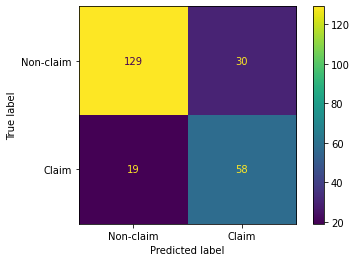

In [682]:
plot_confusion_matrix(clf_xgb, X_test, y_test, values_format='d', 
                      display_labels=['Non-claim', 'Claim'])

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:14:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight:  {'SubClass_FUND_MANAGERS': 1, 'Full_GGTP': 3, 'Limit_100Pct_USD': 2, 'XS_100Pct_USD': 1, 'BrokerFeePct': 1, 'BrokerUltimateName_LOCKTON': 1, 'StatsMinorClassCode_DS': 1, 'RARC': 2, 'PLR_band_Upper_Middle': 1}
gain:  {'SubClass_FUND_MANAGERS': 209.456268, 'Full_GGTP': 46.5384527, 'Limit_100Pct_USD': 7.06579782, 'XS_100Pct_USD': 4.35318327, 'BrokerFeePct': 58.1600266, 'BrokerUltimateName_LOCKTON': 23.2575226, 'StatsMinorClassCode_DS': 7.37088013, 'RARC': 2.6864913699999997, 'PLR_band_Upper_Middle': 3.78917384}
cover:  {'SubClass_FUND_MANAGERS': 312.75, 'Full_GGTP': 110.91666666666667, 'Limit_100Pct_USD': 49.75, 'XS_100Pct_USD': 10.5, 'BrokerFeePct': 202.75, 'BrokerUltimateName_LOCKTON': 145.25, 'StatsMinorClassCode_DS': 69.0, 'RARC

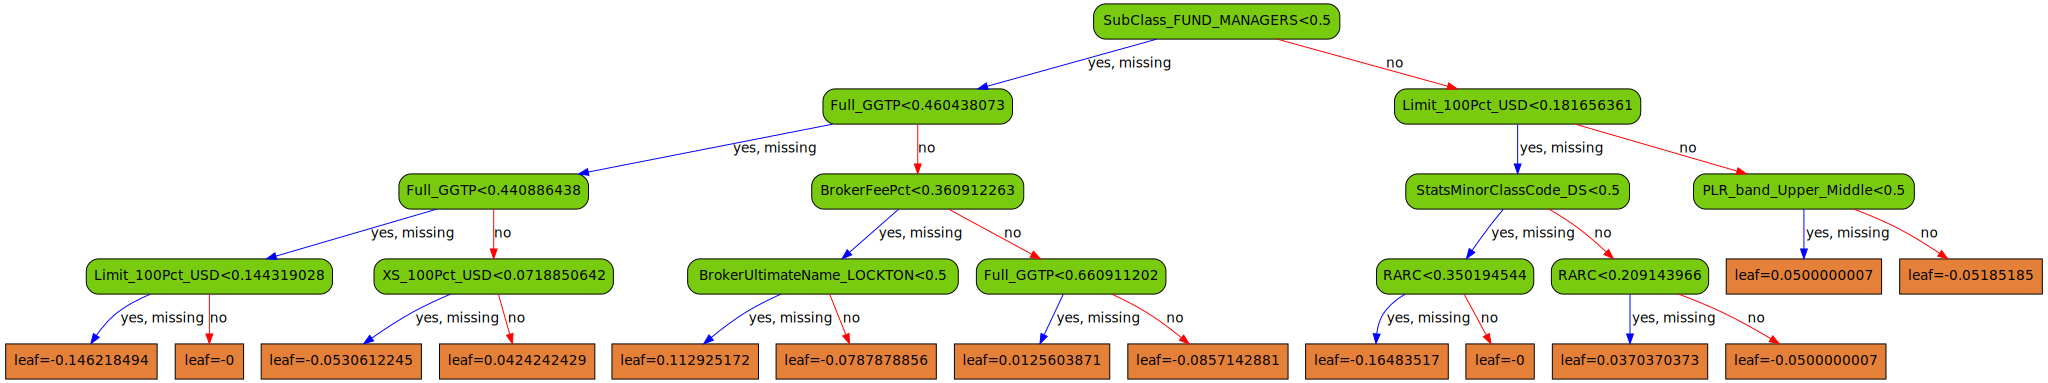

In [683]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                        gamma=0.1,
                          learning_rate=0.1,
                          max_depth=4,
                          reg_lambda=5,
                          scale_pos_weight=2,
                           seed=42,
                           n_estimators=1)
clf_xgb.fit(X_train, y_train)
bst=clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)


## Splitting the Dataset into Training and Testing

In [684]:
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_encoded_p, y_p, test_size=0.2, 
                                                    stratify = y_p, random_state=42)

X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X_encoded_e, y_e, test_size=0.2, 
                                                    stratify = y_e, random_state=42)

In [685]:
# print(np.sum(X_encoded_e['LeaderStatus_FOLLOW']))
# print(np.sum(X_encoded_e['LeaderStatus_LEAD']))
# print(np.sum(X_encoded_e['PlacingBasis_OM']))
print(np.sum(X_encoded_p['PlacingBasis_Re']))

308


## Random Over Sampler

In [686]:
ros = RandomOverSampler(sampling_strategy = 'minority', random_state=42)

# Primary business
X_train_res_p, y_train_res_p = ros.fit_resample(X_train_p, y_train_p)

# Excess business
X_train_res_e, y_train_res_e = ros.fit_resample(X_train_e, y_train_e)

### XGBoost (ROS)

#### Primary business

In [687]:
# param_grid ={
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.1, 1.0],
#     'reg_lambda': [1.0, 5.0, 10.0],
#     'scale_pos_weight' : [1, 2, 3]
# }

# # AUC since data is imbalance
# # Choose only 90% random subset of the data and for each tree, choose only 50% of the columns to
# # improve the speed and prevent overfitting
# optimal_params = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42, 
#                                                 subsample=0.9, colsample_bytree=0.5),
#                              param_grid=param_grid,
#                               scoring='roc_auc',
#                              verbose=2,
# #                               n_jobs=10,
#                              cv=3)

# optimal_params.fit(X_train_res_p, y_train_res_p, verbose=False, early_stopping_rounds=10, 
#             eval_metric='aucpr', eval_set=[(X_test_p, y_test_p)])

In [688]:
# print(optimal_params.best_params_)

In [689]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0,
                          learning_rate=0.1,
                          max_depth=6,
                          reg_lambda=1,
                          scale_pos_weight=1,
                           seed=42,
                           subsample=0.9, 
                            colsample_bytree=0.5)
clf_xgb.fit(X_train_res_p, y_train_res_p, verbose=True, early_stopping_rounds=10, 
            eval_metric='aucpr', eval_set=[(X_test_p, y_test_p)])

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-aucpr:0.26882
[1]	validation_0-aucpr:0.31165
[2]	validation_0-aucpr:0.35702
[3]	validation_0-aucpr:0.45210
[4]	validation_0-aucpr:0.46519
[5]	validation_0-aucpr:0.47100
[6]	validation_0-aucpr:0.46558
[7]	validation_0-aucpr:0.48197
[8]	validation_0-aucpr:0.48493
[9]	validation_0-aucpr:0.51375
[10]	validation_0-aucpr:0.53642
[11]	validation_0-aucpr:0.52913
[12]	validation_0-aucpr:0.51712
[13]	validation_0-aucpr:0.53455
[14]	validation_0-aucpr:0.52866
[15]	validation_0-aucpr:0.52915
[16]	validation_0-aucpr:0.52650
[17]	validation_0-aucpr:0.52919
[18]	validation_0-aucpr:0.53127
[19]	validation_0-aucpr:0.52213


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [690]:
print('Best score:', clf_xgb.best_score)
print('Best iteration:', clf_xgb.best_iteration)

Best score: 0.536416
Best iteration: 10


In [691]:
# make predictions for test data
y_pred = clf_xgb.predict(X_test_p)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test_p, predictions)
report = classification_report(y_test_p, predictions)
roc_auc = roc_auc_score(y_test_p, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC:", roc_auc)
print(report)

Accuracy: 81.72%
ROC AUC: 0.7330426356589147
              precision    recall  f1-score   support

         0.0       0.95      0.84      0.89       258
         1.0       0.33      0.62      0.43        32

    accuracy                           0.82       290
   macro avg       0.64      0.73      0.66       290
weighted avg       0.88      0.82      0.84       290



/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ROC AUC: 0.8165576550387597
Precision-Recall AUC: 0.5365797336792073


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


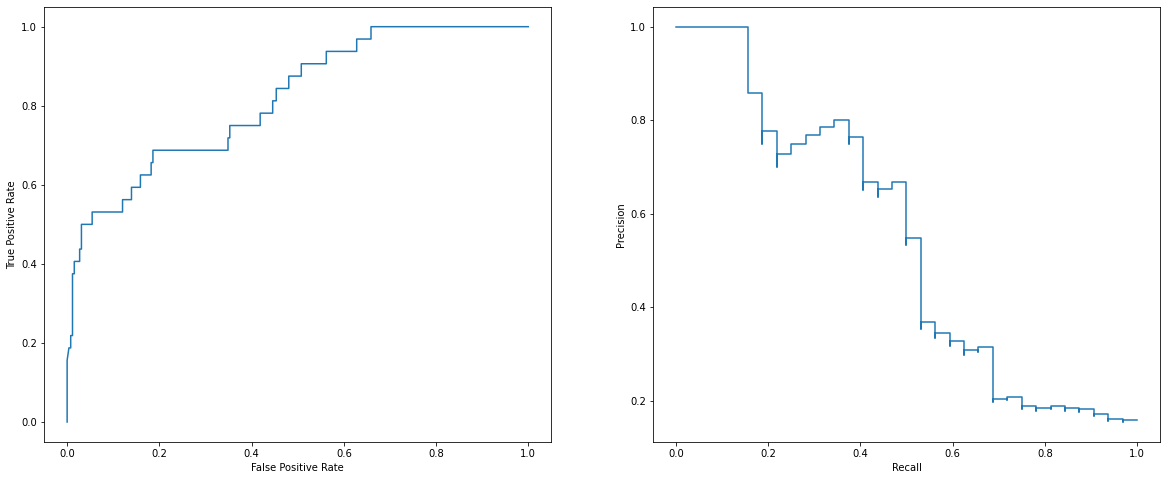

In [692]:
y_prob = clf_xgb.predict_proba(X_test_p)
probabilities = y_prob[:,1]

fpr_ros_p, tpr_ros_p, _ = roc_curve(y_test_p, probabilities)
roc_display_ros_p = RocCurveDisplay(fpr=fpr_ros_p, tpr=tpr_ros_p)
roc_auc_ros_p = auc(fpr_ros_p, tpr_ros_p)

prec_ros_p, recall_ros_p, _ = precision_recall_curve(y_test_p, probabilities)
pr_auc_ros_p = auc(recall_ros_p, prec_ros_p)
pr_display_ros_p = PrecisionRecallDisplay(precision=prec_ros_p, recall=recall_ros_p)

print('ROC AUC:', roc_auc_ros_p)
print('Precision-Recall AUC:', pr_auc_ros_p)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

roc_display_ros_p.plot(ax=ax1)
pr_display_ros_p.plot(ax=ax2)
plt.show()

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


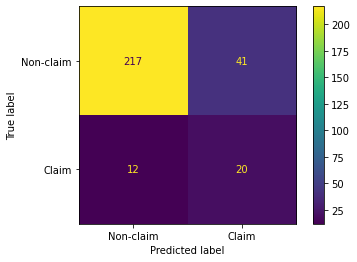

In [693]:
plot_confusion_matrix(clf_xgb, X_test_p, y_test_p, values_format='d', 
                      display_labels=['Non-claim', 'Claim'])

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:14:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight:  {'Full_GGTP': 7, 'Territory_SERBIA/MONTENEGRO_(YUGOSLAVIA)': 1, 'PLR': 4, 'PricingStrength': 1, 'BrokerUltimateName_HOWDEN': 2, 'Ded_100Pct_USD': 2, 'Full_GrossGrossModelPrice': 3, 'BrokerUltimateName_MARSH': 1, 'Territory_UGANDA': 1, 'ModelToActualRto': 2, 'RARC': 4, 'SubClass_FUND_MANAGERS': 1, 'Limit_100Pct_USD': 3, 'Territory_NEBRASKA': 1}
gain:  {'Full_GGTP': 78.23380440571428, 'Territory_SERBIA/MONTENEGRO_(YUGOSLAVIA)': 23.9682617, 'PLR': 31.786633975, 'PricingStrength': 31.7900848, 'BrokerUltimateName_HOWDEN': 17.279450415, 'Ded_100Pct_USD': 13.593794355, 'Full_GrossGrossModelPrice': 9.418427176666667, 'BrokerUltimateName_MARSH': 22.8334198, 'Territory_UGANDA': 24.7865143, 'ModelToActualRto': 7.390071415, 'RARC': 11.702930

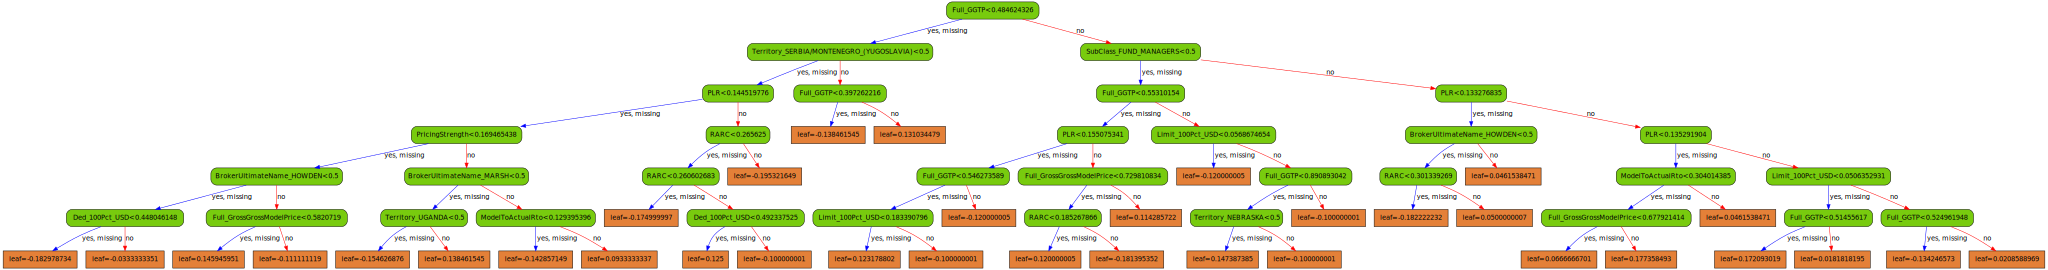

In [694]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                         gamma=0,
                          learning_rate=0.1,
                          max_depth=6,
                          reg_lambda=1,
                          scale_pos_weight=1,
                           seed=42,
                           n_estimators=1)
clf_xgb.fit(X_train_res_p, y_train_res_p)
bst=clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)


#### Excess business

In [695]:
# param_grid ={
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.1, 1.0],
#     'reg_lambda': [1.0, 5.0, 10.0],
#     'scale_pos_weight' : [1, 2, 3]
# }

# # AUC since data is imbalance
# # Choose only 90% random subset of the data and for each tree, choose only 50% of the columns to
# # improve the speed and prevent overfitting
# optimal_params = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42, 
#                                                 subsample=0.9, colsample_bytree=0.5),
#                              param_grid=param_grid,
#                               scoring='roc_auc',
#                              verbose=2,
# #                               n_jobs=10,
#                              cv=3)

# optimal_params.fit(X_train_res_e, y_train_res_e, verbose=False, early_stopping_rounds=10, 
#             eval_metric='aucpr', eval_set=[(X_test_e, y_test_e)])

In [696]:
# print(optimal_params.best_params_)

In [697]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0.1,
                          learning_rate=0.1,
                          max_depth=6,
                          reg_lambda=1,
                          scale_pos_weight=3,
                           seed=42,
                           subsample=0.9, 
                            colsample_bytree=0.5
                           )
clf_xgb.fit(X_train_res_e, y_train_res_e, verbose=True, early_stopping_rounds=10, 
            eval_metric='aucpr', eval_set=[(X_test_e, y_test_e)])

[0]	validation_0-aucpr:0.53703


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-aucpr:0.61464
[2]	validation_0-aucpr:0.67222
[3]	validation_0-aucpr:0.67176
[4]	validation_0-aucpr:0.67737
[5]	validation_0-aucpr:0.67649
[6]	validation_0-aucpr:0.68206
[7]	validation_0-aucpr:0.68615
[8]	validation_0-aucpr:0.70095
[9]	validation_0-aucpr:0.70909
[10]	validation_0-aucpr:0.70749
[11]	validation_0-aucpr:0.70652
[12]	validation_0-aucpr:0.71785
[13]	validation_0-aucpr:0.71832
[14]	validation_0-aucpr:0.72061
[15]	validation_0-aucpr:0.72765
[16]	validation_0-aucpr:0.72264
[17]	validation_0-aucpr:0.72148
[18]	validation_0-aucpr:0.71436
[19]	validation_0-aucpr:0.70964
[20]	validation_0-aucpr:0.71591
[21]	validation_0-aucpr:0.72855
[22]	validation_0-aucpr:0.73008
[23]	validation_0-aucpr:0.73107
[24]	validation_0-aucpr:0.73564
[25]	validation_0-aucpr:0.74148
[26]	validation_0-aucpr:0.74838
[27]	validation_0-aucpr:0.76353
[28]	validation_0-aucpr:0.77001
[29]	validation_0-aucpr:0.77054
[30]	validation_0-aucpr:0.78194
[31]	validation_0-aucpr:0.78431
[32]	validation_0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [698]:
print('Best score:', clf_xgb.best_score)
print('Best iteration:', clf_xgb.best_iteration)

Best score: 0.805824
Best iteration: 63


In [699]:
# make predictions for test data
y_pred = clf_xgb.predict(X_test_e)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test_e, predictions)
report = classification_report(y_test_e, predictions)
roc_auc = roc_auc_score(y_test_e, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC:", roc_auc)
print(report)

Accuracy: 77.97%
ROC AUC: 0.786245201339541
              precision    recall  f1-score   support

         0.0       0.89      0.77      0.82       159
         1.0       0.63      0.81      0.70        77

    accuracy                           0.78       236
   macro avg       0.76      0.79      0.76       236
weighted avg       0.80      0.78      0.79       236



/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ROC AUC: 0.8791145960957282
Precision-Recall AUC: 0.8057973734822775


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


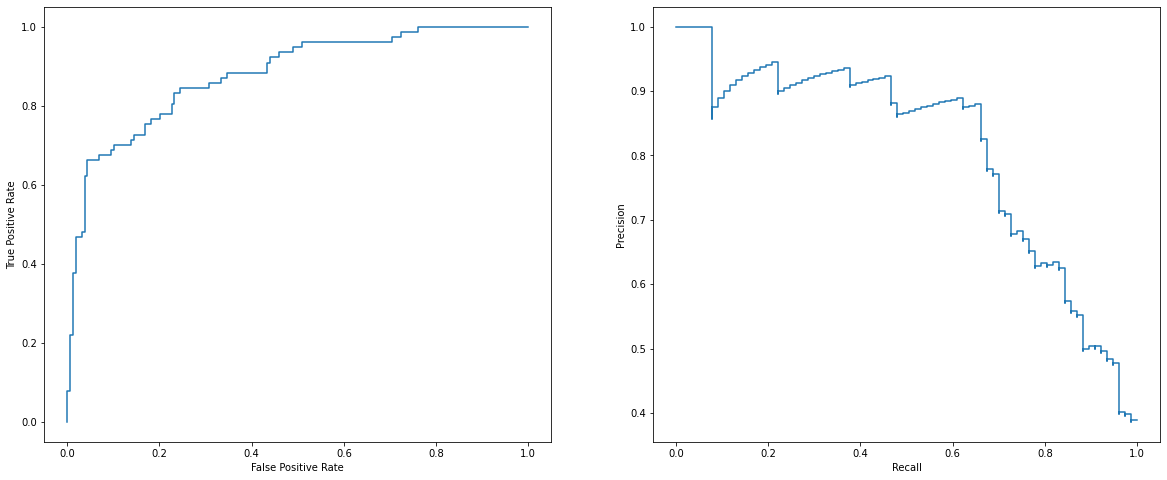

In [700]:
y_prob = clf_xgb.predict_proba(X_test_e)
probabilities = y_prob[:,1]

fpr_ros_e, tpr_ros_e, _ = roc_curve(y_test_e, probabilities)
roc_display_ros_e = RocCurveDisplay(fpr=fpr_ros_e, tpr=tpr_ros_e)
roc_auc_ros_e = auc(fpr_ros_e, tpr_ros_e)

prec_ros_e, recall_ros_e, _ = precision_recall_curve(y_test_e, probabilities)
pr_auc_ros_e = auc(recall_ros_e, prec_ros_e)
pr_display_ros_e = PrecisionRecallDisplay(precision=prec_ros_e, recall=recall_ros_e)

print('ROC AUC:', roc_auc_ros_e)
print('Precision-Recall AUC:', pr_auc_ros_e)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

roc_display_ros_e.plot(ax=ax1)
pr_display_ros_e.plot(ax=ax2)
plt.show()

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


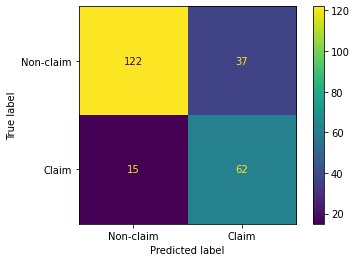

In [701]:
plot_confusion_matrix(clf_xgb, X_test_e, y_test_e, values_format='d', 
                      display_labels=['Non-claim', 'Claim'])

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:14:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight:  {'SubClass_FUND_MANAGERS': 1, 'Full_GGTP': 2, 'ModelToTechnicalRto': 1, 'XS_100Pct_USD': 2, 'BrokerUltimateName_JLT': 1, 'PLR_band_Lower_Middle': 1, 'Territory_AUSTRALIA': 1, 'BrokerFeePct': 2, 'BrokerUltimateName_LOCKTON': 1, 'SubClass_INSURANCE_COMPANY': 1, 'Territory_JAPAN': 1, 'ModelToActualRto': 1, 'PLR_band_Upper_Middle': 2, 'Limit_100Pct_USD': 2, 'StatsMinorClassCode_DS': 1, 'BrokerUltimateName_HOWDEN': 1, 'RARC': 2, 'Territory_NETHERLANDS': 1, 'Full_GrossGrossModelPrice': 3, 'BrokerUltimateName_MARSH': 1}
gain:  {'SubClass_FUND_MANAGERS': 365.6073, 'Full_GGTP': 116.81732065, 'ModelToTechnicalRto': 10.1614838, 'XS_100Pct_USD': 11.09191894, 'BrokerUltimateName_JLT': 0.997924805, 'PLR_band_Lower_Middle': 2.56209183, 'Territo

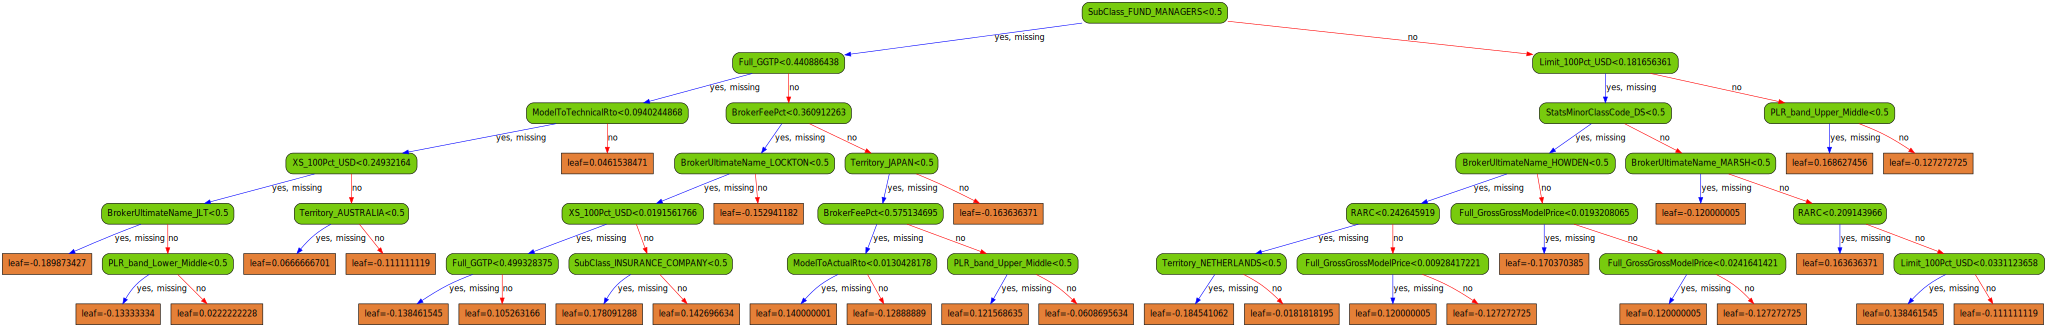

In [702]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0.1,
                          learning_rate=0.1,
                          max_depth=6,
                          reg_lambda=1,
                          scale_pos_weight=3,
                           seed=42,
                           n_estimators=1)
clf_xgb.fit(X_train_res_e, y_train_res_e)
bst=clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)


## SMOTE

In [703]:
sm = SMOTE(sampling_strategy = 'minority', random_state=42)

# Primary business
X_train_sm_p, y_train_sm_p = sm.fit_resample(X_train_p, y_train_p)

# Excess business
X_train_sm_e, y_train_sm_e = sm.fit_resample(X_train_e, y_train_e)

### XGBoost (SMOTE)

#### Primary business

In [704]:
# param_grid ={
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.1, 1.0],
#     'reg_lambda': [1.0, 5.0, 10.0],
#     'scale_pos_weight' : [1, 2, 3]
# }

# # AUC since data is imbalance
# # Choose only 90% random subset of the data and for each tree, choose only 50% of the columns to
# # improve the speed and prevent overfitting
# optimal_params = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42, 
#                                                 subsample=0.9, colsample_bytree=0.5),
#                              param_grid=param_grid,
#                               scoring='roc_auc',
#                              verbose=2,
# #                               n_jobs=10,
#                              cv=3)

# optimal_params.fit(X_train_sm_p, y_train_sm_p, verbose=False, early_stopping_rounds=10, 
#             eval_metric='aucpr', eval_set=[(X_test_p, y_test_p)])

In [705]:
# print(optimal_params.best_params_)

In [706]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0,
                          learning_rate=0.1,
                          max_depth=6,
                          reg_lambda=5,
                          scale_pos_weight=2,
                           seed=42,
                           subsample=0.9, 
                            colsample_bytree=0.5)
clf_xgb.fit(X_train_sm_p, y_train_sm_p, verbose=True, early_stopping_rounds=10, 
            eval_metric='aucpr', eval_set=[(X_test_p, y_test_p)])

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-aucpr:0.30075
[1]	validation_0-aucpr:0.38803
[2]	validation_0-aucpr:0.38938
[3]	validation_0-aucpr:0.41012
[4]	validation_0-aucpr:0.44579
[5]	validation_0-aucpr:0.45321
[6]	validation_0-aucpr:0.43837
[7]	validation_0-aucpr:0.44032
[8]	validation_0-aucpr:0.46401
[9]	validation_0-aucpr:0.45779
[10]	validation_0-aucpr:0.45150
[11]	validation_0-aucpr:0.49532
[12]	validation_0-aucpr:0.48794
[13]	validation_0-aucpr:0.47465
[14]	validation_0-aucpr:0.47221
[15]	validation_0-aucpr:0.46693
[16]	validation_0-aucpr:0.46834
[17]	validation_0-aucpr:0.46945
[18]	validation_0-aucpr:0.46103
[19]	validation_0-aucpr:0.47636
[20]	validation_0-aucpr:0.48965
[21]	validation_0-aucpr:0.47654


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=5, scale_pos_weight=2, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [707]:
print('Best score:', clf_xgb.best_score)
print('Best iteration:', clf_xgb.best_iteration)

Best score: 0.495316
Best iteration: 11


In [708]:
# make predictions for test data
y_pred = clf_xgb.predict(X_test_p)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test_p, predictions)
report = classification_report(y_test_p, predictions)
roc_auc = roc_auc_score(y_test_p, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC:", roc_auc)
print(report)

Accuracy: 72.76%
ROC AUC: 0.7237160852713178
              precision    recall  f1-score   support

         0.0       0.95      0.73      0.83       258
         1.0       0.25      0.72      0.37        32

    accuracy                           0.73       290
   macro avg       0.60      0.72      0.60       290
weighted avg       0.88      0.73      0.78       290



/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ROC AUC: 0.8019016472868218
Precision-Recall AUC: 0.49740965105034046


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


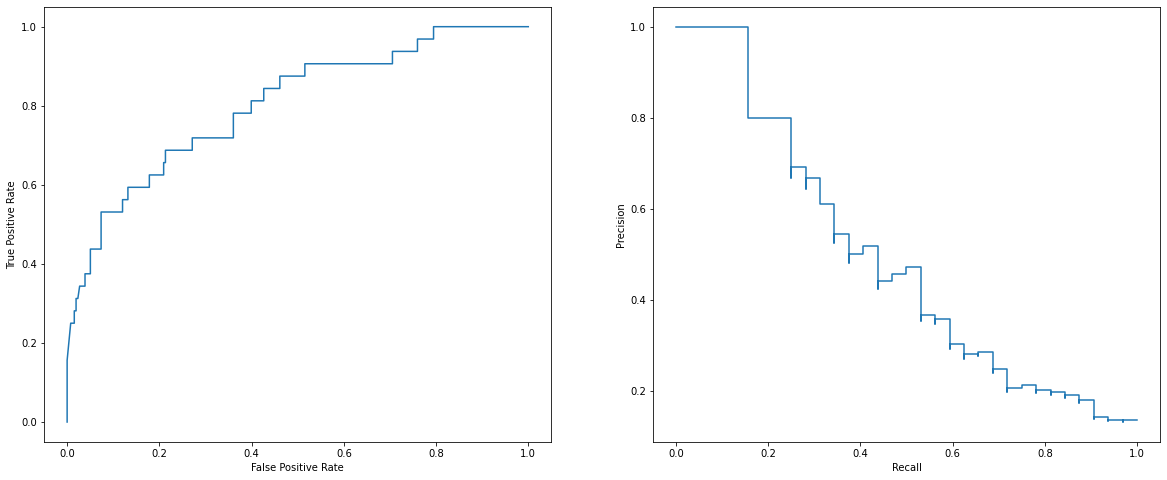

In [709]:
y_prob = clf_xgb.predict_proba(X_test_p)
probabilities = y_prob[:,1]

fpr_sm_p, tpr_sm_p, _ = roc_curve(y_test_p, probabilities)
roc_display_sm_p = RocCurveDisplay(fpr=fpr_sm_p, tpr=tpr_sm_p)
roc_auc_sm_p = auc(fpr_sm_p, tpr_sm_p)

prec_sm_p, recall_sm_p, _ = precision_recall_curve(y_test_p, probabilities)
pr_auc_sm_p = auc(recall_sm_p, prec_sm_p)
pr_display_sm_p = PrecisionRecallDisplay(precision=prec_sm_p, recall=recall_sm_p)

print('ROC AUC:', roc_auc_sm_p)
print('Precision-Recall AUC:', pr_auc_sm_p)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

roc_display_sm_p.plot(ax=ax1)
pr_display_sm_p.plot(ax=ax2)
plt.show()

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


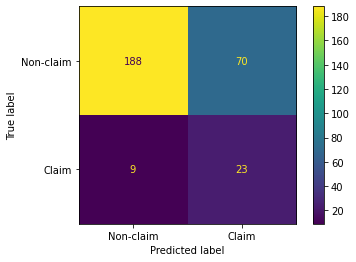

In [710]:
plot_confusion_matrix(clf_xgb, X_test_p, y_test_p, values_format='d', 
                      display_labels=['Non-claim', 'Claim'])

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:14:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight:  {'Full_GGTP': 4, 'LeaderLinePct': 5, 'ModelToActualRto': 4, 'SubClass_FUND_MANAGERS': 2, 'Full_GrossGrossModelPrice': 5, 'RARC': 2, 'Ded_100Pct_USD': 2, 'BrokerUltimateName_R_K_HARRISON': 1, 'BrokerUltimateName_WILLIS': 1, 'Territory_UNITED_KINGDOM': 2, 'StatsMinorClassCode_DP': 1, 'BrokerFeePct': 3, 'BrokerUltimateName_MARSH': 1, 'Limit_100Pct_USD': 8, 'PricingStrength': 1, 'Territory_SWITZERLAND': 1, 'Territory_USA': 1, 'Territory_FINLAND': 1, 'PlacingBasis_Re': 1, 'PLR': 2, 'BrokerUltimateName_MILLER_INSURANCE_SERVICES': 1, 'BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.': 1, 'LeaderStatus_LEAD': 1}
gain:  {'Full_GGTP': 176.03920573075, 'LeaderLinePct': 45.012325249999996, 'ModelToActualRto': 27.505985367500003, 'SubClass_FUND_M

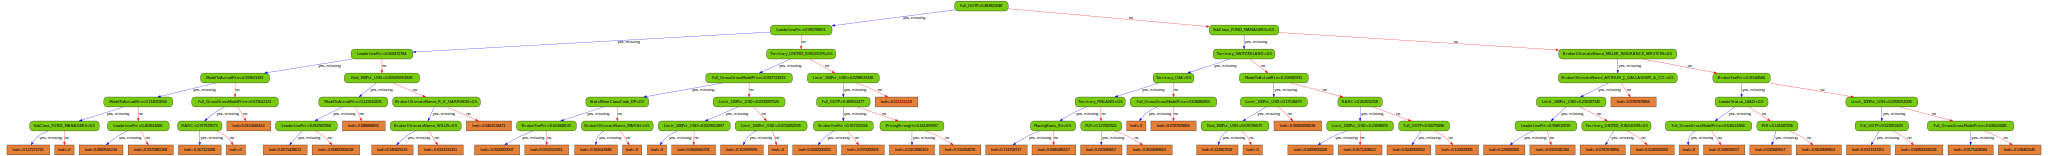

In [711]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                         gamma=0,
                          learning_rate=0.1,
                          max_depth=6,
                          reg_lambda=5,
                          scale_pos_weight=2,
                           seed=42,
                           n_estimators=1)
clf_xgb.fit(X_train_sm_p, y_train_sm_p)
bst=clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)


#### Excess business

In [712]:
# param_grid ={
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.1, 1.0],
#     'reg_lambda': [1.0, 5.0, 10.0],
#     'scale_pos_weight' : [1, 2, 3]
# }

# # AUC since data is imbalance
# # Choose only 90% random subset of the data and for each tree, choose only 50% of the columns to
# # improve the speed and prevent overfitting
# optimal_params = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42, 
#                                                 subsample=0.9, colsample_bytree=0.5),
#                              param_grid=param_grid,
#                               scoring='roc_auc',
#                              verbose=2,
# #                               n_jobs=10,
#                              cv=3)

# optimal_params.fit(X_train_sm_e, y_train_sm_e, verbose=False, early_stopping_rounds=10, 
#             eval_metric='aucpr', eval_set=[(X_test_e, y_test_e)])

In [713]:
# print(optimal_params.best_params_)

In [714]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=1,
                          learning_rate=0.1,
                          max_depth=6,
                          reg_lambda=1,
                          scale_pos_weight=3,
                           seed=42,
                           subsample=0.9, 
                            colsample_bytree=0.5
                           )
clf_xgb.fit(X_train_sm_e, y_train_sm_e, verbose=True, early_stopping_rounds=10, 
            eval_metric='aucpr', eval_set=[(X_test_e, y_test_e)])

[0]	validation_0-aucpr:0.57491
[1]	validation_0-aucpr:0.61793
[2]	validation_0-aucpr:0.68186
[3]	validation_0-aucpr:0.69480


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[4]	validation_0-aucpr:0.67969
[5]	validation_0-aucpr:0.68100
[6]	validation_0-aucpr:0.72001
[7]	validation_0-aucpr:0.72016
[8]	validation_0-aucpr:0.72012
[9]	validation_0-aucpr:0.74391
[10]	validation_0-aucpr:0.73564
[11]	validation_0-aucpr:0.74289
[12]	validation_0-aucpr:0.73681
[13]	validation_0-aucpr:0.74054
[14]	validation_0-aucpr:0.74201
[15]	validation_0-aucpr:0.72726
[16]	validation_0-aucpr:0.73550
[17]	validation_0-aucpr:0.75784
[18]	validation_0-aucpr:0.75630
[19]	validation_0-aucpr:0.75559
[20]	validation_0-aucpr:0.75776
[21]	validation_0-aucpr:0.75761
[22]	validation_0-aucpr:0.75639
[23]	validation_0-aucpr:0.76121
[24]	validation_0-aucpr:0.76170
[25]	validation_0-aucpr:0.76442
[26]	validation_0-aucpr:0.77920
[27]	validation_0-aucpr:0.78054
[28]	validation_0-aucpr:0.78111
[29]	validation_0-aucpr:0.77783
[30]	validation_0-aucpr:0.77433
[31]	validation_0-aucpr:0.77220
[32]	validation_0-aucpr:0.77927
[33]	validation_0-aucpr:0.78994
[34]	validation_0-aucpr:0.79179
[35]	validatio

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [715]:
print('Best score:', clf_xgb.best_score)
print('Best iteration:', clf_xgb.best_iteration)

Best score: 0.820305
Best iteration: 92


In [716]:
# make predictions for test data
y_pred = clf_xgb.predict(X_test_e)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test_e, predictions)
report = classification_report(y_test_e, predictions)
roc_auc = roc_auc_score(y_test_e, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC:", roc_auc)
print(report)

Accuracy: 82.20%
ROC AUC: 0.8210405946255004
              precision    recall  f1-score   support

         0.0       0.90      0.82      0.86       159
         1.0       0.69      0.82      0.75        77

    accuracy                           0.82       236
   macro avg       0.80      0.82      0.81       236
weighted avg       0.83      0.82      0.83       236



/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ROC AUC: 0.8914481744670424
Precision-Recall AUC: 0.8202793202444935


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


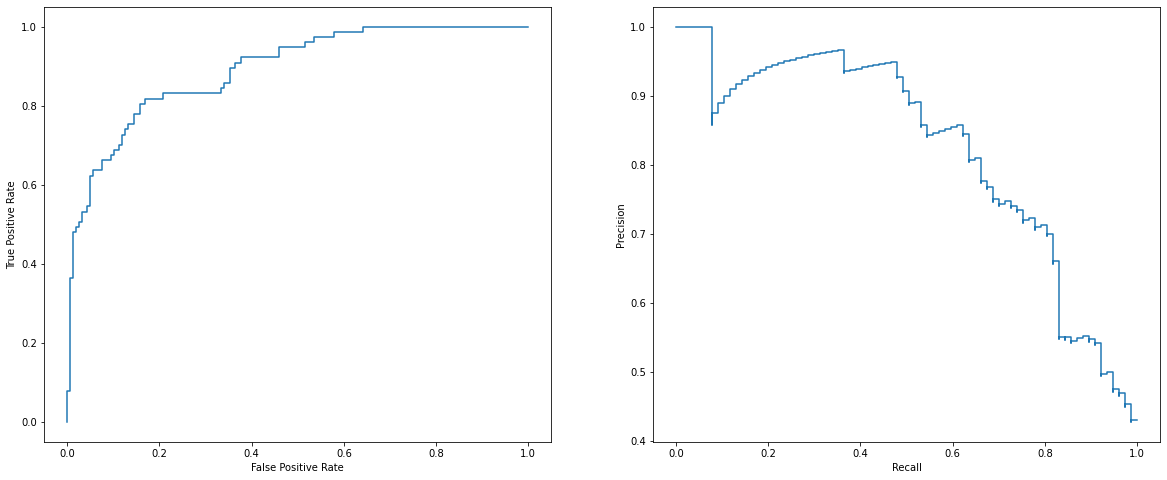

In [717]:
y_prob = clf_xgb.predict_proba(X_test_e)
probabilities = y_prob[:,1]

fpr_sm_e, tpr_sm_e, _ = roc_curve(y_test_e, probabilities)
roc_display_sm_e = RocCurveDisplay(fpr=fpr_sm_e, tpr=tpr_sm_e)
roc_auc_sm_e = auc(fpr_sm_e, tpr_sm_e)

prec_sm_e, recall_sm_e, _ = precision_recall_curve(y_test_e, probabilities)
pr_auc_sm_e = auc(recall_sm_e, prec_sm_e)
pr_display_sm_e = PrecisionRecallDisplay(precision=prec_sm_e, recall=recall_sm_e)

print('ROC AUC:', roc_auc_sm_e)
print('Precision-Recall AUC:', pr_auc_sm_e)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

roc_display_sm_e.plot(ax=ax1)
pr_display_sm_e.plot(ax=ax2)
plt.show()

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


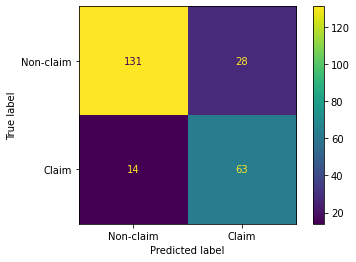

In [718]:
plot_confusion_matrix(clf_xgb, X_test_e, y_test_e, values_format='d', 
                      display_labels=['Non-claim', 'Claim'])

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:14:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight:  {'Full_GGTP': 2, 'Limit_100Pct_USD': 5, 'RARC': 2, 'PLR': 3, 'PLR_band_Lower_quantile': 1, 'ModelToActualRto': 3, 'Ded_100Pct_USD': 2, 'LeaderLinePct': 2, 'SubClass_FUND_MANAGERS': 2, 'Territory_USA': 1, 'Territory_SWITZERLAND': 1, 'Territory_FINLAND': 1, 'BrokerUltimateName_MILLER_INSURANCE_SERVICES': 1, 'BrokerUltimateName_ARTHUR_J._GALLAGHER_&_CO.': 1, 'BrokerUltimateName_JLT': 1, 'BrokerFeePct': 1, 'LeaderStatus_LEAD': 1, 'Full_GrossGrossModelPrice': 2}
gain:  {'Full_GGTP': 357.33991695, 'Limit_100Pct_USD': 33.345361152, 'RARC': 9.271058065, 'PLR': 37.3693733, 'PLR_band_Lower_quantile': 94.1262741, 'ModelToActualRto': 30.354913536666672, 'Ded_100Pct_USD': 27.732673650000002, 'LeaderLinePct': 49.86421585, 'SubClass_FUND_MANAGE

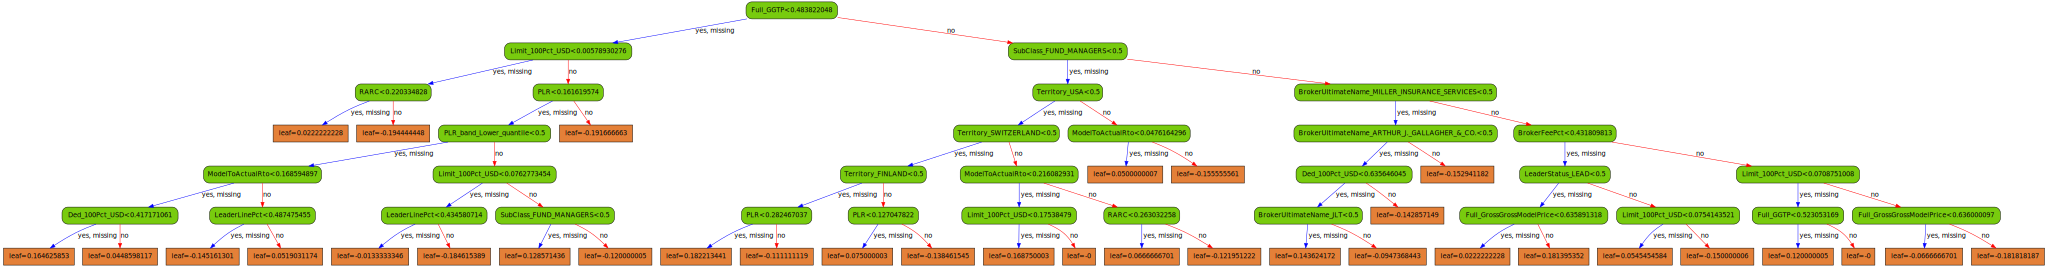

In [719]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=1,
                          learning_rate=0.1,
                          max_depth=6,
                          reg_lambda=1,
                          scale_pos_weight=3,
                           seed=42,
                           n_estimators=1)
clf_xgb.fit(X_train_sm_p, y_train_sm_p)
bst=clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)


## GAN

In [720]:
def generator_network(x, data_dim, base_n_count): 
    x = layers.Dense(base_n_count, activation='relu')(x)
    x = layers.Dense(base_n_count*2, activation='relu')(x)
    x = layers.Dense(base_n_count*4, activation='relu')(x)
    x = layers.Dense(data_dim)(x)    
    return x

def discriminator_network(x, data_dim, base_n_count):
    x = layers.Dense(base_n_count*4, activation='relu')(x)
    # x = layers.Dropout(0.1)(x)
    x = layers.Dense(base_n_count*2, activation='relu')(x)
    # x = layers.Dropout(0.1)(x)
    x = layers.Dense(base_n_count, activation='relu')(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    # x = layers.Dense(1)(x)
    return x

In [721]:
def generator_network_w_label(x, labels, data_dim, label_dim, base_n_count): 
    x = layers.concatenate([x,labels])
    x = layers.Dense(base_n_count*1, activation='relu')(x) # 1
    x = layers.Dense(base_n_count*2, activation='relu')(x) # 2
    x = layers.Dense(base_n_count*4, activation='relu')(x)
    # x = layers.Dense(base_n_count*4, activation='relu')(x) # extra
    # x = layers.Dense(base_n_count*4, activation='relu')(x) # extra
    x = layers.Dense(data_dim)(x)    
    x = layers.concatenate([x,labels])
    return x

In [722]:
def get_data_batch(train, batch_size, seed=42):
    # # random sampling - some samples will have excessively low or high sampling, but easy to implement
    # np.random.seed(seed)
    # x = train.loc[ np.random.choice(train.index, batch_size) ].values
    
    # iterate through shuffled indices, so every sample gets covered evenly
    start_i = (batch_size * seed) % len(train)
    stop_i = start_i + batch_size
    shuffle_seed = (batch_size * seed) // len(train)
    np.random.seed(shuffle_seed)
    train_ix = np.random.choice( list(train.index), replace=False, size=len(train) ) # wasteful to shuffle every time
    train_ix = list(train_ix) + list(train_ix) # duplicate to cover ranges past the end of the set
    x = train.loc[ train_ix[ start_i: stop_i ] ].values
    
    return np.reshape(x, (batch_size, -1) )

In [723]:
def CheckAccuracy( x, g_z, data_cols, label_cols=[], seed=42, with_class=False, data_dim=2 ):

    # Slightly slower code to create dataframes to feed into the xgboost dmatrix formats
    
    # real_samples = pd.DataFrame(x, columns=data_cols+label_cols)
    # gen_samples = pd.DataFrame(g_z, columns=data_cols+label_cols)
    # real_samples['syn_label'] = 0
    # gen_samples['syn_label'] = 1
    
    # training_fraction = 0.5
    # n_real, n_gen = int(len(real_samples)*training_fraction), int(len(gen_samples)*training_fraction)
    # train_df = pd.concat([real_samples[:n_real],gen_samples[:n_gen]],axis=0)
    # test_df = pd.concat([real_samples[n_real:],gen_samples[n_gen:]],axis=0)

    # X_col = test_df.columns[:-1]
    # y_col = test_df.columns[-1]
    # dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
    # dtest = xgb.DMatrix(test_df[X_col], feature_names=X_col)
    # y_true = test_df['syn_label']

    dtrain = np.vstack( [ x[:int(len(x)/2)], g_z[:int(len(g_z)/2)] ] ) # Use half of each real and generated set for training
    dlabels = np.hstack( [ np.zeros(int(len(x)/2)), np.ones(int(len(g_z)/2)) ] ) # synthetic labels
    dtest = np.vstack( [ x[int(len(x)/2):], g_z[int(len(g_z)/2):] ] ) # Use the other half of each set for testing
    y_true = dlabels # Labels for test samples will be the same as the labels for training samples, assuming even batch sizes
    
    dtrain = xgb.DMatrix(dtrain, dlabels, feature_names=data_cols)
    dtest = xgb.DMatrix(dtest, feature_names=data_cols)
    
    xgb_params = {
        # 'tree_method': 'hist', # for faster evaluation
        'max_depth': 6,
        'objective': 'binary:logistic',
        'random_state': 0,
        'eval_metric': 'aucpr',
#         'gamma' : 0,
#         'learning_rate': 0.1,
#         'reg_lambda' : 10,
        'scale_pos_weight' : 1 # allows for balanced or unbalanced classes 
        }
    xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=100) # limit to ten rounds for faster evaluation

    y_pred = xgb_test.predict(dtest)

    y_pred = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_true, y_pred)
    # return '{:.2f}'.format(SimpleAccuracy(y_pred, y_true)) # assumes balanced real and generated datasets
    return accuracy # assumes balanced real and generated datasets

In [724]:
def CheckAccuracyConditional( x, g_z, data_cols, label_cols=[], seed=42, with_class=False, data_dim=2 ):

    # Slightly slower code to create dataframes to feed into the xgboost dmatrix formats
    
    # real_samples = pd.DataFrame(x, columns=data_cols+label_cols)
    # gen_samples = pd.DataFrame(g_z, columns=data_cols+label_cols)
    # real_samples['syn_label'] = 0
    # gen_samples['syn_label'] = 1
    
    # training_fraction = 0.5
    # n_real, n_gen = int(len(real_samples)*training_fraction), int(len(gen_samples)*training_fraction)
    # train_df = pd.concat([real_samples[:n_real],gen_samples[:n_gen]],axis=0)
    # test_df = pd.concat([real_samples[n_real:],gen_samples[n_gen:]],axis=0)

    # X_col = test_df.columns[:-1]
    # y_col = test_df.columns[-1]
    # dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
    # dtest = xgb.DMatrix(test_df[X_col], feature_names=X_col)
    # y_true = test_df['syn_label']

    dtrain = np.vstack( [ x[:int(len(x)/2)], g_z[:int(len(g_z)/2)] ] ) # Use half of each real and generated set for training
    dlabels = np.hstack( [ np.zeros(int(len(x)/2)), np.ones(int(len(g_z)/2)) ] ) # synthetic labels
    dtest = np.vstack( [ x[int(len(x)/2):], g_z[int(len(g_z)/2):] ] ) # Use the other half of each set for testing
    y_true = dlabels # Labels for test samples will be the same as the labels for training samples, assuming even batch sizes
    
    dtrain = xgb.DMatrix(dtrain, dlabels, feature_names=data_cols_w_class)
    dtest = xgb.DMatrix(dtest, feature_names=data_cols_w_class)
    
    xgb_params = {
        # 'tree_method': 'hist', # for faster evaluation
        'max_depth': 6,
        'objective': 'binary:logistic',
        'random_state': 0,
        'eval_metric': 'aucpr',
#         'gamma' : 0,
#         'learning_rate': 0.1,
#         'reg_lambda' : 10,
        'scale_pos_weight' : 1 # allows for balanced or unbalanced classes 
        }
    xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=100) # limit to ten rounds for faster evaluation

    y_pred = xgb_test.predict(dtest)

    y_pred = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_true, y_pred)
    # return '{:.2f}'.format(SimpleAccuracy(y_pred, y_true)) # assumes balanced real and generated datasets
    return accuracy # assumes balanced real and generated datasets

#### Primary Business

In [725]:
X_encoded_w_classes_p = X_train_p.copy()
X_encoded_w_classes_p['Class'] = y_train_p
X_encoded_w_classes_p.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,BrokerUltimateName_RFIB_GROUP_LIMITED,BrokerUltimateName_R_K_HARRISON,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,BrokerUltimateName_WINDSOR_INSURANCE_BROKERS_LTD,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile,Class
117,0.143687,0.592525,1.000000,0.667851,0.147269,0.285714,0.733587,0.135368,0.220804,0.269055,...,0,0,0,0,0,0,0,1,0,0.0
1114,0.016369,0.417329,0.263158,0.523036,0.124463,0.276786,0.581446,0.198327,0.662413,0.163281,...,0,0,0,0,0,1,0,0,0,0.0
329,0.070934,0.483757,1.000000,0.489530,0.141073,0.285714,0.629164,0.161298,0.607212,0.183989,...,0,0,0,0,0,0,0,1,0,0.0
75,0.005456,0.334266,1.000000,0.667851,0.103390,0.419643,0.465869,0.235901,0.220804,0.068619,...,0,0,0,0,0,0,1,0,0,0.0
1132,0.012732,0.358926,1.000000,0.000000,0.066855,0.245536,0.539493,0.375409,0.662413,0.106699,...,0,1,0,0,0,0,1,0,0,0.0


In [726]:
# Finding rows with class '1'
train_p = X_encoded_w_classes_p.loc[ X_encoded_w_classes_p.Class == 1 ].copy()
claim_w_classes_p = train_p.copy()
claim_w_classes_p['Class'] = y_train_p
# claim_w_classes_p.head()
train_p = claim_w_classes_p.copy().reset_index(drop=True)
# train_p.head()

label_cols = ['Class']
data_cols = [ i for i in train_p.columns if i not in label_cols ]
train_no_label_p = train_p.copy()
train_no_label_p.drop('Class', axis=1, inplace=True)
# train_no_label_p = train_p[ data_cols ]
train_no_label_p.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,BrokerUltimateName_PRICE_FORBES_&PARTNERS_LIMITED,BrokerUltimateName_RFIB_GROUP_LIMITED,BrokerUltimateName_R_K_HARRISON,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,BrokerUltimateName_WINDSOR_INSURANCE_BROKERS_LTD,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile
0,0.180063,0.644623,0.368421,0.583595,0.135876,0.285714,0.621752,0.177593,0.220804,0.030962,...,0,0,0,0,0,0,1,0,0,0
1,0.043128,0.558817,1.000000,0.552863,0.133785,0.285714,0.686212,0.166015,0.496809,0.187871,...,0,0,0,0,0,0,1,0,0,0
2,0.023227,0.411010,0.473684,0.471489,0.130188,0.392857,0.571091,0.167652,0.618252,0.167896,...,0,0,0,0,0,1,1,0,0,0
3,0.043128,0.400612,0.684211,0.000000,0.135198,0.285714,0.531897,0.163792,0.552010,0.113608,...,0,0,0,0,0,0,1,0,0,0
4,0.020654,0.486240,1.000000,0.533263,0.146441,0.955357,0.557473,0.161298,0.441608,0.069642,...,0,0,0,0,0,0,0,0,1,0


In [727]:
# rand_dim = len(train_no_label_p.columns) # 32 # needs to be ~data_dim
# base_n_count = 128 # 128

# nb_steps = 10000 + 1 # 50000 # Add one for logging of the last interval
# batch_size = 128 # 64

# k_d = 1  # number of critic network updates per adversarial training step
# k_g = 1  # number of generator network updates per adversarial training step
# critic_pre_train_steps = 100 # 100  # number of steps to pre-train the critic before starting adversarial training
# log_interval = 100 # 100  # interval (in steps) at which to log loss summaries and save plots of image samples to disc
# learning_rate = 5e-4 # 5e-5
# # data_dir = 'cache/'
# # generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None
# # show = True 

In [728]:
# with_class=False
# data_cols = train_no_label_p.columns
# data_dim = len(data_cols)
# print('data_dim: ', data_dim)
# print('data_cols: ', data_cols)
    
# label_dim = 0

# K.set_learning_phase(1) # 1 = train

# cache_prefix = 'GAN'

# generator_input_tensor = layers.Input(shape=(rand_dim, ))
# generated_image_tensor = generator_network(generator_input_tensor, data_dim, base_n_count)

# generated_or_real_image_tensor = layers.Input(shape=(data_dim,))
    
# discriminator_output = discriminator_network(generated_or_real_image_tensor, data_dim, base_n_count)

# generator_model = models.Model(inputs=[generator_input_tensor], outputs=[generated_image_tensor], name='generator')
# discriminator_model = models.Model(inputs=[generated_or_real_image_tensor],
#                                    outputs=[discriminator_output],
#                                    name='discriminator')

# combined_output = discriminator_model(generator_model(generator_input_tensor))
# combined_model = models.Model(inputs=[generator_input_tensor], outputs=[combined_output], name='combined')

In [729]:
# combined_loss, disc_loss_generated, disc_loss_real, xgb_losses = [], [], [], []

In [730]:
# adam = optimizers.Adam(lr=learning_rate, beta_1=0.5, beta_2=0.9)

# generator_model.compile(optimizer=adam, loss='binary_crossentropy')
# discriminator_model.compile(optimizer=adam, loss='binary_crossentropy')
# discriminator_model.trainable = False
# combined_model.compile(optimizer=adam, loss='binary_crossentropy')

# # print(generator_model.summary())
# # print(discriminator_model.summary())
# # print(combined_model.summary())

In [731]:
# for i in range(0, nb_steps):
#     K.set_learning_phase(1)
    
#     # train the discriminator
#     for j in range(k_d):
#         np.random.seed(i+j)
#         z = np.random.normal(size=(batch_size, rand_dim))
#         x = get_data_batch(train_no_label_p, batch_size, seed=i+j)
            
#         if with_class:
#             labels = x[:,-label_dim:]
#             g_z = generator_model.predict([z, labels])
#         else:
#             g_z = generator_model.predict(z)
# #             x = np.vstack([x,g_z]) # code to train the discriminator on real and generated data at the same time, but you have to run network again for separate losses
# #             classes = np.hstack([np.zeros(batch_size),np.ones(batch_size)])
# #             d_l_r = discriminator_model.train_on_batch(x, classes)
            
#         d_l_r = discriminator_model.train_on_batch(x, np.random.uniform(low=0.999, high=1.0, size=batch_size)) # 0.7, 1.2 # GANs need noise to prevent loss going to zero
#         d_l_g = discriminator_model.train_on_batch(g_z, np.random.uniform(low=0.0, high=0.001, size=batch_size)) # 0.0, 0.3 # GANs need noise to prevent loss going to zero
#             # d_l_r = discriminator_model.train_on_batch(x, np.ones(batch_size)) # without noise
#             # d_l_g = discriminator_model.train_on_batch(g_z, np.zeros(batch_size)) # without noise
#     disc_loss_real.append(d_l_r)
#     disc_loss_generated.append(d_l_g)
    
#     # train the generator
#     for j in range(k_g):
#         np.random.seed(i+j)
#         z = np.random.normal(size=(batch_size, rand_dim))
#         if with_class:
#             # loss = combined_model.train_on_batch([z, labels], np.ones(batch_size)) # without noise
#             loss = combined_model.train_on_batch([z, labels], np.random.uniform(low=0.999, high=1.0, size=batch_size)) # 0.7, 1.2 # GANs need noise to prevent loss going to zero
#         else:
#             # loss = combined_model.train_on_batch(z, np.ones(batch_size)) # without noise
#             loss = combined_model.train_on_batch(z, np.random.uniform(low=0.999, high=1.0, size=batch_size)) # 0.7, 1.2 # GANs need noise to prevent loss going to zero
#     combined_loss.append(loss)
    
#     # Determine xgb loss each step, after training generator and discriminator
#     if not i % 10: # 2x faster than testing each step...
#         K.set_learning_phase(0) # 0 = test
#         test_size = np.sum(train_p['Class']==1) # test using all of the actual fraud data 
#         x = get_data_batch(train_no_label_p, test_size, seed=i)
#         z = np.random.normal(size=(test_size, rand_dim))
#         if with_class:
#             labels = x[:,-label_dim:]
#             g_z = generator_model.predict([z, labels])
#         else:
#             g_z = generator_model.predict(z)
#         xgb_loss = CheckAccuracy( x, g_z, data_cols, label_cols, seed=42, with_class=with_class, data_dim=data_dim )
#         xgb_losses = np.append(xgb_losses, xgb_loss)
    
#     # Saving weights and plotting images
#     if not i % log_interval:
#         print('Step: {} of {}.'.format(i, nb_steps))
#         K.set_learning_phase(0) # 0 = test
                        
#         # loss summaries      
#         print( 'Losses: G, D Gen, D Real, Xgb: {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(combined_loss[-1], disc_loss_generated[-1], disc_loss_real[-1], xgb_losses[-1]) )
#         print( 'D Real - D Gen: {:.4f}'.format(disc_loss_real[-1]-disc_loss_generated[-1]) )    

In [732]:
# fig = plt.figure(figsize=(20,5))
# ax1 = fig.add_subplot(1, 3, 1)
# ax2 = fig.add_subplot(1, 3, 2)
# ax3 = fig.add_subplot(1, 3, 3)

# ax1.plot(combined_loss)
# ax1.set_title('Generator Loss')
# ax1.set_xlabel('Step')
# ax1.set_ylabel('Loss')

# ax2.plot(disc_loss_generated)
# ax2.set_title('Discriminator Loss of Generated Data')
# ax2.set_xlabel('Step')
# ax2.set_ylabel('Loss')

# ax3.plot(disc_loss_real)
# ax3.set_title('Discriminator Loss of Real Data')
# ax3.set_xlabel('Step')
# ax3.set_ylabel('Loss')

# plt.show()

In [733]:
# # Predicting the generated data
# samples = len(X_train_res_p) - len(X_train_p)
# new_z = np.random.normal(size=(samples,rand_dim))
# new_g_z = generator_model.predict(new_z)

In [734]:
# gan_samples_p = pd.DataFrame(new_g_z, columns=data_cols)
# gan_samples_p.to_csv('dandofi_gan_primary.csv',index=False)

In [735]:
gan_samples_p = pd.read_csv('../input/project/dandofi_gan_primary.csv')
gan_samples_p.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,BrokerUltimateName_PRICE_FORBES_&PARTNERS_LIMITED,BrokerUltimateName_RFIB_GROUP_LIMITED,BrokerUltimateName_R_K_HARRISON,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,BrokerUltimateName_WINDSOR_INSURANCE_BROKERS_LTD,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile
0,0.035488,0.391497,0.994440,0.555099,0.139663,0.286189,0.571821,0.162459,0.512232,0.214531,...,0.000901,0.000248,0.001824,-0.000073,-0.000381,-0.002623,0.001759,-0.001072,0.990877,-0.000240
1,0.033874,0.491109,0.473781,0.608826,0.144527,0.475420,0.623092,0.145549,-0.001100,0.165022,...,-0.000814,0.000022,0.000185,0.000196,-0.001529,-0.001154,0.002780,-0.001008,0.986335,-0.000873
2,0.034499,0.394033,0.932588,0.543112,0.136045,0.283315,0.561406,0.157625,0.480988,0.206784,...,0.000748,-0.000158,0.001410,0.000061,-0.000933,-0.002649,0.001865,-0.001401,0.965154,-0.000036
3,0.071062,0.510588,0.443121,0.504481,0.151227,0.290610,0.648582,0.146719,0.452622,0.188584,...,0.000115,0.000607,-0.000039,0.001155,-0.003231,-0.003055,0.002470,-0.001714,1.004814,-0.000568
4,0.034793,0.486063,0.463291,0.598059,0.140668,0.466319,0.619723,0.145952,-0.001506,0.163170,...,-0.002012,0.000164,0.000533,0.001039,-0.001043,-0.000999,0.002493,-0.001541,0.976740,-0.001500


In [736]:
X_gan_p = X_train_p.append(gan_samples_p, ignore_index = True)
X_gan_p.describe()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,BrokerUltimateName_PRICE_FORBES_&PARTNERS_LIMITED,BrokerUltimateName_RFIB_GROUP_LIMITED,BrokerUltimateName_R_K_HARRISON,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,BrokerUltimateName_WINDSOR_INSURANCE_BROKERS_LTD,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile
count,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,...,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000
mean,0.067484,0.464414,0.613751,0.476954,0.143577,0.312131,0.613963,0.168446,0.406129,0.193762,...,0.004185,0.005479,0.024064,0.021083,0.058104,0.000978,0.139446,0.128794,0.577091,0.154356
std,0.077733,0.093623,0.285728,0.194841,0.039292,0.075439,0.075203,0.072446,0.210668,0.085527,...,0.065921,0.072821,0.152227,0.142827,0.236141,0.044049,0.345227,0.335899,0.494058,0.361652
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.001903,0.000000,...,-0.003117,-0.009480,-0.000220,-0.004127,-0.008978,-0.003817,-0.006483,-0.002847,0.000000,-0.003210
25%,0.034109,0.396634,0.442913,0.495093,0.134143,0.285714,0.569627,0.145586,0.432913,0.162877,...,-0.000101,0.000000,0.000000,0.000000,-0.001972,-0.002207,0.000000,-0.001059,0.000000,-0.000380
50%,0.036571,0.480825,0.473684,0.530653,0.142811,0.285714,0.620362,0.154574,0.460949,0.188504,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000420,0.000000,0.974698,0.000000
75%,0.072955,0.512477,1.000000,0.573488,0.151845,0.300005,0.649832,0.168997,0.523397,0.216538,...,0.000000,0.000204,0.000349,0.000864,0.000000,0.000000,0.002831,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.047062,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.125985,1.000000


In [737]:
X_train_p.describe()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,BrokerUltimateName_PRICE_FORBES_&PARTNERS_LIMITED,BrokerUltimateName_RFIB_GROUP_LIMITED,BrokerUltimateName_R_K_HARRISON,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,BrokerUltimateName_WINDSOR_INSURANCE_BROKERS_LTD,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile
count,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,...,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.00000,1158.000000,1158.000000
mean,0.082848,0.462421,0.592188,0.416114,0.141866,0.286037,0.610659,0.180815,0.458424,0.194989,...,0.007772,0.009499,0.042314,0.037133,0.105354,0.003454,0.246978,0.23057,0.246978,0.275475
std,0.099916,0.115641,0.310475,0.240415,0.052049,0.054713,0.095271,0.094588,0.189464,0.112795,...,0.087854,0.097041,0.201392,0.189169,0.307142,0.058696,0.431440,0.42138,0.431440,0.446946
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.020007,0.386800,0.336842,0.427066,0.120527,0.285714,0.549018,0.137357,0.441608,0.124368,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,0.060989,0.457086,0.473684,0.499757,0.137486,0.285714,0.609866,0.162395,0.496810,0.178387,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,0.107310,0.529260,1.000000,0.556543,0.157269,0.285714,0.662761,0.192947,0.563051,0.239935,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [738]:
ones = np.ones((len(gan_samples_p),))
one = pd.Series(ones)
y_gan_p = y_train_p.append(one, ignore_index=True)
# y_gan_p

#### Excess Business

In [739]:
X_encoded_w_classes_e = X_train_e.copy()
X_encoded_w_classes_e['Class'] = y_train_e
X_encoded_w_classes_e.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,...,BrokerUltimateName_JLT,BrokerUltimateName_LOCKTON,BrokerUltimateName_LONMAR_GLOBAL_RISKS_LIMITED,BrokerUltimateName_MARSH,BrokerUltimateName_R_K_HARRISON,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile,Class
1173,0.018223,0.411304,0.117671,0.011355,0.000000,0.102076,0.202335,0.004201,0.222524,0.714284,...,0,0,0,0,0,0,1,0,0,0.0
1021,0.015502,0.324901,0.241535,0.013098,0.000306,0.108668,0.252918,0.001830,0.208333,0.000000,...,0,0,0,0,1,0,1,0,0,0.0
907,0.044363,0.637673,0.035095,0.046947,0.027240,0.132911,0.408560,0.051429,0.166666,0.285714,...,0,1,0,0,0,1,0,0,0,0.0
1147,0.028986,0.425712,0.117671,0.005765,0.000681,0.189095,0.214008,0.005968,0.128996,0.535713,...,1,0,0,0,0,0,0,0,1,0.0
417,0.378246,0.686888,0.018868,0.145264,0.000000,0.174166,0.214008,0.163374,0.129454,0.100000,...,0,0,0,0,0,0,0,0,1,1.0


In [740]:
# Finding rows with class '1'
train_e = X_encoded_w_classes_e.loc[ X_encoded_w_classes_e.Class == 1 ].copy()
claim_w_classes_e = train_e.copy()
claim_w_classes_e['Class'] = y_train_e
# claim_w_classes_e.head()
train_e = claim_w_classes_e.copy().reset_index(drop=True)
# train_e.head()

label_cols = ['Class']
data_cols = [ i for i in train_e.columns if i not in label_cols ]
train_no_label_e = train_e.copy()
train_no_label_e.drop('Class', axis=1, inplace=True)
# train_no_label_e = train_e[ data_cols ]
train_no_label_e.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,...,BrokerUltimateName_HOWDEN,BrokerUltimateName_JLT,BrokerUltimateName_LOCKTON,BrokerUltimateName_LONMAR_GLOBAL_RISKS_LIMITED,BrokerUltimateName_MARSH,BrokerUltimateName_R_K_HARRISON,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile
0,0.378246,0.686888,0.018868,0.145264,0.0,0.174166,0.214008,0.163374,0.129454,0.100000,...,0,0,0,0,0,0,0,0,0,1
1,0.075119,0.764804,0.241535,0.058713,0.0,0.127382,0.233463,0.158930,0.191394,0.342857,...,0,0,0,0,0,0,1,0,0,0
2,0.050514,0.448737,0.066668,0.005765,0.0,0.133804,0.214008,0.007818,0.193402,0.785714,...,1,0,0,0,0,0,1,0,0,0
3,0.028986,0.516941,0.043352,0.352865,0.0,0.124617,0.214008,0.011594,0.192609,0.288677,...,0,0,0,0,1,0,1,0,0,0
4,0.075119,0.589562,0.043352,0.029298,0.0,0.121215,0.194553,0.008149,0.185013,0.285714,...,0,0,0,0,0,0,1,0,0,0


In [741]:
# rand_dim = len(train_no_label_e.columns) # 32 # needs to be ~data_dim
# base_n_count = 128 # 128

# nb_steps = 10000 + 1 # 50000 # Add one for logging of the last interval
# batch_size = 128 # 64

# k_d = 1  # number of critic network updates per adversarial training step
# k_g = 1  # number of generator network updates per adversarial training step
# critic_pre_train_steps = 100 # 100  # number of steps to pre-train the critic before starting adversarial training
# log_interval = 100 # 100  # interval (in steps) at which to log loss summaries and save plots of image samples to disc
# learning_rate = 5e-4 # 5e-5
# # data_dir = 'cache/'
# # generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None
# # show = True 

In [742]:
# with_class=False
# data_cols = train_no_label_e.columns
# data_dim = len(data_cols)
# print('data_dim: ', data_dim)
# print('data_cols: ', data_cols)
    
# label_dim = 0

# K.set_learning_phase(1) # 1 = train

# cache_prefix = 'GAN'

# generator_input_tensor = layers.Input(shape=(rand_dim, ))
# generated_image_tensor = generator_network(generator_input_tensor, data_dim, base_n_count)

# generated_or_real_image_tensor = layers.Input(shape=(data_dim,))
    
# discriminator_output = discriminator_network(generated_or_real_image_tensor, data_dim, base_n_count)

# generator_model = models.Model(inputs=[generator_input_tensor], outputs=[generated_image_tensor], name='generator')
# discriminator_model = models.Model(inputs=[generated_or_real_image_tensor],
#                                    outputs=[discriminator_output],
#                                    name='discriminator')

# combined_output = discriminator_model(generator_model(generator_input_tensor))
# combined_model = models.Model(inputs=[generator_input_tensor], outputs=[combined_output], name='combined')

In [743]:
# combined_loss, disc_loss_generated, disc_loss_real, xgb_losses = [], [], [], []

In [744]:
# adam = optimizers.Adam(lr=learning_rate, beta_1=0.5, beta_2=0.9)

# generator_model.compile(optimizer=adam, loss='binary_crossentropy')
# discriminator_model.compile(optimizer=adam, loss='binary_crossentropy')
# discriminator_model.trainable = False
# combined_model.compile(optimizer=adam, loss='binary_crossentropy')

# # print(generator_model.summary())
# # print(discriminator_model.summary())
# # print(combined_model.summary())

In [745]:
# for i in range(0, nb_steps):
#     K.set_learning_phase(1)
    
#     # train the discriminator
#     for j in range(k_d):
#         np.random.seed(i+j)
#         z = np.random.normal(size=(batch_size, rand_dim))
#         x = get_data_batch(train_no_label_e, batch_size, seed=i+j)
            
#         if with_class:
#             labels = x[:,-label_dim:]
#             g_z = generator_model.predict([z, labels])
#         else:
#             g_z = generator_model.predict(z)
# #             x = np.vstack([x,g_z]) # code to train the discriminator on real and generated data at the same time, but you have to run network again for separate losses
# #             classes = np.hstack([np.zeros(batch_size),np.ones(batch_size)])
# #             d_l_r = discriminator_model.train_on_batch(x, classes)
            
#         d_l_r = discriminator_model.train_on_batch(x, np.random.uniform(low=0.999, high=1.0, size=batch_size)) # 0.7, 1.2 # GANs need noise to prevent loss going to zero
#         d_l_g = discriminator_model.train_on_batch(g_z, np.random.uniform(low=0.0, high=0.001, size=batch_size)) # 0.0, 0.3 # GANs need noise to prevent loss going to zero
#             # d_l_r = discriminator_model.train_on_batch(x, np.ones(batch_size)) # without noise
#             # d_l_g = discriminator_model.train_on_batch(g_z, np.zeros(batch_size)) # without noise
#     disc_loss_real.append(d_l_r)
#     disc_loss_generated.append(d_l_g)
    
#     # train the generator
#     for j in range(k_g):
#         np.random.seed(i+j)
#         z = np.random.normal(size=(batch_size, rand_dim))
#         if with_class:
#             # loss = combined_model.train_on_batch([z, labels], np.ones(batch_size)) # without noise
#             loss = combined_model.train_on_batch([z, labels], np.random.uniform(low=0.999, high=1.0, size=batch_size)) # 0.7, 1.2 # GANs need noise to prevent loss going to zero
#         else:
#             # loss = combined_model.train_on_batch(z, np.ones(batch_size)) # without noise
#             loss = combined_model.train_on_batch(z, np.random.uniform(low=0.999, high=1.0, size=batch_size)) # 0.7, 1.2 # GANs need noise to prevent loss going to zero
#     combined_loss.append(loss)
    
#     # Determine xgb loss each step, after training generator and discriminator
#     if not i % 10: # 2x faster than testing each step...
#         K.set_learning_phase(0) # 0 = test
#         test_size = np.sum(train_e['Class']==1) - 1 # test using all of the actual fraud data - 1
#         x = get_data_batch(train_no_label_e, test_size, seed=i)
#         z = np.random.normal(size=(test_size, rand_dim))
#         if with_class:
#             labels = x[:,-label_dim:]
#             g_z = generator_model.predict([z, labels])
#         else:
#             g_z = generator_model.predict(z)
#         xgb_loss = CheckAccuracy( x, g_z, data_cols, label_cols, seed=42, with_class=with_class, data_dim=data_dim )
#         xgb_losses = np.append(xgb_losses, xgb_loss)
    
#     # Saving weights and plotting images
#     if not i % log_interval:
#         print('Step: {} of {}.'.format(i, nb_steps))
#         K.set_learning_phase(0) # 0 = test
                        
#         # loss summaries      
#         print( 'Losses: G, D Gen, D Real, Xgb: {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(combined_loss[-1], disc_loss_generated[-1], disc_loss_real[-1], xgb_losses[-1]) )
#         print( 'D Real - D Gen: {:.4f}'.format(disc_loss_real[-1]-disc_loss_generated[-1]) )    

In [746]:
# fig = plt.figure(figsize=(20,5))
# ax1 = fig.add_subplot(1, 3, 1)
# ax2 = fig.add_subplot(1, 3, 2)
# ax3 = fig.add_subplot(1, 3, 3)

# ax1.plot(combined_loss)
# ax1.set_title('Generator Loss')
# ax1.set_xlabel('Step')
# ax1.set_ylabel('Loss')

# ax2.plot(disc_loss_generated)
# ax2.set_title('Discriminator Loss of Generated Data')
# ax2.set_xlabel('Step')
# ax2.set_ylabel('Loss')

# ax3.plot(disc_loss_real)
# ax3.set_title('Discriminator Loss of Real Data')
# ax3.set_xlabel('Step')
# ax3.set_ylabel('Loss')

# plt.show()

In [747]:
# # Predicting the generated data
# samples = len(X_train_res_e) - len(X_train_e)
# new_z = np.random.normal(size=(samples,rand_dim))
# new_g_z = generator_model.predict(new_z)

In [748]:
# gan_samples_e = pd.DataFrame(new_g_z, columns=data_cols)
# gan_samples_e.to_csv('dandofi_gan_excess.csv',index=False)

In [749]:
gan_samples_e = pd.read_csv('../input/project/dandofi_gan_excess.csv')
gan_samples_e.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,...,BrokerUltimateName_HOWDEN,BrokerUltimateName_JLT,BrokerUltimateName_LOCKTON,BrokerUltimateName_LONMAR_GLOBAL_RISKS_LIMITED,BrokerUltimateName_MARSH,BrokerUltimateName_R_K_HARRISON,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile
0,0.092719,0.531852,0.038459,0.131209,0.003702,0.331464,0.220052,0.055145,0.036777,0.723362,...,0.001373,0.000147,0.000970,0.000142,0.991400,0.001000,0.000843,0.000412,-0.001386,1.001827
1,0.093035,0.524583,0.042071,0.145483,0.003131,0.552347,0.228089,0.065449,-0.006051,0.727843,...,0.002293,0.001066,0.003276,0.000039,1.009279,0.000160,0.000025,0.000855,-0.000431,1.018163
2,0.095393,0.547547,0.035136,0.100359,0.003916,0.304349,0.227797,0.061250,0.048986,0.736858,...,0.001662,-0.000087,0.001413,0.000737,1.007567,-0.000953,-0.000745,-0.001025,-0.001497,1.018511
3,0.082349,0.510160,0.037701,0.069118,0.003113,0.379800,0.223958,0.059914,0.037751,0.714280,...,0.003137,-0.000514,0.002831,-0.000320,0.987877,-0.000351,0.000677,0.001577,-0.000522,0.999487
4,0.053948,0.495990,0.046728,0.005527,0.003950,0.187599,0.228927,0.056823,0.105060,0.719012,...,0.003695,0.002522,0.001018,0.000653,0.996737,-0.000184,0.000604,0.000789,-0.001250,1.013242


In [750]:
X_gan_e = X_train_e.append(gan_samples_e, ignore_index = True)
X_gan_e.describe()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,...,BrokerUltimateName_HOWDEN,BrokerUltimateName_JLT,BrokerUltimateName_LOCKTON,BrokerUltimateName_LONMAR_GLOBAL_RISKS_LIMITED,BrokerUltimateName_MARSH,BrokerUltimateName_R_K_HARRISON,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile
count,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,...,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000
mean,0.096317,0.537271,0.069327,0.095315,0.016029,0.197601,0.216663,0.058640,0.151401,0.443008,...,0.045645,0.041976,0.040831,0.003247,0.472859,0.041063,0.185737,0.185090,0.177563,0.453724
std,0.083937,0.104386,0.057926,0.120668,0.070428,0.117483,0.039533,0.086239,0.105863,0.300620,...,0.207306,0.200335,0.196594,0.056140,0.498428,0.198543,0.388903,0.388195,0.382508,0.500017
min,0.001686,0.000000,0.000000,0.000000,-0.000461,0.013950,0.097276,0.000000,-0.006051,0.000000,...,0.000000,-0.002595,0.000000,-0.001122,0.000000,-0.002701,-0.001281,-0.001071,-0.001702,0.000000
25%,0.054001,0.487118,0.037701,0.018508,0.000000,0.129359,0.214008,0.011962,0.093072,0.107143,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.079372,0.522825,0.043352,0.060704,0.001362,0.154357,0.214008,0.046138,0.152566,0.571428,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.109820,0.594210,0.086705,0.129844,0.003926,0.217833,0.223152,0.062641,0.187128,0.715858,...,0.001573,0.000000,0.001074,0.000000,1.000000,0.000000,0.000738,0.001575,0.000000,1.000000
max,0.965456,1.000000,0.673921,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.032931,1.000000,1.000000,1.000000,1.000000,1.043673


In [751]:
X_train_e.describe()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,...,BrokerUltimateName_HOWDEN,BrokerUltimateName_JLT,BrokerUltimateName_LOCKTON,BrokerUltimateName_LONMAR_GLOBAL_RISKS_LIMITED,BrokerUltimateName_MARSH,BrokerUltimateName_R_K_HARRISON,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile
count,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000,...,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000
mean,0.102701,0.543778,0.079275,0.103731,0.020291,0.151186,0.213656,0.057529,0.185358,0.347040,...,0.060510,0.056263,0.054140,0.004246,0.292994,0.055202,0.249469,0.248408,0.238854,0.263270
std,0.096010,0.119693,0.064176,0.135259,0.081219,0.071757,0.045375,0.099697,0.100351,0.292286,...,0.238555,0.230552,0.226414,0.065060,0.455377,0.228495,0.432936,0.432319,0.426610,0.440641
min,0.001686,0.000000,0.000000,0.000000,0.000000,0.013950,0.097276,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.040581,0.465665,0.035617,0.021690,0.000000,0.121215,0.214008,0.008653,0.143851,0.085714,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.075119,0.535565,0.059542,0.058713,0.000000,0.141268,0.214008,0.020312,0.169073,0.285714,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.124396,0.626045,0.117671,0.132036,0.002674,0.162486,0.214008,0.061430,0.203404,0.642856,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,0.965456,1.000000,0.673921,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [752]:
ones = np.ones((len(gan_samples_e),))
one = pd.Series(ones)
y_gan_e = y_train_e.append(one, ignore_index=True)
# y_gan

### XGBoost (GAN)

#### Primary Business

In [753]:
# param_grid ={
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.1, 1.0],
#     'reg_lambda': [1.0, 5.0, 10.0],
#     'scale_pos_weight' : [1, 2, 3]
# }

# # AUC since data is imbalance
# # Choose only 90% random subset of the data and for each tree, choose only 50% of the columns to
# # improve the speed and prevent overfitting
# optimal_params = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42, 
#                                                 subsample=0.9, colsample_bytree=0.5),
#                              param_grid=param_grid,
#                               scoring='roc_auc',
#                              verbose=2,
# #                               n_jobs=10,
#                              cv=3)

# optimal_params.fit(X_gan_p, y_gan_p, verbose=False, early_stopping_rounds=10, 
#             eval_metric='aucpr', eval_set=[(X_test_p, y_test_p)])

In [754]:
# print(optimal_params.best_params_)

In [755]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0,
                          learning_rate=0.05,
                          max_depth=4,
                          reg_lambda=1,
                          scale_pos_weight=1,
                           seed=42,
                           subsample=0.9, 
                            colsample_bytree=0.5)
clf_xgb.fit(X_gan_p, y_gan_p, verbose=True, early_stopping_rounds=10, 
            eval_metric='aucpr', eval_set=[(X_test_p, y_test_p)])

[0]	validation_0-aucpr:0.32752
[1]	validation_0-aucpr:0.44928
[2]	validation_0-aucpr:0.47323
[3]	validation_0-aucpr:0.50010
[4]	validation_0-aucpr:0.51623
[5]	validation_0-aucpr:0.50773
[6]	validation_0-aucpr:0.49660
[7]	validation_0-aucpr:0.50042
[8]	validation_0-aucpr:0.49991
[9]	validation_0-aucpr:0.50646
[10]	validation_0-aucpr:0.50412
[11]	validation_0-aucpr:0.50148
[12]	validation_0-aucpr:0.50074


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-aucpr:0.49807


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [756]:
print('Best score:', clf_xgb.best_score)
print('Best iteration:', clf_xgb.best_iteration)

Best score: 0.516233
Best iteration: 4


In [757]:
# make predictions for test data
y_pred = clf_xgb.predict(X_test_p)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test_p, predictions)
report = classification_report(y_test_p, predictions)
roc_auc = roc_auc_score(y_test_p, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC:", roc_auc)
print(report)

Accuracy: 91.03%
ROC AUC: 0.59375
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95       258
         1.0       1.00      0.19      0.32        32

    accuracy                           0.91       290
   macro avg       0.95      0.59      0.63       290
weighted avg       0.92      0.91      0.88       290



/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ROC AUC: 0.786155523255814
Precision-Recall AUC: 0.5184409435272368


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


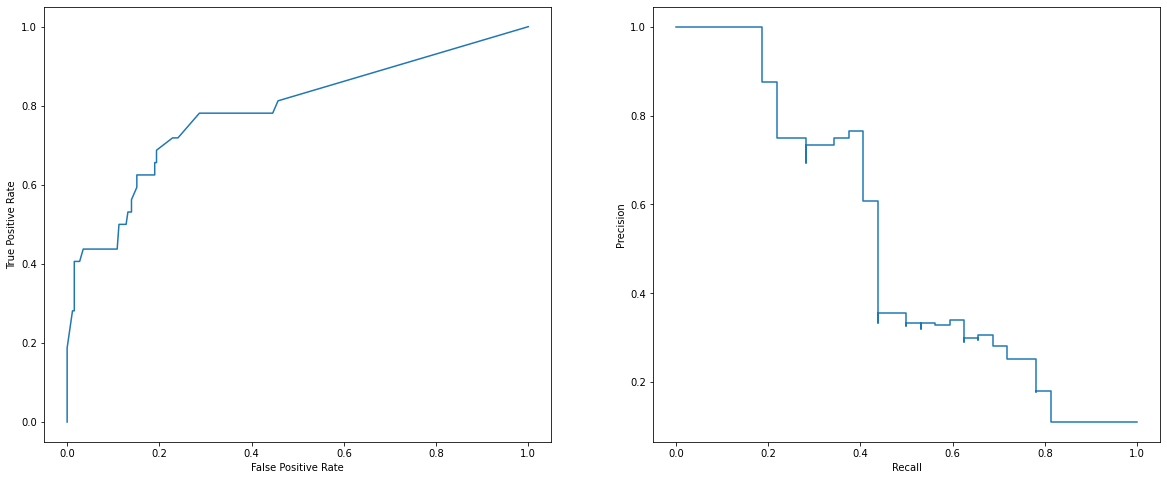

In [758]:
y_prob = clf_xgb.predict_proba(X_test_p)
probabilities = y_prob[:,1]

fpr_gan_p, tpr_gan_p, _ = roc_curve(y_test_p, probabilities)
roc_display_gan_p = RocCurveDisplay(fpr=fpr_gan_p, tpr=tpr_gan_p)
roc_auc_gan_p = auc(fpr_gan_p, tpr_gan_p)

prec_gan_p, recall_gan_p, _ = precision_recall_curve(y_test_p, probabilities)
pr_auc_gan_p = auc(recall_gan_p, prec_gan_p)
pr_display_gan_p = PrecisionRecallDisplay(precision=prec_gan_p, recall=recall_gan_p)

print('ROC AUC:', roc_auc_gan_p)
print('Precision-Recall AUC:', pr_auc_gan_p)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

roc_display_gan_p.plot(ax=ax1)
pr_display_gan_p.plot(ax=ax2)
plt.show()

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


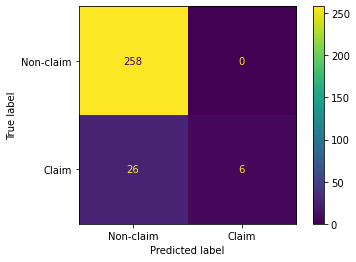

In [759]:
plot_confusion_matrix(clf_xgb, X_test_p, y_test_p, values_format='d', 
                      display_labels=['Non-claim', 'Claim'])

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:14:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight:  {'Territory_GREECE': 1, 'Full_GGTP': 3, 'Limit_100Pct_USD': 1, 'SubClass_FUND_MANAGERS': 1, 'BrokerFeePct': 1, 'StatsMinorClassCode_DS': 1}
gain:  {'Territory_GREECE': 1608.41687, 'Full_GGTP': 16.372924813, 'Limit_100Pct_USD': 5.50708008, 'SubClass_FUND_MANAGERS': 10.0037727, 'BrokerFeePct': 8.34651947, 'StatsMinorClassCode_DS': 1.94485283}
cover:  {'Territory_GREECE': 516.0, 'Full_GGTP': 235.0, 'Limit_100Pct_USD': 61.0, 'SubClass_FUND_MANAGERS': 51.25, 'BrokerFeePct': 35.25, 'StatsMinorClassCode_DS': 16.0}
total_gain:  {'Territory_GREECE': 1608.41687, 'Full_GGTP': 49.118774439, 'Limit_100Pct_USD': 5.50708008, 'SubClass_FUND_MANAGERS': 10.0037727, 'BrokerFeePct': 8.34651947, 'StatsMinorClassCode_DS': 1.94485283}
total_cover:  {'T

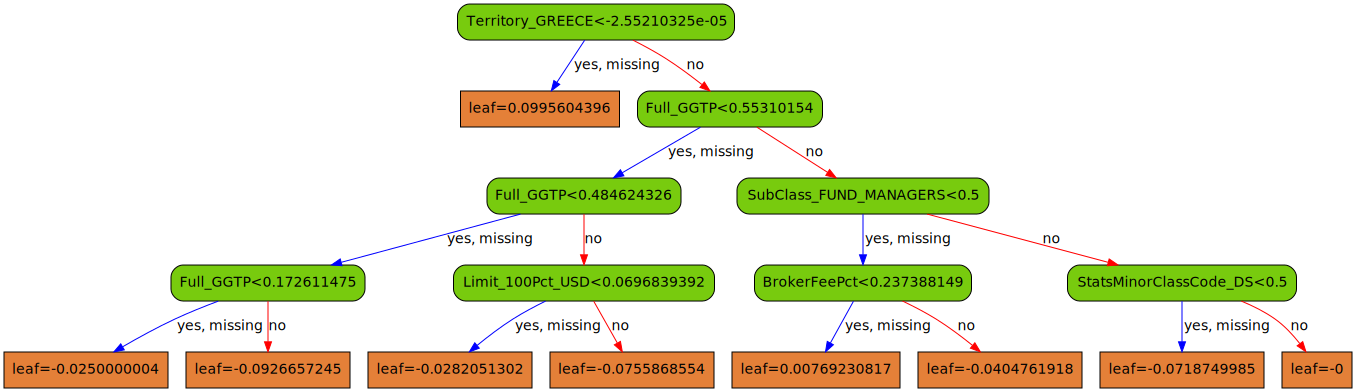

In [760]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                           gamma=0,
                          learning_rate=0.05,
                          max_depth=4,
                          reg_lambda=1,
                          scale_pos_weight=1,
                           seed=42,
                           n_estimators=1)
clf_xgb.fit(X_gan_p, y_gan_p)
bst=clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)


#### Excess Business

In [761]:
# param_grid ={
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.1, 1.0],
#     'reg_lambda': [1.0, 5.0, 10.0],
#     'scale_pos_weight' : [1, 2, 3]
# }

# # AUC since data is imbalance
# # Choose only 90% random subset of the data and for each tree, choose only 50% of the columns to
# # improve the speed and prevent overfitting
# optimal_params = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42, 
#                                                 subsample=0.9, colsample_bytree=0.5),
#                              param_grid=param_grid,
#                               scoring='roc_auc',
#                              verbose=2,
# #                               n_jobs=10,
#                              cv=3)

# optimal_params.fit(X_gan_e, y_gan_e, verbose=False, early_stopping_rounds=10, 
#             eval_metric='aucpr', eval_set=[(X_test_e, y_test_e)])

In [762]:
# print(optimal_params.best_params_)

In [763]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0.1,
                          learning_rate=0.1,
                          max_depth=6,
                          reg_lambda=10,
                          scale_pos_weight=3,
                           seed=42,
                           subsample=0.9, 
                            colsample_bytree=0.5)
clf_xgb.fit(X_gan_e, y_gan_e, verbose=True, early_stopping_rounds=10, 
            eval_metric='aucpr', eval_set=[(X_test_e, y_test_e)])

[0]	validation_0-aucpr:0.71453
[1]	validation_0-aucpr:0.75065
[2]	validation_0-aucpr:0.73775
[3]	validation_0-aucpr:0.73873
[4]	validation_0-aucpr:0.73358
[5]	validation_0-aucpr:0.74740


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[6]	validation_0-aucpr:0.74609
[7]	validation_0-aucpr:0.76529
[8]	validation_0-aucpr:0.77305
[9]	validation_0-aucpr:0.77951
[10]	validation_0-aucpr:0.77250
[11]	validation_0-aucpr:0.77729
[12]	validation_0-aucpr:0.78065
[13]	validation_0-aucpr:0.78561
[14]	validation_0-aucpr:0.78697
[15]	validation_0-aucpr:0.78631
[16]	validation_0-aucpr:0.79346
[17]	validation_0-aucpr:0.79365
[18]	validation_0-aucpr:0.79075
[19]	validation_0-aucpr:0.79189
[20]	validation_0-aucpr:0.78961
[21]	validation_0-aucpr:0.78798
[22]	validation_0-aucpr:0.79218
[23]	validation_0-aucpr:0.79760
[24]	validation_0-aucpr:0.80021
[25]	validation_0-aucpr:0.80152
[26]	validation_0-aucpr:0.80131
[27]	validation_0-aucpr:0.79890
[28]	validation_0-aucpr:0.80051
[29]	validation_0-aucpr:0.80001
[30]	validation_0-aucpr:0.80055
[31]	validation_0-aucpr:0.79802
[32]	validation_0-aucpr:0.79754
[33]	validation_0-aucpr:0.80322
[34]	validation_0-aucpr:0.80542
[35]	validation_0-aucpr:0.80606
[36]	validation_0-aucpr:0.81102
[37]	validat

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=10, scale_pos_weight=3, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [764]:
print('Best score:', clf_xgb.best_score)
print('Best iteration:', clf_xgb.best_iteration)

Best score: 0.823716
Best iteration: 56


In [765]:
# make predictions for test data
y_pred = clf_xgb.predict(X_test_e)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test_e, predictions)
report = classification_report(y_test_e, predictions)
roc_auc = roc_auc_score(y_test_e, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC:", roc_auc)
print(report)

Accuracy: 76.27%
ROC AUC: 0.760271175365515
              precision    recall  f1-score   support

         0.0       0.87      0.77      0.81       159
         1.0       0.61      0.75      0.67        77

    accuracy                           0.76       236
   macro avg       0.74      0.76      0.74       236
weighted avg       0.78      0.76      0.77       236



/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ROC AUC: 0.8816466552315609
Precision-Recall AUC: 0.8237082740107393


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


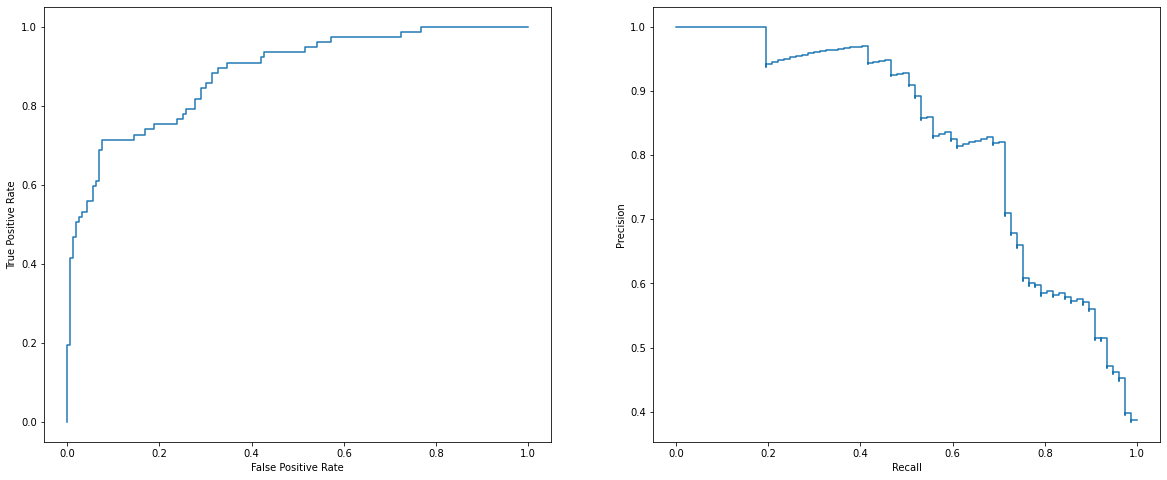

In [766]:
y_prob = clf_xgb.predict_proba(X_test_e)
probabilities = y_prob[:,1]

fpr_gan_e, tpr_gan_e, _ = roc_curve(y_test_e, probabilities)
roc_display_gan_e = RocCurveDisplay(fpr=fpr_gan_e, tpr=tpr_gan_e)
roc_auc_gan_e = auc(fpr_gan_e, tpr_gan_e)

prec_gan_e, recall_gan_e, _ = precision_recall_curve(y_test_e, probabilities)
pr_display_gan_e = PrecisionRecallDisplay(precision=prec_gan_e, recall=recall_gan_e)
pr_auc_gan_e = auc(recall_gan_e, prec_gan_e)

print('ROC AUC:', roc_auc_gan_e)
print('Precision-Recall AUC:', pr_auc_gan_e)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

roc_display_gan_e.plot(ax=ax1)
pr_display_gan_e.plot(ax=ax2)
plt.show()

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


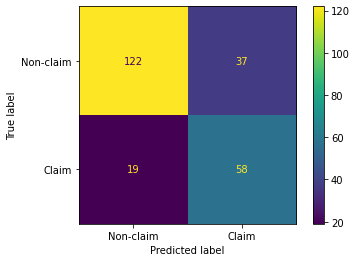

In [767]:
plot_confusion_matrix(clf_xgb, X_test_e, y_test_e, values_format='d', 
                      display_labels=['Non-claim', 'Claim'])

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:14:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight:  {'SubClass_FUND_MANAGERS': 1, 'Full_GGTP': 5, 'Limit_100Pct_USD': 4, 'StatsMinorClassCode_DQ': 1, 'ModelToTechnicalRto': 2, 'XS_100Pct_USD': 2, 'Territory_ISRAEL': 1, 'BrokerFeePct': 1, 'BrokerUltimateName_LOCKTON': 1, 'SubClass_COMMERCIAL_BANK': 1, 'StatsMinorClassCode_DS': 1, 'RARC': 2, 'Territory_NETHERLANDS': 1, 'ModelToActualRto': 1, 'PLR_band_Upper_Middle': 1}
gain:  {'SubClass_FUND_MANAGERS': 466.10022, 'Full_GGTP': 51.076435972599995, 'Limit_100Pct_USD': 6.899384725, 'StatsMinorClassCode_DQ': 3.09194946, 'ModelToTechnicalRto': 2.564546585, 'XS_100Pct_USD': 5.736991645, 'Territory_ISRAEL': 90.3320312, 'BrokerFeePct': 44.536438, 'BrokerUltimateName_LOCKTON': 24.9073792, 'SubClass_COMMERCIAL_BANK': 18.3324661, 'StatsMinorCla

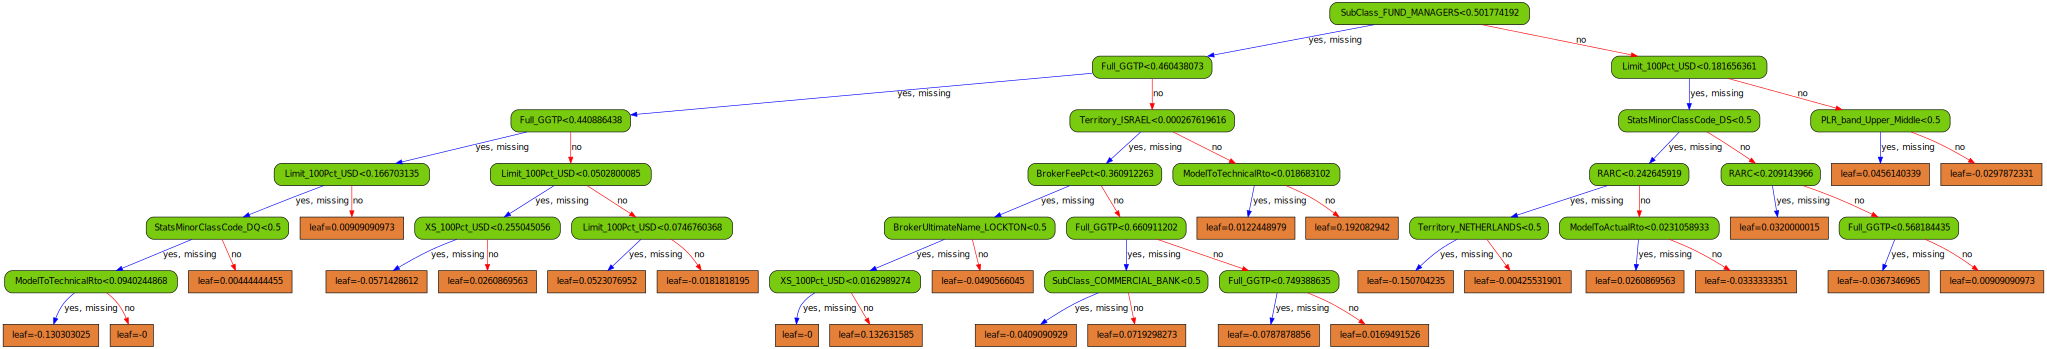

In [768]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0.1,
                          learning_rate=0.1,
                          max_depth=6,
                          reg_lambda=10,
                          scale_pos_weight=3,
                           seed=42,
                           n_estimators=1
                           )
clf_xgb.fit(X_gan_e, y_gan_e)
bst=clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)


## cGAN

#### Primary Business

In [769]:
# rand_dim = len(train_no_label_p.columns) # 32 # needs to be ~data_dim
# base_n_count = 128 # 128

# nb_steps = 10000 + 1 # 50000 # Add one for logging of the last interval
# batch_size = 128 # 64

# k_d = 1  # number of critic network updates per adversarial training step
# k_g = 1  # number of generator network updates per adversarial training step
# critic_pre_train_steps = 100 # 100  # number of steps to pre-train the critic before starting adversarial training
# log_interval = 100 # 100  # interval (in steps) at which to log loss summaries and save plots of image samples to disc
# learning_rate = 5e-4 # 5e-5
# # data_dir = 'cache/'
# # generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None
# # show = True 

In [770]:
# with_class = True
# data_cols = train_no_label_p.columns
# data_cols_w_class = train_p.columns
# data_dim = len(data_cols)
# print('data_dim: ', data_dim)
# print('data_cols: ', data_cols)

# label_dim = 0
# label_dim = len(label_cols)
# print('label_dim: ', label_dim)
# print('label_cols: ', label_cols)
    

# K.set_learning_phase(1) # 1 = train

# cache_prefix = 'CGAN'

# generator_input_tensor = layers.Input(shape=(rand_dim, ))
# labels_tensor = layers.Input(shape=(label_dim,)) # updated for class
# generated_image_tensor = generator_network_w_label(generator_input_tensor, labels_tensor, data_dim, label_dim, base_n_count) # updated for class

# generated_or_real_image_tensor = layers.Input(shape=(data_dim + label_dim,)) # updated for class
    
# discriminator_output = discriminator_network(generated_or_real_image_tensor, data_dim + label_dim, base_n_count)

# generator_model = models.Model(inputs=[generator_input_tensor, labels_tensor], outputs=[generated_image_tensor], name='generator') # updated for class
# discriminator_model = models.Model(inputs=[generated_or_real_image_tensor],
#                                    outputs=[discriminator_output],
#                                    name='discriminator')

# combined_output = discriminator_model(generator_model([generator_input_tensor, labels_tensor])) # updated for class
# combined_model = models.Model(inputs=[generator_input_tensor, labels_tensor], outputs=[combined_output], name='combined') # updated for class

In [771]:
# adam = optimizers.Adam(lr=learning_rate, beta_1=0.5, beta_2=0.9)

# generator_model.compile(optimizer=adam, loss='binary_crossentropy')
# discriminator_model.compile(optimizer=adam, loss='binary_crossentropy')
# discriminator_model.trainable = False
# combined_model.compile(optimizer=adam, loss='binary_crossentropy')

# # print(generator_model.summary())
# # print(discriminator_model.summary())
# # print(combined_model.summary())

In [772]:
# combined_loss, disc_loss_generated, disc_loss_real, xgb_losses = [], [], [], []

In [773]:
# for i in range(0, nb_steps):
#     K.set_learning_phase(1)
    
#     # train the discriminator
#     for j in range(k_d):
#         np.random.seed(i+j)
#         z = np.random.normal(size=(batch_size, rand_dim))
#         x = get_data_batch(train_p, batch_size, seed=i+j)
            
#         if with_class:
#             labels = x[:,-label_dim:]
#             g_z = generator_model.predict([z, labels])
# #             print(g_z)
#         else:
#             g_z = generator_model.predict(z)
# #             x = np.vstack([x,g_z]) # code to train the discriminator on real and generated data at the same time, but you have to run network again for separate losses
# #             classes = np.hstack([np.zeros(batch_size),np.ones(batch_size)])
# #             d_l_r = discriminator_model.train_on_batch(x, classes)
            
#         d_l_r = discriminator_model.train_on_batch(x, np.random.uniform(low=0.999, high=1.0, size=batch_size)) # 0.7, 1.2 # GANs need noise to prevent loss going to zero
#         d_l_g = discriminator_model.train_on_batch(g_z, np.random.uniform(low=0.0, high=0.001, size=batch_size)) # 0.0, 0.3 # GANs need noise to prevent loss going to zero
# #             # d_l_r = discriminator_model.train_on_batch(x, np.ones(batch_size)) # without noise
# #             # d_l_g = discriminator_model.train_on_batch(g_z, np.zeros(batch_size)) # without noise
#     disc_loss_real.append(d_l_r)
#     disc_loss_generated.append(d_l_g)
    
#     # train the generator
#     for j in range(k_g):
#         np.random.seed(i+j)
#         z = np.random.normal(size=(batch_size, rand_dim))
#         if with_class:
#             # loss = combined_model.train_on_batch([z, labels], np.ones(batch_size)) # without noise
#             loss = combined_model.train_on_batch([z, labels], np.random.uniform(low=0.999, high=1.0, size=batch_size)) # 0.7, 1.2 # GANs need noise to prevent loss going to zero
#         else:
#             # loss = combined_model.train_on_batch(z, np.ones(batch_size)) # without noise
#             loss = combined_model.train_on_batch(z, np.random.uniform(low=0.999, high=1.0, size=batch_size)) # 0.7, 1.2 # GANs need noise to prevent loss going to zero
#     combined_loss.append(loss)
    
#     # Determine xgb loss each step, after training generator and discriminator
#     if not i % 10: # 2x faster than testing each step...
#         K.set_learning_phase(0) # 0 = test
#         test_size = np.sum(train_p['Class']==1) # test using all of the actual fraud data
#         x = get_data_batch(train_p, test_size, seed=i)
#         z = np.random.normal(size=(test_size, rand_dim))
#         if with_class:
#             labels = x[:,-label_dim:]
#             g_z = generator_model.predict([z, labels])
#         else:
#             g_z = generator_model.predict(z)
#         xgb_loss = CheckAccuracyConditional( x, g_z, data_cols, label_cols, seed=42, with_class=with_class, data_dim=data_dim )
#         xgb_losses = np.append(xgb_losses, xgb_loss)
    
#     # Saving weights and plotting images
#     if not i % log_interval:
#         print('Step: {} of {}.'.format(i, nb_steps))
#         K.set_learning_phase(0) # 0 = test
                        
#         # loss summaries      
#         print( 'Losses: G, D Gen, D Real, Xgb: {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(combined_loss[-1], disc_loss_generated[-1], disc_loss_real[-1], xgb_losses[-1]) )
#         print( 'D Real - D Gen: {:.4f}'.format(disc_loss_real[-1]-disc_loss_generated[-1]) )    

In [774]:
# fig = plt.figure(figsize=(20,5))
# ax1 = fig.add_subplot(1, 3, 1)
# ax2 = fig.add_subplot(1, 3, 2)
# ax3 = fig.add_subplot(1, 3, 3)

# ax1.plot(combined_loss)
# ax1.set_title('Generator Loss')
# ax1.set_xlabel('Step')
# ax1.set_ylabel('Loss')

# ax2.plot(disc_loss_generated)
# ax2.set_title('Discriminator Loss of Generated Data')
# ax2.set_xlabel('Step')
# ax2.set_ylabel('Loss')

# ax3.plot(disc_loss_real)
# ax3.set_title('Discriminator Loss of Real Data')
# ax3.set_xlabel('Step')
# ax3.set_ylabel('Loss')

# plt.show()

In [775]:
# # Predicting the generated data
# samples = len(X_train_res_p) - len(X_train_p)
# new_z = np.random.normal(size=(samples,rand_dim))
# labels_z = np.ones((samples,1))
# new_g_z = generator_model.predict([new_z, labels_z])

In [776]:
# cgan_samples_p = pd.DataFrame(new_g_z, columns=train_p.columns)
# # Saving the dataset
# cgan_samples_p.to_csv('dandofi_cgan_primary.csv',index=False)

In [777]:
# Loading the dataset
cgan_samples_p = pd.read_csv('../input/project/dandofi_cgan_primary.csv')
cgan_samples_p.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,BrokerUltimateName_RFIB_GROUP_LIMITED,BrokerUltimateName_R_K_HARRISON,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,BrokerUltimateName_WINDSOR_INSURANCE_BROKERS_LTD,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile,Class
0,0.036056,0.479542,0.478905,0.629787,0.146247,0.491071,0.618110,0.150947,-0.000908,0.178581,...,0.003083,-0.003627,-0.002427,0.002388,-0.001526,-3.169634e-03,0.002359,1.027549,0.000818,1.0
1,0.030171,0.378096,1.004160,0.571274,0.142966,0.295352,0.576355,0.164038,0.513685,0.219017,...,0.002218,-0.002491,-0.000451,0.000386,0.000881,8.507045e-04,0.000398,0.991742,-0.000312,1.0
2,0.036061,0.472743,0.473542,0.622416,0.146619,0.478961,0.610431,0.149488,-0.001247,0.173491,...,0.001799,-0.003565,-0.000258,0.002071,0.000170,2.579763e-07,0.001220,1.013116,0.000126,1.0
3,0.030041,0.376825,1.008345,0.572349,0.142058,0.294659,0.576538,0.165220,0.513107,0.219103,...,0.002111,-0.002790,-0.000151,0.000122,0.001164,7.855939e-04,0.000220,0.991521,0.000124,1.0
4,0.066043,0.485876,0.424594,0.490188,0.150975,0.285309,0.631201,0.141511,0.440906,0.190007,...,0.001531,-0.001862,-0.000222,0.000140,0.000023,5.641906e-04,0.001043,0.973904,-0.000230,1.0


In [778]:
cgan_samples_p.drop('Class', axis=1, inplace=True)
cgan_samples_p.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,BrokerUltimateName_PRICE_FORBES_&PARTNERS_LIMITED,BrokerUltimateName_RFIB_GROUP_LIMITED,BrokerUltimateName_R_K_HARRISON,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,BrokerUltimateName_WINDSOR_INSURANCE_BROKERS_LTD,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile
0,0.036056,0.479542,0.478905,0.629787,0.146247,0.491071,0.618110,0.150947,-0.000908,0.178581,...,-0.001369,0.003083,-0.003627,-0.002427,0.002388,-0.001526,-3.169634e-03,0.002359,1.027549,0.000818
1,0.030171,0.378096,1.004160,0.571274,0.142966,0.295352,0.576355,0.164038,0.513685,0.219017,...,-0.001420,0.002218,-0.002491,-0.000451,0.000386,0.000881,8.507045e-04,0.000398,0.991742,-0.000312
2,0.036061,0.472743,0.473542,0.622416,0.146619,0.478961,0.610431,0.149488,-0.001247,0.173491,...,-0.002500,0.001799,-0.003565,-0.000258,0.002071,0.000170,2.579763e-07,0.001220,1.013116,0.000126
3,0.030041,0.376825,1.008345,0.572349,0.142058,0.294659,0.576538,0.165220,0.513107,0.219103,...,-0.001367,0.002111,-0.002790,-0.000151,0.000122,0.001164,7.855939e-04,0.000220,0.991521,0.000124
4,0.066043,0.485876,0.424594,0.490188,0.150975,0.285309,0.631201,0.141511,0.440906,0.190007,...,-0.000834,0.001531,-0.001862,-0.000222,0.000140,0.000023,5.641906e-04,0.001043,0.973904,-0.000230


In [779]:
X_cgan_p = X_train_p.append(cgan_samples_p, ignore_index = True)
X_cgan_p.describe()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,BrokerUltimateName_PRICE_FORBES_&PARTNERS_LIMITED,BrokerUltimateName_RFIB_GROUP_LIMITED,BrokerUltimateName_R_K_HARRISON,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,BrokerUltimateName_WINDSOR_INSURANCE_BROKERS_LTD,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile
count,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,...,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000
mean,0.066305,0.457905,0.613966,0.478743,0.144457,0.312371,0.612434,0.169051,0.412340,0.196250,...,0.003887,0.006347,0.022829,0.020750,0.059482,0.001862,0.138254,0.129875,0.578449,0.154701
std,0.077866,0.093660,0.292355,0.196469,0.039208,0.075231,0.074313,0.072281,0.206783,0.085251,...,0.065942,0.072762,0.152424,0.142875,0.235793,0.044002,0.345703,0.335482,0.495007,0.361505
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.005296,0.000000,...,-0.003692,0.000000,-0.005237,-0.003281,-0.003234,-0.011347,-0.006760,-0.000872,0.000000,-0.004724
25%,0.029994,0.382949,0.422460,0.490998,0.135024,0.285714,0.576397,0.146298,0.433831,0.167233,...,-0.001070,0.000000,-0.001849,0.000000,0.000000,-0.000001,-0.000313,0.000000,0.000000,0.000000
50%,0.039038,0.473430,0.473684,0.523036,0.145850,0.285714,0.613711,0.156692,0.467558,0.191996,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000399,0.990249,0.000000
75%,0.070934,0.502538,1.000000,0.575059,0.151937,0.298300,0.649577,0.167337,0.515403,0.219169,...,0.000000,0.002192,0.000000,0.000000,0.000975,0.000000,0.000572,0.001561,1.000000,0.001195
max,1.000000,1.000000,1.030016,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.098041,1.000000


In [780]:
X_train_p.describe()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,BrokerUltimateName_PRICE_FORBES_&PARTNERS_LIMITED,BrokerUltimateName_RFIB_GROUP_LIMITED,BrokerUltimateName_R_K_HARRISON,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,BrokerUltimateName_WINDSOR_INSURANCE_BROKERS_LTD,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile
count,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,...,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.00000,1158.000000,1158.000000
mean,0.082848,0.462421,0.592188,0.416114,0.141866,0.286037,0.610659,0.180815,0.458424,0.194989,...,0.007772,0.009499,0.042314,0.037133,0.105354,0.003454,0.246978,0.23057,0.246978,0.275475
std,0.099916,0.115641,0.310475,0.240415,0.052049,0.054713,0.095271,0.094588,0.189464,0.112795,...,0.087854,0.097041,0.201392,0.189169,0.307142,0.058696,0.431440,0.42138,0.431440,0.446946
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.020007,0.386800,0.336842,0.427066,0.120527,0.285714,0.549018,0.137357,0.441608,0.124368,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,0.060989,0.457086,0.473684,0.499757,0.137486,0.285714,0.609866,0.162395,0.496810,0.178387,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,0.107310,0.529260,1.000000,0.556543,0.157269,0.285714,0.662761,0.192947,0.563051,0.239935,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [781]:
ones = np.ones((len(cgan_samples_p),))
one = pd.Series(ones)
y_cgan_p = y_train_p.append(one, ignore_index=True)
# y_cgan_p

#### Excess Business

In [782]:
# rand_dim = len(train_no_label_e.columns) # 32 # needs to be ~data_dim
# base_n_count = 128 # 128

# nb_steps = 10000 + 1 # 50000 # Add one for logging of the last interval
# batch_size = 128 # 64

# k_d = 1  # number of critic network updates per adversarial training step
# k_g = 1  # number of generator network updates per adversarial training step
# critic_pre_train_steps = 100 # 100  # number of steps to pre-train the critic before starting adversarial training
# log_interval = 100 # 100  # interval (in steps) at which to log loss summaries and save plots of image samples to disc
# learning_rate = 5e-4 # 5e-5
# # data_dir = 'cache/'
# # generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None
# # show = True 

In [783]:
# with_class = True
# data_cols = train_no_label_e.columns
# data_cols_w_class = train_e.columns
# data_dim = len(data_cols)
# print('data_dim: ', data_dim)
# print('data_cols: ', data_cols)

# label_dim = 0
# label_dim = len(label_cols)
# print('label_dim: ', label_dim)
# print('label_cols: ', label_cols)
    

# K.set_learning_phase(1) # 1 = train

# cache_prefix = 'CGAN'

# generator_input_tensor = layers.Input(shape=(rand_dim, ))
# labels_tensor = layers.Input(shape=(label_dim,)) # updated for class
# generated_image_tensor = generator_network_w_label(generator_input_tensor, labels_tensor, data_dim, label_dim, base_n_count) # updated for class

# generated_or_real_image_tensor = layers.Input(shape=(data_dim + label_dim,)) # updated for class
    
# discriminator_output = discriminator_network(generated_or_real_image_tensor, data_dim + label_dim, base_n_count)

# generator_model = models.Model(inputs=[generator_input_tensor, labels_tensor], outputs=[generated_image_tensor], name='generator') # updated for class
# discriminator_model = models.Model(inputs=[generated_or_real_image_tensor],
#                                    outputs=[discriminator_output],
#                                    name='discriminator')

# combined_output = discriminator_model(generator_model([generator_input_tensor, labels_tensor])) # updated for class
# combined_model = models.Model(inputs=[generator_input_tensor, labels_tensor], outputs=[combined_output], name='combined') # updated for class

In [784]:
# adam = optimizers.Adam(lr=learning_rate, beta_1=0.5, beta_2=0.9)

# generator_model.compile(optimizer=adam, loss='binary_crossentropy')
# discriminator_model.compile(optimizer=adam, loss='binary_crossentropy')
# discriminator_model.trainable = False
# combined_model.compile(optimizer=adam, loss='binary_crossentropy')

# # print(generator_model.summary())
# # print(discriminator_model.summary())
# # print(combined_model.summary())

In [785]:
# combined_loss, disc_loss_generated, disc_loss_real, xgb_losses = [], [], [], []

In [786]:
# for i in range(0, nb_steps):
#     K.set_learning_phase(1)
    
#     # train the discriminator
#     for j in range(k_d):
#         np.random.seed(i+j)
#         z = np.random.normal(size=(batch_size, rand_dim))
#         x = get_data_batch(train_e, batch_size, seed=i+j)
            
#         if with_class:
#             labels = x[:,-label_dim:]
#             g_z = generator_model.predict([z, labels])
# #             print(g_z)
#         else:
#             g_z = generator_model.predict(z)
# #             x = np.vstack([x,g_z]) # code to train the discriminator on real and generated data at the same time, but you have to run network again for separate losses
# #             classes = np.hstack([np.zeros(batch_size),np.ones(batch_size)])
# #             d_l_r = discriminator_model.train_on_batch(x, classes)
            
#         d_l_r = discriminator_model.train_on_batch(x, np.random.uniform(low=0.999, high=1.0, size=batch_size)) # 0.7, 1.2 # GANs need noise to prevent loss going to zero
#         d_l_g = discriminator_model.train_on_batch(g_z, np.random.uniform(low=0.0, high=0.001, size=batch_size)) # 0.0, 0.3 # GANs need noise to prevent loss going to zero
# #             # d_l_r = discriminator_model.train_on_batch(x, np.ones(batch_size)) # without noise
# #             # d_l_g = discriminator_model.train_on_batch(g_z, np.zeros(batch_size)) # without noise
#     disc_loss_real.append(d_l_r)
#     disc_loss_generated.append(d_l_g)
    
#     # train the generator
#     for j in range(k_g):
#         np.random.seed(i+j)
#         z = np.random.normal(size=(batch_size, rand_dim))
#         if with_class:
#             # loss = combined_model.train_on_batch([z, labels], np.ones(batch_size)) # without noise
#             loss = combined_model.train_on_batch([z, labels], np.random.uniform(low=0.999, high=1.0, size=batch_size)) # 0.7, 1.2 # GANs need noise to prevent loss going to zero
#         else:
#             # loss = combined_model.train_on_batch(z, np.ones(batch_size)) # without noise
#             loss = combined_model.train_on_batch(z, np.random.uniform(low=0.999, high=1.0, size=batch_size)) # 0.7, 1.2 # GANs need noise to prevent loss going to zero
#     combined_loss.append(loss)
    
#     # Determine xgb loss each step, after training generator and discriminator
#     if not i % 10: # 2x faster than testing each step...
#         K.set_learning_phase(0) # 0 = test
#         test_size = np.sum(train_e['Class']==1) - 1 # test using all of the actual fraud data - 1
#         x = get_data_batch(train_e, test_size, seed=i)
#         z = np.random.normal(size=(test_size, rand_dim))
#         if with_class:
#             labels = x[:,-label_dim:]
#             g_z = generator_model.predict([z, labels])
#         else:
#             g_z = generator_model.predict(z)
#         xgb_loss = CheckAccuracyConditional( x, g_z, data_cols, label_cols, seed=42, with_class=with_class, data_dim=data_dim )
#         xgb_losses = np.append(xgb_losses, xgb_loss)
    
#     # Saving weights and plotting images
#     if not i % log_interval:
#         print('Step: {} of {}.'.format(i, nb_steps))
#         K.set_learning_phase(0) # 0 = test
                        
#         # loss summaries      
#         print( 'Losses: G, D Gen, D Real, Xgb: {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(combined_loss[-1], disc_loss_generated[-1], disc_loss_real[-1], xgb_losses[-1]) )
#         print( 'D Real - D Gen: {:.4f}'.format(disc_loss_real[-1]-disc_loss_generated[-1]) )    

In [787]:
# fig = plt.figure(figsize=(20,5))
# ax1 = fig.add_subplot(1, 3, 1)
# ax2 = fig.add_subplot(1, 3, 2)
# ax3 = fig.add_subplot(1, 3, 3)

# ax1.plot(combined_loss)
# ax1.set_title('Generator Loss')
# ax1.set_xlabel('Step')
# ax1.set_ylabel('Loss')

# ax2.plot(disc_loss_generated)
# ax2.set_title('Discriminator Loss of Generated Data')
# ax2.set_xlabel('Step')
# ax2.set_ylabel('Loss')

# ax3.plot(disc_loss_real)
# ax3.set_title('Discriminator Loss of Real Data')
# ax3.set_xlabel('Step')
# ax3.set_ylabel('Loss')

# plt.show()

In [788]:
# # Predicting the generated data
# samples = len(X_train_res_e) - len(X_train_e)
# new_z = np.random.normal(size=(samples,rand_dim))
# labels_z = np.ones((samples,1))
# new_g_z = generator_model.predict([new_z, labels_z])

In [789]:
# cgan_samples_e = pd.DataFrame(new_g_z, columns=train_e.columns)
# # Saving the dataset
# cgan_samples_e.to_csv('dandofi_cgan_excess.csv',index=False)

In [790]:
# Loading the dataset
cgan_samples_e = pd.read_csv('../input/project/dandofi_cgan_excess.csv')
cgan_samples_e.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,...,BrokerUltimateName_JLT,BrokerUltimateName_LOCKTON,BrokerUltimateName_LONMAR_GLOBAL_RISKS_LIMITED,BrokerUltimateName_MARSH,BrokerUltimateName_R_K_HARRISON,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile,Class
0,0.085786,0.553739,0.045558,0.099693,0.002503,0.295444,0.213488,0.057398,0.056703,0.714326,...,0.000842,-0.000553,0.000253,0.984385,-0.001274,0.000346,-0.000882,0.000672,1.001728,1.0
1,0.080163,0.554752,0.041878,0.092185,0.004190,0.289725,0.213190,0.054793,0.056584,0.722856,...,0.000162,-0.000513,0.000736,0.987001,-0.002771,0.000671,0.000058,0.000783,0.998026,1.0
2,0.079623,0.555327,0.041754,0.087745,0.003429,0.284635,0.213312,0.056581,0.057859,0.720797,...,0.000747,-0.000384,0.000979,0.985564,-0.002240,0.000469,0.000100,0.000514,0.997365,1.0
3,0.079723,0.555571,0.041343,0.094442,0.004758,0.292582,0.213257,0.053427,0.055928,0.726665,...,-0.000345,-0.000363,0.000679,0.990283,-0.003025,0.001375,0.000109,0.001163,0.999299,1.0
4,0.100645,0.529689,0.037984,0.098377,0.000481,0.432725,0.216086,0.066811,0.020253,0.709465,...,-0.002133,0.002021,0.000643,0.984827,0.001043,0.001379,-0.001841,-0.000329,1.007415,1.0


In [791]:
cgan_samples_e.drop('Class', axis=1, inplace=True)
cgan_samples_e.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,...,BrokerUltimateName_HOWDEN,BrokerUltimateName_JLT,BrokerUltimateName_LOCKTON,BrokerUltimateName_LONMAR_GLOBAL_RISKS_LIMITED,BrokerUltimateName_MARSH,BrokerUltimateName_R_K_HARRISON,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile
0,0.085786,0.553739,0.045558,0.099693,0.002503,0.295444,0.213488,0.057398,0.056703,0.714326,...,-0.002178,0.000842,-0.000553,0.000253,0.984385,-0.001274,0.000346,-0.000882,0.000672,1.001728
1,0.080163,0.554752,0.041878,0.092185,0.004190,0.289725,0.213190,0.054793,0.056584,0.722856,...,-0.001268,0.000162,-0.000513,0.000736,0.987001,-0.002771,0.000671,0.000058,0.000783,0.998026
2,0.079623,0.555327,0.041754,0.087745,0.003429,0.284635,0.213312,0.056581,0.057859,0.720797,...,-0.001052,0.000747,-0.000384,0.000979,0.985564,-0.002240,0.000469,0.000100,0.000514,0.997365
3,0.079723,0.555571,0.041343,0.094442,0.004758,0.292582,0.213257,0.053427,0.055928,0.726665,...,-0.001264,-0.000345,-0.000363,0.000679,0.990283,-0.003025,0.001375,0.000109,0.001163,0.999299
4,0.100645,0.529689,0.037984,0.098377,0.000481,0.432725,0.216086,0.066811,0.020253,0.709465,...,-0.000989,-0.002133,0.002021,0.000643,0.984827,0.001043,0.001379,-0.001841,-0.000329,1.007415


In [792]:
X_cgan_e = X_train_e.append(cgan_samples_e, ignore_index = True)
X_cgan_e.describe()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,...,BrokerUltimateName_HOWDEN,BrokerUltimateName_JLT,BrokerUltimateName_LOCKTON,BrokerUltimateName_LONMAR_GLOBAL_RISKS_LIMITED,BrokerUltimateName_MARSH,BrokerUltimateName_R_K_HARRISON,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile
count,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,...,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000
mean,0.096369,0.543825,0.071061,0.097038,0.015342,0.189276,0.214243,0.058654,0.154965,0.440584,...,0.044748,0.041697,0.040410,0.003437,0.472430,0.041013,0.185797,0.184675,0.178013,0.455010
std,0.084104,0.103900,0.057202,0.119923,0.070572,0.099891,0.039233,0.086503,0.102118,0.298436,...,0.207502,0.200396,0.196679,0.056141,0.498054,0.198555,0.388876,0.388395,0.382300,0.501501
min,0.001686,0.000000,0.000000,0.000000,-0.011360,0.013950,0.097276,0.000000,0.000000,0.000000,...,-0.007352,-0.017061,-0.001850,-0.008681,0.000000,-0.006125,-0.006470,-0.016527,-0.006536,0.000000
25%,0.050870,0.486806,0.040875,0.023331,0.000000,0.129359,0.213925,0.011962,0.096057,0.107143,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.077306,0.540718,0.051400,0.064215,0.000000,0.154357,0.214008,0.039888,0.152566,0.571428,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.111135,0.595018,0.086705,0.129464,0.002724,0.215955,0.214008,0.063868,0.187128,0.714285,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.001557,0.000402,0.001217,1.000000
max,0.965456,1.000000,0.673921,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.064666,1.000000,1.000000,1.000000,1.000000,1.116826


In [793]:
X_train_e.describe()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,...,BrokerUltimateName_HOWDEN,BrokerUltimateName_JLT,BrokerUltimateName_LOCKTON,BrokerUltimateName_LONMAR_GLOBAL_RISKS_LIMITED,BrokerUltimateName_MARSH,BrokerUltimateName_R_K_HARRISON,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile
count,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000,...,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000
mean,0.102701,0.543778,0.079275,0.103731,0.020291,0.151186,0.213656,0.057529,0.185358,0.347040,...,0.060510,0.056263,0.054140,0.004246,0.292994,0.055202,0.249469,0.248408,0.238854,0.263270
std,0.096010,0.119693,0.064176,0.135259,0.081219,0.071757,0.045375,0.099697,0.100351,0.292286,...,0.238555,0.230552,0.226414,0.065060,0.455377,0.228495,0.432936,0.432319,0.426610,0.440641
min,0.001686,0.000000,0.000000,0.000000,0.000000,0.013950,0.097276,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.040581,0.465665,0.035617,0.021690,0.000000,0.121215,0.214008,0.008653,0.143851,0.085714,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.075119,0.535565,0.059542,0.058713,0.000000,0.141268,0.214008,0.020312,0.169073,0.285714,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.124396,0.626045,0.117671,0.132036,0.002674,0.162486,0.214008,0.061430,0.203404,0.642856,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,0.965456,1.000000,0.673921,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [794]:
ones = np.ones((len(cgan_samples_e),))
one = pd.Series(ones)
y_cgan_e = y_train_e.append(one, ignore_index=True)
# y_cgan_e

### XGBoost (cGAN)

#### Primary Business

In [795]:
# param_grid ={
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.1, 1.0],
#     'reg_lambda': [1.0, 5.0, 10.0],
#     'scale_pos_weight' : [1, 2, 3]
# }

# # AUC since data is imbalance
# # Choose only 90% random subset of the data and for each tree, choose only 50% of the columns to
# # improve the speed and prevent overfitting
# optimal_params = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42, 
#                                                 subsample=0.9, colsample_bytree=0.5),
#                              param_grid=param_grid,
#                               scoring='roc_auc',
#                              verbose=2,
# #                               n_jobs=10,
#                              cv=3)

# optimal_params.fit(X_cgan_p, y_cgan_p, verbose=False, early_stopping_rounds=10, 
#             eval_metric='aucpr', eval_set=[(X_test_p, y_test_p)])

In [796]:
# print(optimal_params.best_params_)

In [797]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0,
                          learning_rate=0.01,
                          max_depth=4,
                          reg_lambda=1,
                          scale_pos_weight=2,
                           seed=42,
                           subsample=0.9, 
                            colsample_bytree=0.5)
clf_xgb.fit(X_cgan_p, y_cgan_p, verbose=True, early_stopping_rounds=10, 
            eval_metric='aucpr', eval_set=[(X_test_p, y_test_p)])

[0]	validation_0-aucpr:0.47558
[1]	validation_0-aucpr:0.47749
[2]	validation_0-aucpr:0.49821
[3]	validation_0-aucpr:0.48997
[4]	validation_0-aucpr:0.50241
[5]	validation_0-aucpr:0.50357
[6]	validation_0-aucpr:0.49928
[7]	validation_0-aucpr:0.48098
[8]	validation_0-aucpr:0.51134
[9]	validation_0-aucpr:0.49546
[10]	validation_0-aucpr:0.51199
[11]	validation_0-aucpr:0.51739
[12]	validation_0-aucpr:0.51360
[13]	validation_0-aucpr:0.51175
[14]	validation_0-aucpr:0.50416


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-aucpr:0.50505
[16]	validation_0-aucpr:0.50436
[17]	validation_0-aucpr:0.51040
[18]	validation_0-aucpr:0.51039
[19]	validation_0-aucpr:0.50582
[20]	validation_0-aucpr:0.50103
[21]	validation_0-aucpr:0.49857


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [798]:
print('Best score:', clf_xgb.best_score)
print('Best iteration:', clf_xgb.best_iteration)

Best score: 0.517389
Best iteration: 11


In [799]:
# make predictions for test data
y_pred = clf_xgb.predict(X_test_p)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test_p, predictions)
report = classification_report(y_test_p, predictions)
roc_auc = roc_auc_score(y_test_p, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC:", roc_auc)
print(report)

Accuracy: 91.72%
ROC AUC: 0.6797480620155039
              precision    recall  f1-score   support

         0.0       0.93      0.98      0.95       258
         1.0       0.75      0.38      0.50        32

    accuracy                           0.92       290
   macro avg       0.84      0.68      0.73       290
weighted avg       0.91      0.92      0.90       290



/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ROC AUC: 0.7833696705426356
Precision-Recall AUC: 0.5179635173392176


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


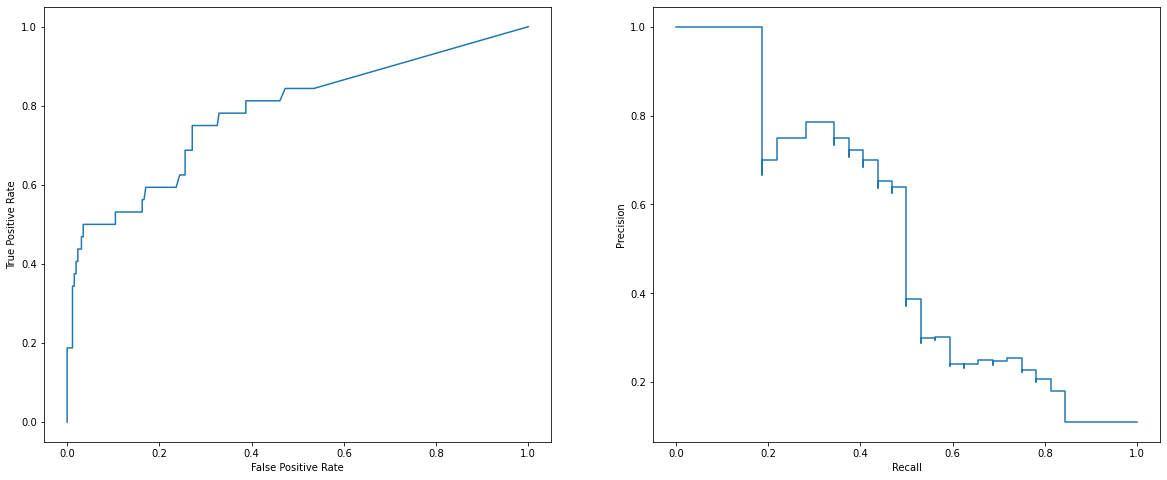

In [800]:
y_prob = clf_xgb.predict_proba(X_test_p)
probabilities = y_prob[:,1]

fpr_cgan_p, tpr_cgan_p, _ = roc_curve(y_test_p, probabilities)
roc_display_cgan_p = RocCurveDisplay(fpr=fpr_cgan_p, tpr=tpr_cgan_p)
roc_auc_cgan_p = auc(fpr_cgan_p, tpr_cgan_p)

prec_cgan_p, recall_cgan_p, _ = precision_recall_curve(y_test_p, probabilities)
pr_display_cgan_p = PrecisionRecallDisplay(precision=prec_cgan_p, recall=recall_cgan_p)
pr_auc_cgan_p = auc(recall_cgan_p, prec_cgan_p)

print('ROC AUC:', roc_auc_cgan_p)
print('Precision-Recall AUC:', pr_auc_cgan_p)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

roc_display_cgan_p.plot(ax=ax1)
pr_display_cgan_p.plot(ax=ax2)
plt.show()

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


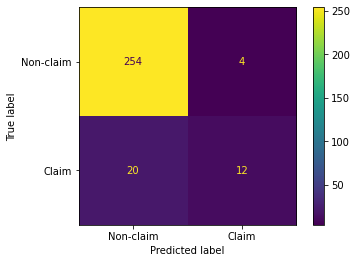

In [801]:
plot_confusion_matrix(clf_xgb, X_test_p, y_test_p, values_format='d', 
                      display_labels=['Non-claim', 'Claim'])

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:14:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight:  {'Territory_BRITISH_VIRGIN_ISLANDS': 1, 'Full_GGTP': 2, 'SubClass_STOCK_EXCHANGE': 1, 'SubClass_FUND_MANAGERS': 1, 'BrokerFeePct': 2}
gain:  {'Territory_BRITISH_VIRGIN_ISLANDS': 1936.81299, 'Full_GGTP': 56.870132325, 'SubClass_STOCK_EXCHANGE': 3.00067139, 'SubClass_FUND_MANAGERS': 36.1775093, 'BrokerFeePct': 16.88885685}
cover:  {'Territory_BRITISH_VIRGIN_ISLANDS': 774.0, 'Full_GGTP': 252.25, 'SubClass_STOCK_EXCHANGE': 182.5, 'SubClass_FUND_MANAGERS': 137.5, 'BrokerFeePct': 68.75}
total_gain:  {'Territory_BRITISH_VIRGIN_ISLANDS': 1936.81299, 'Full_GGTP': 113.74026465, 'SubClass_STOCK_EXCHANGE': 3.00067139, 'SubClass_FUND_MANAGERS': 36.1775093, 'BrokerFeePct': 33.7777137}
total_cover:  {'Territory_BRITISH_VIRGIN_ISLANDS': 774.0, '

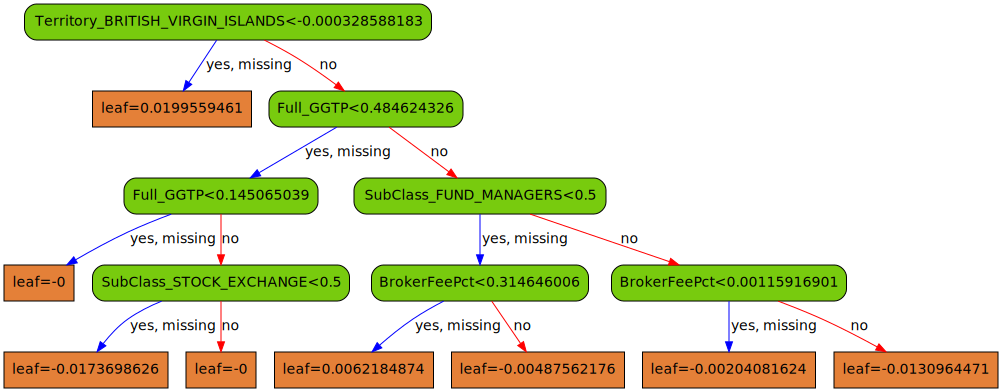

In [802]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0,
                          learning_rate=0.01,
                          max_depth=4,
                          reg_lambda=1,
                          scale_pos_weight=2,
                           seed=42,
                           n_estimators=1)
clf_xgb.fit(X_cgan_p, y_cgan_p)
bst=clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)


#### Excess Business

In [803]:
# param_grid ={
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.1, 1.0],
#     'reg_lambda': [1.0, 5.0, 10.0],
#     'scale_pos_weight' : [1, 2, 3]
# }

# # AUC since data is imbalance
# # Choose only 90% random subset of the data and for each tree, choose only 50% of the columns to
# # improve the speed and prevent overfitting
# optimal_params = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42, 
#                                                 subsample=0.9, colsample_bytree=0.5),
#                              param_grid=param_grid,
#                               scoring='roc_auc',
#                              verbose=2,
# #                               n_jobs=10,
#                              cv=3)

# optimal_params.fit(X_cgan_e, y_cgan_e, verbose=False, early_stopping_rounds=10, 
#             eval_metric='aucpr', eval_set=[(X_test_e, y_test_e)])

In [804]:
# print(optimal_params.best_params_)

In [805]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0.1,
                          learning_rate=0.1,
                          max_depth=5,
                          reg_lambda=10,
                          scale_pos_weight=3,
                           seed=42,
                           subsample=0.9, 
                            colsample_bytree=0.5)
clf_xgb.fit(X_cgan_e, y_cgan_e, verbose=True, early_stopping_rounds=10, 
            eval_metric='aucpr', eval_set=[(X_test_e, y_test_e)])

[0]	validation_0-aucpr:0.70300
[1]	validation_0-aucpr:0.71810
[2]	validation_0-aucpr:0.72847
[3]	validation_0-aucpr:0.72892
[4]	validation_0-aucpr:0.75348
[5]	validation_0-aucpr:0.76582


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[6]	validation_0-aucpr:0.76271
[7]	validation_0-aucpr:0.76623
[8]	validation_0-aucpr:0.77888
[9]	validation_0-aucpr:0.78901
[10]	validation_0-aucpr:0.78816
[11]	validation_0-aucpr:0.79069
[12]	validation_0-aucpr:0.79311
[13]	validation_0-aucpr:0.78274
[14]	validation_0-aucpr:0.77834
[15]	validation_0-aucpr:0.78313
[16]	validation_0-aucpr:0.77686
[17]	validation_0-aucpr:0.77640
[18]	validation_0-aucpr:0.77520
[19]	validation_0-aucpr:0.77865
[20]	validation_0-aucpr:0.77741
[21]	validation_0-aucpr:0.78567


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=10, scale_pos_weight=3, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [806]:
print('Best score:', clf_xgb.best_score)
print('Best iteration:', clf_xgb.best_iteration)

Best score: 0.793106
Best iteration: 12


In [807]:
# make predictions for test data
y_pred = clf_xgb.predict(X_test_e)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test_e, predictions)
report = classification_report(y_test_e, predictions)
roc_auc = roc_auc_score(y_test_e, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC:", roc_auc)
print(report)

Accuracy: 73.31%
ROC AUC: 0.7550028587764438
              precision    recall  f1-score   support

         0.0       0.89      0.69      0.78       159
         1.0       0.56      0.82      0.67        77

    accuracy                           0.73       236
   macro avg       0.72      0.76      0.72       236
weighted avg       0.78      0.73      0.74       236



/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ROC AUC: 0.8600424732500204
Precision-Recall AUC: 0.7931052532606677


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


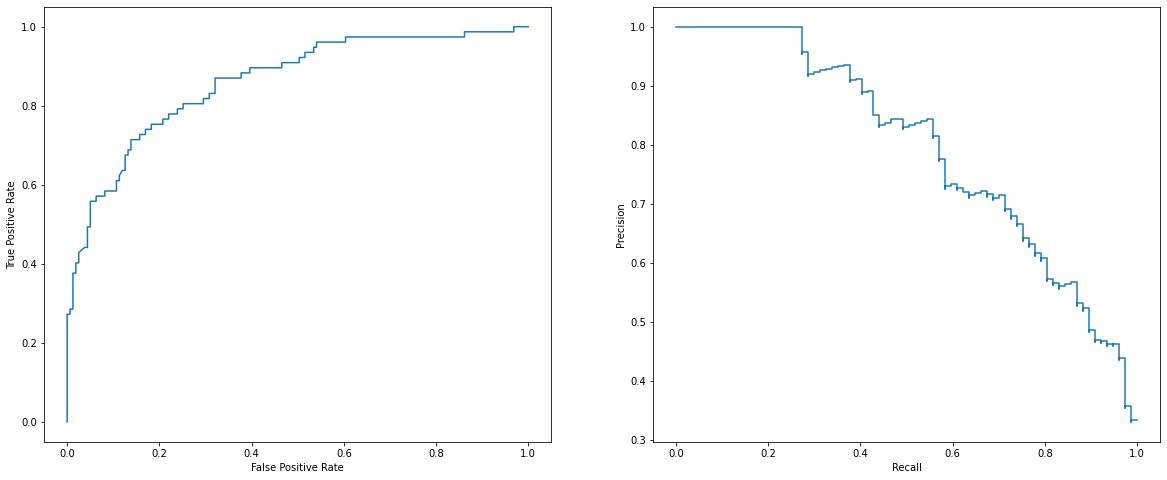

In [808]:
y_prob = clf_xgb.predict_proba(X_test_e)
probabilities = y_prob[:,1]

fpr_cgan_e, tpr_cgan_e, _ = roc_curve(y_test_e, probabilities)
roc_display_cgan_e = RocCurveDisplay(fpr=fpr_cgan_e, tpr=tpr_cgan_e)
roc_auc_cgan_e = auc(fpr_cgan_e, tpr_cgan_e)

prec_cgan_e, recall_cgan_e, _ = precision_recall_curve(y_test_e, probabilities)
pr_display_cgan_e = PrecisionRecallDisplay(precision=prec_cgan_e, recall=recall_cgan_e)
pr_auc_cgan_e = auc(recall_cgan_e, prec_cgan_e)

print('ROC AUC:', roc_auc_cgan_e)
print('Precision-Recall AUC:', pr_auc_cgan_e)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

roc_display_cgan_e.plot(ax=ax1)
pr_display_cgan_e.plot(ax=ax2)
plt.show()

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


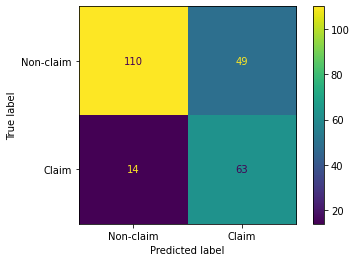

In [809]:
plot_confusion_matrix(clf_xgb, X_test_e, y_test_e, values_format='d', 
                      display_labels=['Non-claim', 'Claim'])

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:14:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight:  {'SubClass_FUND_MANAGERS': 1, 'Full_GGTP': 3, 'Limit_100Pct_USD': 4, 'StatsMinorClassCode_DQ': 1, 'XS_100Pct_USD': 1, 'Territory_AUSTRALIA': 1, 'BrokerFeePct': 1, 'BrokerUltimateName_LOCKTON': 1, 'RARC': 3, 'Full_GrossGrossModelPrice': 1, 'StatsMinorClassCode_DS': 1, 'Territory_NETHERLANDS': 1, 'ModelToActualRto': 1, 'PLR_band_Upper_Middle': 1}
gain:  {'SubClass_FUND_MANAGERS': 466.10022, 'Full_GGTP': 78.54519006433333, 'Limit_100Pct_USD': 6.899384725, 'StatsMinorClassCode_DQ': 3.09194946, 'XS_100Pct_USD': 3.74113417, 'Territory_AUSTRALIA': 83.935791, 'BrokerFeePct': 34.2042236, 'BrokerUltimateName_LOCKTON': 22.0203857, 'RARC': 5.397120953333332, 'Full_GrossGrossModelPrice': 2.59796143, 'StatsMinorClassCode_DS': 12.1621399, 'Terr

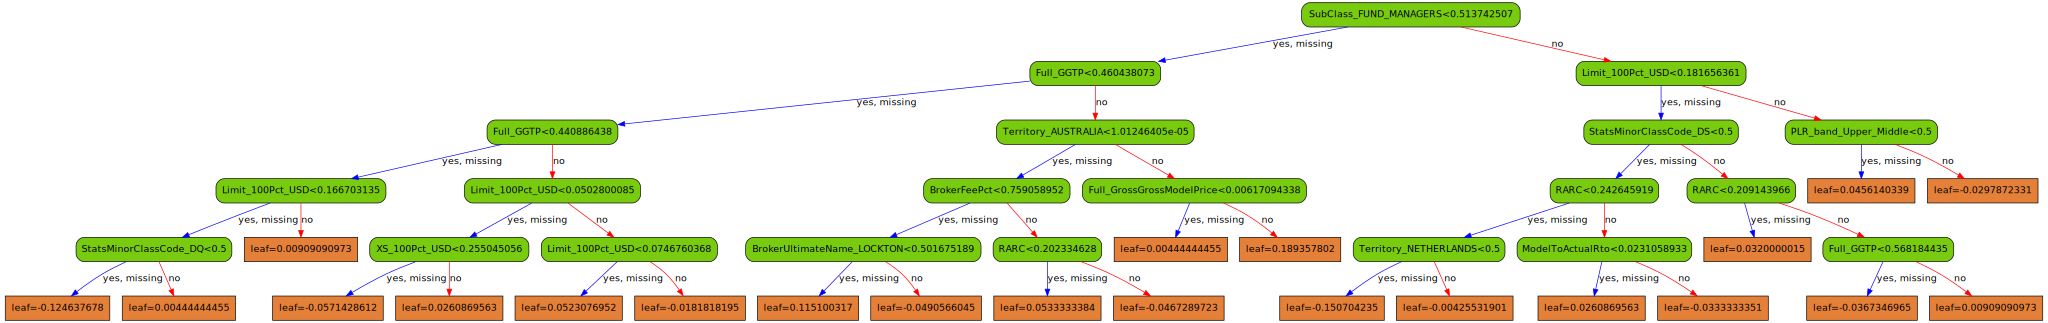

In [810]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                         gamma=0.1,
                          learning_rate=0.1,
                          max_depth=5,
                          reg_lambda=10,
                          scale_pos_weight=3,
                           seed=42,
                           n_estimators=1)
clf_xgb.fit(X_cgan_e, y_cgan_e)
bst=clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)


## WGAN

In [811]:
def critic_network(x, data_dim, base_n_count):
    x = layers.Dense(base_n_count*4, activation='relu')(x)
    # x = layers.Dropout(0.1)(x)
    x = layers.Dense(base_n_count*2, activation='relu')(x) # 2
    # x = layers.Dropout(0.1)(x)
    x = layers.Dense(base_n_count*1, activation='relu')(x) # 1
    # x = layers.Dense(base_n_count*4, activation='relu')(x) # extra
    # x = layers.Dense(base_n_count*4, activation='relu')(x) # extra
    # x = layers.Dense(1, activation='sigmoid')(x)
    x = layers.Dense(1)(x)
    return x

In [812]:
def em_loss(y_coefficients, y_pred):
    # define earth mover distance (wasserstein loss)
    # literally the weighted average of the critic network output
    # this is defined separately so it can be fed as a loss function to the optimizer in the WGANs
    return tf.reduce_mean(tf.multiply(y_coefficients, y_pred))

In [813]:
def train_discriminator_step_p(step, seed=42):
    
    if step == 0:
        init = tf.global_variables_initializer()
    
    if with_class:
        if step == 0:
            sess.run(init)
        d_l_g, d_l_r, _ = sess.run([_disc_loss_generated, _disc_loss_real, disc_optimizer], feed_dict={
            _z: np.random.normal(size=(batch_size, rand_dim)),
            _x: get_data_batch(train_p, batch_size, seed=seed),
            _labels: get_data_batch(train_p, batch_size, seed=seed)[:,-label_dim:], # .reshape(-1,label_dim), # updated for class            
            epsilon: np.random.uniform(low=0.0, high=1.0, size=(batch_size, 1))
        })
    else:
        if step == 0:
            sess.run(init)
        d_l_g, d_l_r, _ = sess.run([_disc_loss_generated, _disc_loss_real, disc_optimizer], feed_dict={
            _z: np.random.normal(size=(batch_size, rand_dim)),
            _x: get_data_batch(train_no_label_p, batch_size, seed=seed),
            epsilon: np.random.uniform(low=0.0, high=1.0, size=(batch_size, 1))
        })
        
    return d_l_g, d_l_r

In [814]:
def train_discriminator_step_e(step, seed=42):
    
    if step == 0:
        init = tf.global_variables_initializer()
    
    if with_class:
        if step == 0:
            sess.run(init)
        d_l_g, d_l_r, _ = sess.run([_disc_loss_generated, _disc_loss_real, disc_optimizer], feed_dict={
            _z: np.random.normal(size=(batch_size, rand_dim)),
            _x: get_data_batch(train_e, batch_size, seed=seed),
            _labels: get_data_batch(train_e, batch_size, seed=seed)[:,-label_dim:], # .reshape(-1,label_dim), # updated for class            
            epsilon: np.random.uniform(low=0.0, high=1.0, size=(batch_size, 1))
        })
    else:
        if step == 0:
            sess.run(init)
        d_l_g, d_l_r, _ = sess.run([_disc_loss_generated, _disc_loss_real, disc_optimizer], feed_dict={
            _z: np.random.normal(size=(batch_size, rand_dim)),
            _x: get_data_batch(train_no_label_e, batch_size, seed=seed),
            epsilon: np.random.uniform(low=0.0, high=1.0, size=(batch_size, 1))
        })
        
    return d_l_g, d_l_r

#### Primary Business

In [815]:
X_encoded_w_classes_p = X_train_p.copy()
X_encoded_w_classes_p['Class'] = y_train_p
X_encoded_w_classes_p.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,BrokerUltimateName_RFIB_GROUP_LIMITED,BrokerUltimateName_R_K_HARRISON,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,BrokerUltimateName_WINDSOR_INSURANCE_BROKERS_LTD,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile,Class
117,0.143687,0.592525,1.000000,0.667851,0.147269,0.285714,0.733587,0.135368,0.220804,0.269055,...,0,0,0,0,0,0,0,1,0,0.0
1114,0.016369,0.417329,0.263158,0.523036,0.124463,0.276786,0.581446,0.198327,0.662413,0.163281,...,0,0,0,0,0,1,0,0,0,0.0
329,0.070934,0.483757,1.000000,0.489530,0.141073,0.285714,0.629164,0.161298,0.607212,0.183989,...,0,0,0,0,0,0,0,1,0,0.0
75,0.005456,0.334266,1.000000,0.667851,0.103390,0.419643,0.465869,0.235901,0.220804,0.068619,...,0,0,0,0,0,0,1,0,0,0.0
1132,0.012732,0.358926,1.000000,0.000000,0.066855,0.245536,0.539493,0.375409,0.662413,0.106699,...,0,1,0,0,0,0,1,0,0,0.0


In [816]:
# Finding rows with class '1'
train_p = X_encoded_w_classes_p.loc[ X_encoded_w_classes_p.Class == 1 ].copy()
claim_w_classes_p = train_p.copy()
claim_w_classes_p['Class'] = y_train_p
# claim_w_classes_p.head()
train_p = claim_w_classes_p.copy().reset_index(drop=True)
# train_p.head()

label_cols = ['Class']
data_cols = [ i for i in train_p.columns if i not in label_cols ]
train_no_label_p = train_p.copy()
train_no_label_p.drop('Class', axis=1, inplace=True)
# train_no_label_p = train_p[ data_cols ]
train_no_label_p.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,BrokerUltimateName_PRICE_FORBES_&PARTNERS_LIMITED,BrokerUltimateName_RFIB_GROUP_LIMITED,BrokerUltimateName_R_K_HARRISON,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,BrokerUltimateName_WINDSOR_INSURANCE_BROKERS_LTD,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile
0,0.180063,0.644623,0.368421,0.583595,0.135876,0.285714,0.621752,0.177593,0.220804,0.030962,...,0,0,0,0,0,0,1,0,0,0
1,0.043128,0.558817,1.000000,0.552863,0.133785,0.285714,0.686212,0.166015,0.496809,0.187871,...,0,0,0,0,0,0,1,0,0,0
2,0.023227,0.411010,0.473684,0.471489,0.130188,0.392857,0.571091,0.167652,0.618252,0.167896,...,0,0,0,0,0,1,1,0,0,0
3,0.043128,0.400612,0.684211,0.000000,0.135198,0.285714,0.531897,0.163792,0.552010,0.113608,...,0,0,0,0,0,0,1,0,0,0
4,0.020654,0.486240,1.000000,0.533263,0.146441,0.955357,0.557473,0.161298,0.441608,0.069642,...,0,0,0,0,0,0,0,0,1,0


In [817]:
# rand_dim = len(train_no_label_p.columns) # 32 # needs to be ~data_dim
# base_n_count = 128 # 128

# nb_steps = 10000 + 1 # 50000 # Add one for logging of the last interval
# batch_size = 128 # 64

# k_d = 1  # number of critic network updates per adversarial training step
# k_g = 1  # number of generator network updates per adversarial training step
# critic_pre_train_steps = 100 # 100  # number of steps to pre-train the critic before starting adversarial training
# log_interval = 100 # 100  # interval (in steps) at which to log loss summaries and save plots of image samples to disc
# learning_rate = 1e-4 # 5e-5
# # data_dir = 'cache/'
# # generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None
# # show = True 

In [818]:
# data_cols = train_no_label_p.columns
# data_dim = len(data_cols)
# print('data_dim: ', data_dim)
# print('data_cols: ', data_cols)
    
# label_dim = 0
# with_class = False
# label_cols = []
    
# K.set_learning_phase(1) # 1 = train

# cache_prefix = 'WGAN'
# generator_input_tensor = layers.Input(shape=(rand_dim, ))
# generated_image_tensor = generator_network(generator_input_tensor, data_dim, base_n_count)

# generated_or_real_image_tensor = layers.Input(shape=(data_dim,))
# discriminator_output = critic_network(generated_or_real_image_tensor, data_dim, base_n_count)

# generator_model = models.Model(inputs=[generator_input_tensor], outputs=[generated_image_tensor], name='generator')
# discriminator_model = models.Model(inputs=[generated_or_real_image_tensor],
#                                        outputs=[discriminator_output],
#                                        name='discriminator')

# combined_output = discriminator_model(generator_model(generator_input_tensor))
# combined_model = models.Model(inputs=[generator_input_tensor], outputs=[combined_output], name='combined')

In [819]:
# _z = tf.placeholder(tf.float32, shape=(batch_size, rand_dim))
    
# _labels = None    

# _x = tf.placeholder(tf.float32, shape=(batch_size, data_dim))
# _g_z = generator_model(_z)

# epsilon = tf.placeholder(tf.float32, shape=(batch_size, 1))
    
# x_hat = epsilon * _x + (1.0 - epsilon) * _g_z
# gradients = tf.gradients(discriminator_model(x_hat), [x_hat])
# _gradient_penalty = 10.0 * tf.square(tf.norm(gradients[0], ord=2) - 1.0)

# # calculate discriminator's loss
# _disc_loss_generated = em_loss(tf.ones(batch_size), discriminator_model(_g_z))
# _disc_loss_real = em_loss(tf.ones(batch_size), discriminator_model(_x))
# _disc_loss = _disc_loss_generated - _disc_loss_real + _gradient_penalty

# # update f by taking an SGD step on mini-batch loss LD(f)
# disc_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.5, beta2=0.9).minimize(_disc_loss, var_list=discriminator_model.trainable_weights)

# sess = K.get_session()

# # compile models

# adam = optimizers.Adam(lr=learning_rate, beta_1=0.5, beta_2=0.9)

# discriminator_model.trainable = False
# combined_model.compile(optimizer=adam, loss=[em_loss])

# combined_loss, disc_loss_generated, disc_loss_real, xgb_losses = [], [], [], []

# # print(generator_model.summary())
# # print(discriminator_model.summary())
# # print(combined_model.summary())

In [820]:
# print('pre-training the critic...')
# K.set_learning_phase(1) # 1 = train
# for i in range(critic_pre_train_steps):
#     if i%20==0:
#         print('Step: {} of {} critic pre-training.'.format(i, critic_pre_train_steps))
#         loss = train_discriminator_step_p(step=0,seed=i)

# print('Last batch of critic pre-training disc_loss: {}.'.format(loss))

In [821]:
# for i in range(0, nb_steps):
#     K.set_learning_phase(1) # 1 = train
    
#     # train the discriminator
#     for j in range(k_d):
#         d_l_g, d_l_r = train_discriminator_step_p(step=i+1,seed=i+j)
#     disc_loss_generated.append(d_l_g)
#     disc_loss_real.append(d_l_r)
    
#     # train the generator
#     for j in range(k_g):
#         np.random.seed(i+j)
#         z = np.random.normal(size=(batch_size, rand_dim))
#         if with_class:
#             labels = get_data_batch(train_p, batch_size, seed=i+j)[:,-label_dim:] # updated for class
#             loss = combined_model.train_on_batch([z, labels], [-np.ones(batch_size)]) # updated for class
#         else:
#             loss = combined_model.train_on_batch(z, [-np.ones(batch_size)])
#     combined_loss.append(loss)
    
#     # Determine xgb loss each step, after training generator and discriminator
#     if not i % 10: # 2x faster than testing each step...
#         K.set_learning_phase(0) # 0 = test
#         test_size = np.sum(train_p['Class']==1) # test using all of the actual claim data
#         x = get_data_batch(train_no_label_p, test_size, seed=i)
#         z = np.random.normal(size=(test_size, rand_dim))
#         if with_class:
#             labels = x[:,-label_dim:]
#             g_z = generator_model.predict([z, labels])
#         else:
#             g_z = generator_model.predict(z)
#         xgb_loss = CheckAccuracy( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim )
#         xgb_losses = np.append(xgb_losses, xgb_loss)
        
#     if not i % log_interval:
#         print('Step: {} of {}.'.format(i, nb_steps))
#         # K.set_learning_phase(0) # 0 = test
                        
#         # loss summaries   
#         print( 'Losses: G, D Gen, D Real, Xgb: {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(combined_loss[-1], disc_loss_generated[-1], disc_loss_real[-1], xgb_losses[-1]) )
#         print( 'D Real - D Gen: {:.4f}'.format(disc_loss_real[-1]-disc_loss_generated[-1]) )

In [822]:
# fig = plt.figure(figsize=(20,5))
# ax1 = fig.add_subplot(1, 3, 1)
# ax2 = fig.add_subplot(1, 3, 2)
# ax3 = fig.add_subplot(1, 3, 3)

# ax1.plot(combined_loss)
# ax1.set_title('Generator Loss')
# ax1.set_xlabel('Step')
# ax1.set_ylabel('Loss')

# ax2.plot(disc_loss_generated)
# ax2.set_title('Discriminator Loss of Generated Data')
# ax2.set_xlabel('Step')
# ax2.set_ylabel('Loss')

# ax3.plot(disc_loss_real)
# ax3.set_title('Discriminator Loss of Real Data')
# ax3.set_xlabel('Step')
# ax3.set_ylabel('Loss')

# plt.show()

In [823]:
# # Predicting the generated data
# samples = len(X_train_res_p) - len(X_train_p)
# new_z = np.random.normal(size=(samples,rand_dim))
# new_g_z = generator_model.predict(new_z)

In [824]:
# wgan_samples_p = pd.DataFrame(new_g_z, columns=data_cols)
# # Saving the dataset
# wgan_samples_p.to_csv('dandofi_wgan_primary.csv',index=False)

In [825]:
# Loading the dataset
wgan_samples_p = pd.read_csv('../input/project/dandofi_wgan_primary.csv')
wgan_samples_p.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,BrokerUltimateName_PRICE_FORBES_&PARTNERS_LIMITED,BrokerUltimateName_RFIB_GROUP_LIMITED,BrokerUltimateName_R_K_HARRISON,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,BrokerUltimateName_WINDSOR_INSURANCE_BROKERS_LTD,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile
0,0.002009,0.463216,0.692022,0.066849,0.099307,0.296103,0.581741,0.327412,0.639560,-0.041711,...,-0.087477,-0.023528,0.620619,-0.195361,-0.106050,0.002342,0.186064,0.954895,0.029955,0.001876
1,0.036266,0.601087,0.651568,-0.004788,0.179779,0.372535,0.784743,0.235815,0.558604,0.214348,...,-0.020180,0.052755,0.031521,0.049623,-0.040345,-0.014753,-0.152563,-0.014489,1.063731,-0.008311
2,0.203373,0.630189,0.370202,0.429319,0.160526,0.286524,0.793635,0.049739,0.156958,0.421830,...,0.001636,-0.009337,-0.134637,0.019316,-0.043314,-0.057581,0.025304,0.028620,0.029206,1.007837
3,0.148087,0.535011,0.288914,0.589561,0.155925,0.283387,0.665285,0.135339,0.034602,0.159609,...,0.002978,0.044291,0.070054,-0.058135,0.006331,0.004468,0.082809,0.091335,0.849693,0.005449
4,0.175065,0.627362,0.235707,0.657224,0.197679,0.291501,0.706252,0.110891,0.062755,0.143277,...,0.004652,-0.012515,0.012990,0.016728,0.766325,0.022431,-0.016558,-0.042560,0.908555,0.098504


In [826]:
X_wgan_p = X_train_p.append(wgan_samples_p, ignore_index = True)
X_wgan_p.describe()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,BrokerUltimateName_PRICE_FORBES_&PARTNERS_LIMITED,BrokerUltimateName_RFIB_GROUP_LIMITED,BrokerUltimateName_R_K_HARRISON,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,BrokerUltimateName_WINDSOR_INSURANCE_BROKERS_LTD,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile
count,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,...,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000
mean,0.102366,0.501011,0.525731,0.427186,0.138529,0.291004,0.636702,0.179087,0.410824,0.196223,...,0.004637,0.014052,0.044920,0.035925,0.098126,0.008335,0.271235,0.196510,0.264292,0.274163
std,0.104458,0.121800,0.291055,0.229583,0.053392,0.067404,0.103323,0.086455,0.203056,0.121355,...,0.077170,0.108713,0.182981,0.170359,0.286025,0.068818,0.418789,0.383503,0.419194,0.426885
min,-0.089137,0.000000,-0.121020,-0.460789,-0.036715,-0.013668,0.000000,0.000000,-0.185279,-0.135418,...,-0.184886,-0.185842,-0.226371,-0.315666,-0.269984,-0.257174,-0.306857,-0.360388,-0.375678,-0.267462
25%,0.034558,0.424175,0.298211,0.336096,0.110789,0.268855,0.571655,0.133915,0.280000,0.119365,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.070934,0.497678,0.473684,0.499757,0.135964,0.285714,0.629164,0.162986,0.441608,0.176359,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.148141,0.568558,0.725738,0.563856,0.162082,0.300256,0.693475,0.201133,0.552011,0.248650,...,0.000000,0.002238,0.011418,0.005104,0.021054,0.001062,0.648526,0.098461,0.567351,0.731758
max,1.000000,1.000000,1.385698,1.271501,1.000000,1.000000,1.031710,1.000000,1.021485,1.205953,...,1.000000,1.848688,1.399756,1.324385,1.319441,1.099508,1.738722,1.455752,1.380794,1.383604


In [827]:
X_train_p.describe()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,BrokerUltimateName_PRICE_FORBES_&PARTNERS_LIMITED,BrokerUltimateName_RFIB_GROUP_LIMITED,BrokerUltimateName_R_K_HARRISON,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,BrokerUltimateName_WINDSOR_INSURANCE_BROKERS_LTD,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile
count,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,...,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.00000,1158.000000,1158.000000
mean,0.082848,0.462421,0.592188,0.416114,0.141866,0.286037,0.610659,0.180815,0.458424,0.194989,...,0.007772,0.009499,0.042314,0.037133,0.105354,0.003454,0.246978,0.23057,0.246978,0.275475
std,0.099916,0.115641,0.310475,0.240415,0.052049,0.054713,0.095271,0.094588,0.189464,0.112795,...,0.087854,0.097041,0.201392,0.189169,0.307142,0.058696,0.431440,0.42138,0.431440,0.446946
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.020007,0.386800,0.336842,0.427066,0.120527,0.285714,0.549018,0.137357,0.441608,0.124368,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,0.060989,0.457086,0.473684,0.499757,0.137486,0.285714,0.609866,0.162395,0.496810,0.178387,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,0.107310,0.529260,1.000000,0.556543,0.157269,0.285714,0.662761,0.192947,0.563051,0.239935,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [828]:
ones = np.ones((len(wgan_samples_p),))
one = pd.Series(ones)
y_wgan_p = y_train_p.append(one, ignore_index=True)
# y_wgan_p

#### Excess Business

In [829]:
X_encoded_w_classes_e = X_train_e.copy()
X_encoded_w_classes_e['Class'] = y_train_e
X_encoded_w_classes_e.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,...,BrokerUltimateName_JLT,BrokerUltimateName_LOCKTON,BrokerUltimateName_LONMAR_GLOBAL_RISKS_LIMITED,BrokerUltimateName_MARSH,BrokerUltimateName_R_K_HARRISON,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile,Class
1173,0.018223,0.411304,0.117671,0.011355,0.000000,0.102076,0.202335,0.004201,0.222524,0.714284,...,0,0,0,0,0,0,1,0,0,0.0
1021,0.015502,0.324901,0.241535,0.013098,0.000306,0.108668,0.252918,0.001830,0.208333,0.000000,...,0,0,0,0,1,0,1,0,0,0.0
907,0.044363,0.637673,0.035095,0.046947,0.027240,0.132911,0.408560,0.051429,0.166666,0.285714,...,0,1,0,0,0,1,0,0,0,0.0
1147,0.028986,0.425712,0.117671,0.005765,0.000681,0.189095,0.214008,0.005968,0.128996,0.535713,...,1,0,0,0,0,0,0,0,1,0.0
417,0.378246,0.686888,0.018868,0.145264,0.000000,0.174166,0.214008,0.163374,0.129454,0.100000,...,0,0,0,0,0,0,0,0,1,1.0


In [830]:
# Finding rows with class '1'
train_e = X_encoded_w_classes_e.loc[ X_encoded_w_classes_e.Class == 1 ].copy()
claim_w_classes_e = train_e.copy()
claim_w_classes_e['Class'] = y_train_e
# claim_w_classes_e.head()
train_e = claim_w_classes_e.copy().reset_index(drop=True)
# train_e.head()

label_cols = ['Class']
data_cols = [ i for i in train_e.columns if i not in label_cols ]
train_no_label_e = train_e.copy()
train_no_label_e.drop('Class', axis=1, inplace=True)
# train_no_label_e = train_e[ data_cols ]
train_no_label_e.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,...,BrokerUltimateName_HOWDEN,BrokerUltimateName_JLT,BrokerUltimateName_LOCKTON,BrokerUltimateName_LONMAR_GLOBAL_RISKS_LIMITED,BrokerUltimateName_MARSH,BrokerUltimateName_R_K_HARRISON,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile
0,0.378246,0.686888,0.018868,0.145264,0.0,0.174166,0.214008,0.163374,0.129454,0.100000,...,0,0,0,0,0,0,0,0,0,1
1,0.075119,0.764804,0.241535,0.058713,0.0,0.127382,0.233463,0.158930,0.191394,0.342857,...,0,0,0,0,0,0,1,0,0,0
2,0.050514,0.448737,0.066668,0.005765,0.0,0.133804,0.214008,0.007818,0.193402,0.785714,...,1,0,0,0,0,0,1,0,0,0
3,0.028986,0.516941,0.043352,0.352865,0.0,0.124617,0.214008,0.011594,0.192609,0.288677,...,0,0,0,0,1,0,1,0,0,0
4,0.075119,0.589562,0.043352,0.029298,0.0,0.121215,0.194553,0.008149,0.185013,0.285714,...,0,0,0,0,0,0,1,0,0,0


In [831]:
# rand_dim = len(train_no_label_e.columns) # 32 # needs to be ~data_dim
# base_n_count = 128 # 128

# nb_steps = 10000 + 1 # 50000 # Add one for logging of the last interval
# batch_size = 128 # 64

# k_d = 1  # number of critic network updates per adversarial training step
# k_g = 1  # number of generator network updates per adversarial training step
# critic_pre_train_steps = 100 # 100  # number of steps to pre-train the critic before starting adversarial training
# log_interval = 100 # 100  # interval (in steps) at which to log loss summaries and save plots of image samples to disc
# learning_rate = 1e-4 # 5e-5
# # data_dir = 'cache/'
# # generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None
# # show = True 

In [832]:
# data_cols = train_no_label_e.columns
# data_dim = len(data_cols)
# print('data_dim: ', data_dim)
# print('data_cols: ', data_cols)
    
# label_dim = 0
# with_class = False
# label_cols = []
    
# K.set_learning_phase(1) # 1 = train

# cache_prefix = 'WGAN'
# generator_input_tensor = layers.Input(shape=(rand_dim, ))
# generated_image_tensor = generator_network(generator_input_tensor, data_dim, base_n_count)

# generated_or_real_image_tensor = layers.Input(shape=(data_dim,))
# discriminator_output = critic_network(generated_or_real_image_tensor, data_dim, base_n_count)

# generator_model = models.Model(inputs=[generator_input_tensor], outputs=[generated_image_tensor], name='generator')
# discriminator_model = models.Model(inputs=[generated_or_real_image_tensor],
#                                        outputs=[discriminator_output],
#                                        name='discriminator')

# combined_output = discriminator_model(generator_model(generator_input_tensor))
# combined_model = models.Model(inputs=[generator_input_tensor], outputs=[combined_output], name='combined')

In [833]:
# _z = tf.placeholder(tf.float32, shape=(batch_size, rand_dim))
    
# _labels = None    

# _x = tf.placeholder(tf.float32, shape=(batch_size, data_dim))
# _g_z = generator_model(_z)

# epsilon = tf.placeholder(tf.float32, shape=(batch_size, 1))
    
# x_hat = epsilon * _x + (1.0 - epsilon) * _g_z
# gradients = tf.gradients(discriminator_model(x_hat), [x_hat])
# _gradient_penalty = 10.0 * tf.square(tf.norm(gradients[0], ord=2) - 1.0)

# # calculate discriminator's loss
# _disc_loss_generated = em_loss(tf.ones(batch_size), discriminator_model(_g_z))
# _disc_loss_real = em_loss(tf.ones(batch_size), discriminator_model(_x))
# _disc_loss = _disc_loss_generated - _disc_loss_real + _gradient_penalty

# # update f by taking an SGD step on mini-batch loss LD(f)
# disc_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.5, beta2=0.9).minimize(_disc_loss, var_list=discriminator_model.trainable_weights)

# sess = K.get_session()

# # compile models

# adam = optimizers.Adam(lr=learning_rate, beta_1=0.5, beta_2=0.9)

# discriminator_model.trainable = False
# combined_model.compile(optimizer=adam, loss=[em_loss])

# combined_loss, disc_loss_generated, disc_loss_real, xgb_losses = [], [], [], []

# # print(generator_model.summary())
# # print(discriminator_model.summary())
# # print(combined_model.summary())

In [834]:
# print('pre-training the critic...')
# K.set_learning_phase(1) # 1 = train
# for i in range(critic_pre_train_steps):
#     if i%20==0:
#         print('Step: {} of {} critic pre-training.'.format(i, critic_pre_train_steps))
#         loss = train_discriminator_step_e(step=0,seed=i)

# print('Last batch of critic pre-training disc_loss: {}.'.format(loss))

In [835]:
# for i in range(0, nb_steps):
#     K.set_learning_phase(1) # 1 = train
    
#     # train the discriminator
#     for j in range(k_d):
#         d_l_g, d_l_r = train_discriminator_step_e(step=i+1,seed=i+j)
#     disc_loss_generated.append(d_l_g)
#     disc_loss_real.append(d_l_r)
    
#     # train the generator
#     for j in range(k_g):
#         np.random.seed(i+j)
#         z = np.random.normal(size=(batch_size, rand_dim))
#         if with_class:
#             labels = get_data_batch(train_e, batch_size, seed=i+j)[:,-label_dim:] # updated for class
#             loss = combined_model.train_on_batch([z, labels], [-np.ones(batch_size)]) # updated for class
#         else:
#             loss = combined_model.train_on_batch(z, [-np.ones(batch_size)])
#     combined_loss.append(loss)
    
#     # Determine xgb loss each step, after training generator and discriminator
#     if not i % 10: # 2x faster than testing each step...
#         K.set_learning_phase(0) # 0 = test
#         test_size = np.sum(train_e['Class']==1) - 1 # test using all of the actual claim data - 1
#         x = get_data_batch(train_no_label_e, test_size, seed=i)
#         z = np.random.normal(size=(test_size, rand_dim))
#         if with_class:
#             labels = x[:,-label_dim:]
#             g_z = generator_model.predict([z, labels])
#         else:
#             g_z = generator_model.predict(z)
#         xgb_loss = CheckAccuracy( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim )
#         xgb_losses = np.append(xgb_losses, xgb_loss)
        
#     if not i % log_interval:
#         print('Step: {} of {}.'.format(i, nb_steps))
#         # K.set_learning_phase(0) # 0 = test
                        
#         # loss summaries   
#         print( 'Losses: G, D Gen, D Real, Xgb: {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(combined_loss[-1], disc_loss_generated[-1], disc_loss_real[-1], xgb_losses[-1]) )
#         print( 'D Real - D Gen: {:.4f}'.format(disc_loss_real[-1]-disc_loss_generated[-1]) )

In [836]:
# fig = plt.figure(figsize=(20,5))
# ax1 = fig.add_subplot(1, 3, 1)
# ax2 = fig.add_subplot(1, 3, 2)
# ax3 = fig.add_subplot(1, 3, 3)

# ax1.plot(combined_loss)
# ax1.set_title('Generator Loss')
# ax1.set_xlabel('Step')
# ax1.set_ylabel('Loss')

# ax2.plot(disc_loss_generated)
# ax2.set_title('Discriminator Loss of Generated Data')
# ax2.set_xlabel('Step')
# ax2.set_ylabel('Loss')

# ax3.plot(disc_loss_real)
# ax3.set_title('Discriminator Loss of Real Data')
# ax3.set_xlabel('Step')
# ax3.set_ylabel('Loss')

# plt.show()

In [837]:
# # Predicting the generated data
# samples = len(X_train_res_e) - len(X_train_e)
# new_z = np.random.normal(size=(samples,rand_dim))
# new_g_z = generator_model.predict(new_z)

In [838]:
# wgan_samples_e = pd.DataFrame(new_g_z, columns=data_cols)
# # Saving the dataset
# wgan_samples_e.to_csv('dandofi_wgan_excess.csv',index=False)

In [839]:
# Loading the dataset
wgan_samples_e = pd.read_csv('../input/project/dandofi_wgan_excess.csv')
wgan_samples_e.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,...,BrokerUltimateName_HOWDEN,BrokerUltimateName_JLT,BrokerUltimateName_LOCKTON,BrokerUltimateName_LONMAR_GLOBAL_RISKS_LIMITED,BrokerUltimateName_MARSH,BrokerUltimateName_R_K_HARRISON,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile
0,0.111514,0.854625,0.050739,-0.123625,0.025999,0.149991,0.140197,0.399146,0.142950,0.395543,...,0.056475,-0.054386,0.056455,0.005552,0.678402,0.034817,-0.026765,1.086805,-0.121269,-0.078859
1,0.116159,0.614630,0.058902,0.163264,0.008540,0.163115,0.170937,0.105563,0.144570,0.369321,...,0.075898,0.019160,0.060254,0.071945,0.819028,-0.006093,1.022531,-0.022773,0.011113,-0.017400
2,-0.038972,0.576856,0.068480,0.058748,0.156393,0.141463,0.222034,0.101018,0.244900,0.017281,...,0.347918,0.101972,0.033392,0.024429,0.209345,0.077298,-0.005316,0.957623,0.027653,0.102692
3,0.139212,0.682558,0.080053,0.144301,0.086308,0.197227,0.123500,0.125865,0.105517,0.262381,...,0.008180,-0.046347,-0.029086,0.010139,0.448212,-0.057069,0.030648,0.196466,0.013874,0.747370
4,0.075848,0.530722,0.090752,0.010730,0.046930,0.151717,0.291195,0.094172,0.066924,0.030736,...,-0.036860,0.331908,-0.070040,-0.058217,0.684219,-0.081083,-0.063915,0.039356,0.004363,0.918453


In [840]:
X_wgan_e = X_train_e.append(wgan_samples_e, ignore_index = True)
X_wgan_e.describe()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,...,BrokerUltimateName_HOWDEN,BrokerUltimateName_JLT,BrokerUltimateName_LOCKTON,BrokerUltimateName_LONMAR_GLOBAL_RISKS_LIMITED,BrokerUltimateName_MARSH,BrokerUltimateName_R_K_HARRISON,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile
count,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,...,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000
mean,0.112836,0.565775,0.073575,0.120510,0.028922,0.153284,0.208679,0.071404,0.184947,0.327532,...,0.050617,0.049084,0.041077,0.004414,0.319533,0.054801,0.228697,0.272821,0.225544,0.276100
std,0.100996,0.121605,0.061965,0.144409,0.089726,0.077351,0.049284,0.105472,0.099558,0.278327,...,0.215206,0.216440,0.197978,0.061352,0.455279,0.223308,0.415050,0.437619,0.407192,0.437051
min,-0.216155,0.000000,-0.092460,-0.177545,-0.208943,-0.028896,-0.030607,-0.169374,-0.056537,-0.158089,...,-0.234448,-0.168218,-0.151694,-0.128281,-0.246940,-0.282213,-0.181187,-0.133298,-0.151523,-0.208683
25%,0.044363,0.482376,0.032527,0.026313,0.000000,0.117339,0.194553,0.009778,0.136613,0.089385,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.087328,0.563485,0.056245,0.072573,0.000000,0.141694,0.214008,0.031783,0.169444,0.285714,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.152008,0.649748,0.100901,0.161595,0.013620,0.170526,0.214008,0.100779,0.212817,0.571428,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.133520,0.901245,0.130058,0.887021
max,0.965456,1.043086,0.673921,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.075435,...,1.139477,1.227280,1.000000,1.000000,1.571433,1.220560,1.193407,1.296511,1.389740,1.293977


In [841]:
X_train_e.describe()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,...,BrokerUltimateName_HOWDEN,BrokerUltimateName_JLT,BrokerUltimateName_LOCKTON,BrokerUltimateName_LONMAR_GLOBAL_RISKS_LIMITED,BrokerUltimateName_MARSH,BrokerUltimateName_R_K_HARRISON,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile
count,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000,...,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000
mean,0.102701,0.543778,0.079275,0.103731,0.020291,0.151186,0.213656,0.057529,0.185358,0.347040,...,0.060510,0.056263,0.054140,0.004246,0.292994,0.055202,0.249469,0.248408,0.238854,0.263270
std,0.096010,0.119693,0.064176,0.135259,0.081219,0.071757,0.045375,0.099697,0.100351,0.292286,...,0.238555,0.230552,0.226414,0.065060,0.455377,0.228495,0.432936,0.432319,0.426610,0.440641
min,0.001686,0.000000,0.000000,0.000000,0.000000,0.013950,0.097276,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.040581,0.465665,0.035617,0.021690,0.000000,0.121215,0.214008,0.008653,0.143851,0.085714,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.075119,0.535565,0.059542,0.058713,0.000000,0.141268,0.214008,0.020312,0.169073,0.285714,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.124396,0.626045,0.117671,0.132036,0.002674,0.162486,0.214008,0.061430,0.203404,0.642856,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,0.965456,1.000000,0.673921,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [842]:
ones = np.ones((len(wgan_samples_e),))
one = pd.Series(ones)
y_wgan_e = y_train_e.append(one, ignore_index=True)
# y_wgan_e

### XGBoost (WGAN)

#### Primary Business

In [843]:
# param_grid ={
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.1, 1.0],
#     'reg_lambda': [1.0, 5.0, 10.0],
#     'scale_pos_weight' : [1, 2, 3]
# }

# # AUC since data is imbalance
# # Choose only 90% random subset of the data and for each tree, choose only 50% of the columns to
# # improve the speed and prevent overfitting
# optimal_params = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42, 
#                                                 subsample=0.9, colsample_bytree=0.5),
#                              param_grid=param_grid,
#                               scoring='roc_auc',
#                              verbose=2,
# #                               n_jobs=10,
#                              cv=3)

# optimal_params.fit(X_wgan_p, y_wgan_p, verbose=False, early_stopping_rounds=10, 
#             eval_metric='aucpr', eval_set=[(X_test_p, y_test_p)])

In [844]:
# print(optimal_params.best_params_)

In [845]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0,
                          learning_rate=0.05,
                          max_depth=4,
                          reg_lambda=5,
                          scale_pos_weight=3,
                           seed=42,
                           subsample=0.9, 
                            colsample_bytree=0.5)
clf_xgb.fit(X_wgan_p, y_wgan_p, verbose=True, early_stopping_rounds=10, 
            eval_metric='aucpr', eval_set=[(X_test_p, y_test_p)])

[0]	validation_0-aucpr:0.30485
[1]	validation_0-aucpr:0.37482
[2]	validation_0-aucpr:0.37329
[3]	validation_0-aucpr:0.39308
[4]	validation_0-aucpr:0.39628
[5]	validation_0-aucpr:0.45835
[6]	validation_0-aucpr:0.44989
[7]	validation_0-aucpr:0.45102
[8]	validation_0-aucpr:0.45285
[9]	validation_0-aucpr:0.46512
[10]	validation_0-aucpr:0.47108


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11]	validation_0-aucpr:0.47439
[12]	validation_0-aucpr:0.46920
[13]	validation_0-aucpr:0.46640
[14]	validation_0-aucpr:0.50006
[15]	validation_0-aucpr:0.49450
[16]	validation_0-aucpr:0.49313
[17]	validation_0-aucpr:0.49317
[18]	validation_0-aucpr:0.49507
[19]	validation_0-aucpr:0.49472
[20]	validation_0-aucpr:0.47771
[21]	validation_0-aucpr:0.47675
[22]	validation_0-aucpr:0.50095
[23]	validation_0-aucpr:0.49331
[24]	validation_0-aucpr:0.49176
[25]	validation_0-aucpr:0.48641
[26]	validation_0-aucpr:0.48930
[27]	validation_0-aucpr:0.50989
[28]	validation_0-aucpr:0.50728
[29]	validation_0-aucpr:0.50851
[30]	validation_0-aucpr:0.51427
[31]	validation_0-aucpr:0.52190
[32]	validation_0-aucpr:0.52259
[33]	validation_0-aucpr:0.52255
[34]	validation_0-aucpr:0.50999
[35]	validation_0-aucpr:0.50938
[36]	validation_0-aucpr:0.50933
[37]	validation_0-aucpr:0.50889
[38]	validation_0-aucpr:0.50501
[39]	validation_0-aucpr:0.50762
[40]	validation_0-aucpr:0.50620
[41]	validation_0-aucpr:0.50561
[42]	val

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=5, scale_pos_weight=3, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [846]:
print('Best score:', clf_xgb.best_score)
print('Best iteration:', clf_xgb.best_iteration)

Best score: 0.522587
Best iteration: 32


In [847]:
# make predictions for test data
y_pred = clf_xgb.predict(X_test_p)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test_p, predictions)
report = classification_report(y_test_p, predictions)
roc_auc = roc_auc_score(y_test_p, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC:", roc_auc)
print(report)

Accuracy: 88.62%
ROC AUC: 0.6623062015503876
              precision    recall  f1-score   support

         0.0       0.92      0.95      0.94       258
         1.0       0.48      0.38      0.42        32

    accuracy                           0.89       290
   macro avg       0.70      0.66      0.68       290
weighted avg       0.88      0.89      0.88       290



/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ROC AUC: 0.7849442829457364
Precision-Recall AUC: 0.5225519041682344


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


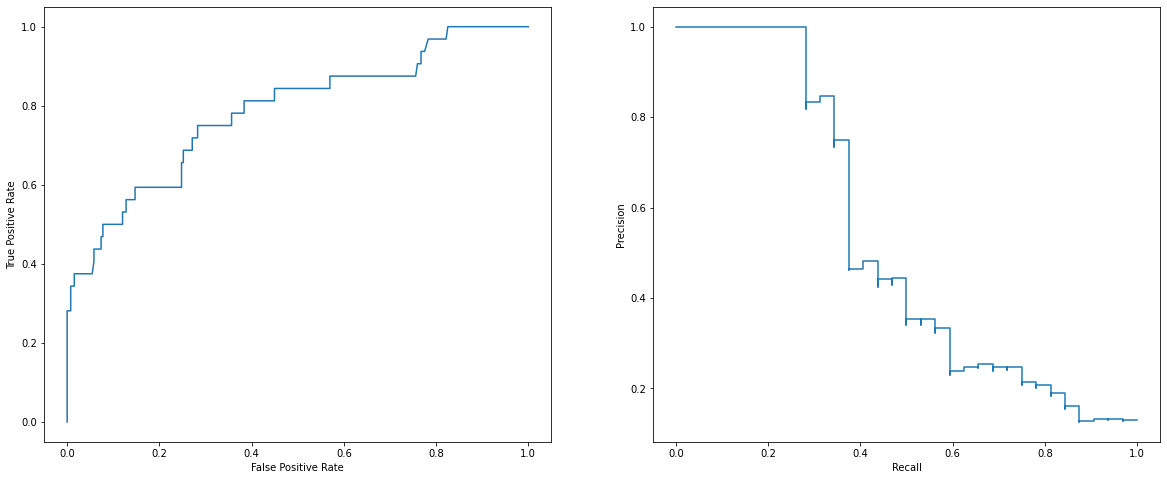

In [848]:
y_prob = clf_xgb.predict_proba(X_test_p)
probabilities = y_prob[:,1]

fpr_wgan_p, tpr_wgan_p, _ = roc_curve(y_test_p, probabilities)
roc_display_wgan_p = RocCurveDisplay(fpr=fpr_wgan_p, tpr=tpr_wgan_p)
roc_auc_wgan_p = auc(fpr_wgan_p, tpr_wgan_p)

prec_wgan_p, recall_wgan_p, _ = precision_recall_curve(y_test_p, probabilities)
pr_display_wgan_p = PrecisionRecallDisplay(precision=prec_wgan_p, recall=recall_wgan_p)
pr_auc_wgan_p = auc(recall_wgan_p, prec_wgan_p)

print('ROC AUC:', roc_auc_wgan_p)
print('Precision-Recall AUC:', pr_auc_wgan_p)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

roc_display_wgan_p.plot(ax=ax1)
pr_display_wgan_p.plot(ax=ax2)
plt.show()

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


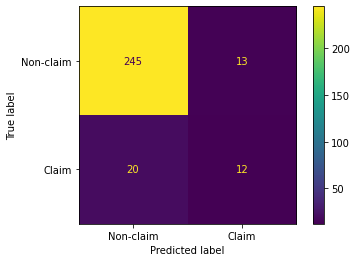

In [849]:
plot_confusion_matrix(clf_xgb, X_test_p, y_test_p, values_format='d', 
                      display_labels=['Non-claim', 'Claim'])

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:14:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight:  {'SubClass_FINANCIAL_INSTITUTIONS': 3, 'Full_GGTP': 2, 'SubClass_FUND_MANAGERS': 1}
gain:  {'SubClass_FINANCIAL_INSTITUTIONS': 649.4067796, 'Full_GGTP': 93.928298865, 'SubClass_FUND_MANAGERS': 49.6891403}
cover:  {'SubClass_FINANCIAL_INSTITUTIONS': 688.0, 'Full_GGTP': 270.375, 'SubClass_FUND_MANAGERS': 161.75}
total_gain:  {'SubClass_FINANCIAL_INSTITUTIONS': 1948.2203388000003, 'Full_GGTP': 187.85659773, 'SubClass_FUND_MANAGERS': 49.6891403}
total_cover:  {'SubClass_FINANCIAL_INSTITUTIONS': 2064.0, 'Full_GGTP': 540.75, 'SubClass_FUND_MANAGERS': 161.75}


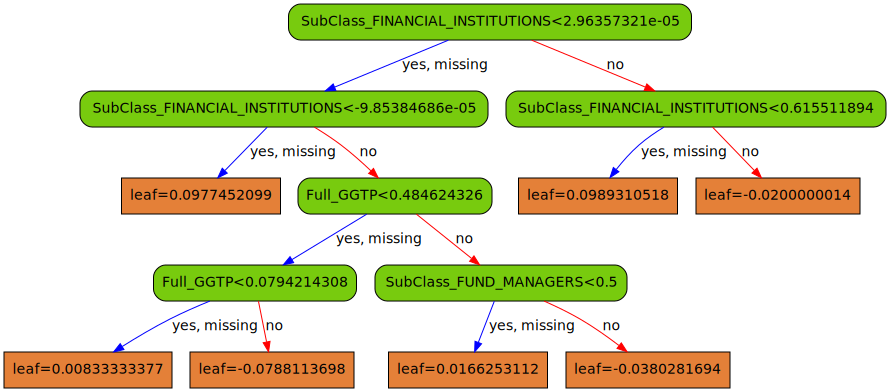

In [850]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                         gamma=0,
                          learning_rate=0.05,
                          max_depth=4,
                          reg_lambda=5,
                          scale_pos_weight=3,
                           seed=42,
                           n_estimators=1)
clf_xgb.fit(X_wgan_p, y_wgan_p)
bst=clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)


#### Excess Business

In [851]:
# param_grid ={
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.1, 1.0],
#     'reg_lambda': [1.0, 5.0, 10.0],
#     'scale_pos_weight' : [1, 2, 3]
# }

# # AUC since data is imbalance
# # Choose only 90% random subset of the data and for each tree, choose only 50% of the columns to
# # improve the speed and prevent overfitting
# optimal_params = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42, 
#                                                 subsample=0.9, colsample_bytree=0.5),
#                              param_grid=param_grid,
#                               scoring='roc_auc',
#                              verbose=2,
# #                               n_jobs=10,
#                              cv=3)

# optimal_params.fit(X_wgan_e, y_wgan_e, verbose=False, early_stopping_rounds=10, 
#             eval_metric='aucpr', eval_set=[(X_test_e, y_test_e)])

In [852]:
# print(optimal_params.best_params_)

In [853]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0,
                          learning_rate=0.1,
                          max_depth=4,
                          reg_lambda=1,
                          scale_pos_weight=1,
                           seed=42,
                           subsample=0.9, 
                            colsample_bytree=0.5)
clf_xgb.fit(X_wgan_e, y_wgan_e, verbose=True, early_stopping_rounds=10, 
            eval_metric='aucpr', eval_set=[(X_test_e, y_test_e)])

[0]	validation_0-aucpr:0.63746
[1]	validation_0-aucpr:0.68158
[2]	validation_0-aucpr:0.69092
[3]	validation_0-aucpr:0.68822


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[4]	validation_0-aucpr:0.69059
[5]	validation_0-aucpr:0.68923
[6]	validation_0-aucpr:0.69079
[7]	validation_0-aucpr:0.68816
[8]	validation_0-aucpr:0.70411
[9]	validation_0-aucpr:0.70754
[10]	validation_0-aucpr:0.70018
[11]	validation_0-aucpr:0.69874
[12]	validation_0-aucpr:0.70164
[13]	validation_0-aucpr:0.70539
[14]	validation_0-aucpr:0.71054
[15]	validation_0-aucpr:0.70927
[16]	validation_0-aucpr:0.70678
[17]	validation_0-aucpr:0.70325
[18]	validation_0-aucpr:0.70585
[19]	validation_0-aucpr:0.71138
[20]	validation_0-aucpr:0.71544
[21]	validation_0-aucpr:0.71421
[22]	validation_0-aucpr:0.71738
[23]	validation_0-aucpr:0.71935
[24]	validation_0-aucpr:0.72652
[25]	validation_0-aucpr:0.72796
[26]	validation_0-aucpr:0.73075
[27]	validation_0-aucpr:0.73046
[28]	validation_0-aucpr:0.72936
[29]	validation_0-aucpr:0.72654
[30]	validation_0-aucpr:0.73023
[31]	validation_0-aucpr:0.73534
[32]	validation_0-aucpr:0.73689
[33]	validation_0-aucpr:0.74302
[34]	validation_0-aucpr:0.74243
[35]	validatio

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [854]:
print('Best score:', clf_xgb.best_score)
print('Best iteration:', clf_xgb.best_iteration)

Best score: 0.774581
Best iteration: 50


In [855]:
# make predictions for test data
y_pred = clf_xgb.predict(X_test_e)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test_e, predictions)
report = classification_report(y_test_e, predictions)
roc_auc = roc_auc_score(y_test_e, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC:", roc_auc)
print(report)

Accuracy: 80.51%
ROC AUC: 0.7582291921914563
              precision    recall  f1-score   support

         0.0       0.83      0.89      0.86       159
         1.0       0.74      0.62      0.68        77

    accuracy                           0.81       236
   macro avg       0.78      0.76      0.77       236
weighted avg       0.80      0.81      0.80       236



/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ROC AUC: 0.868455443927142
Precision-Recall AUC: 0.7745303768430988


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


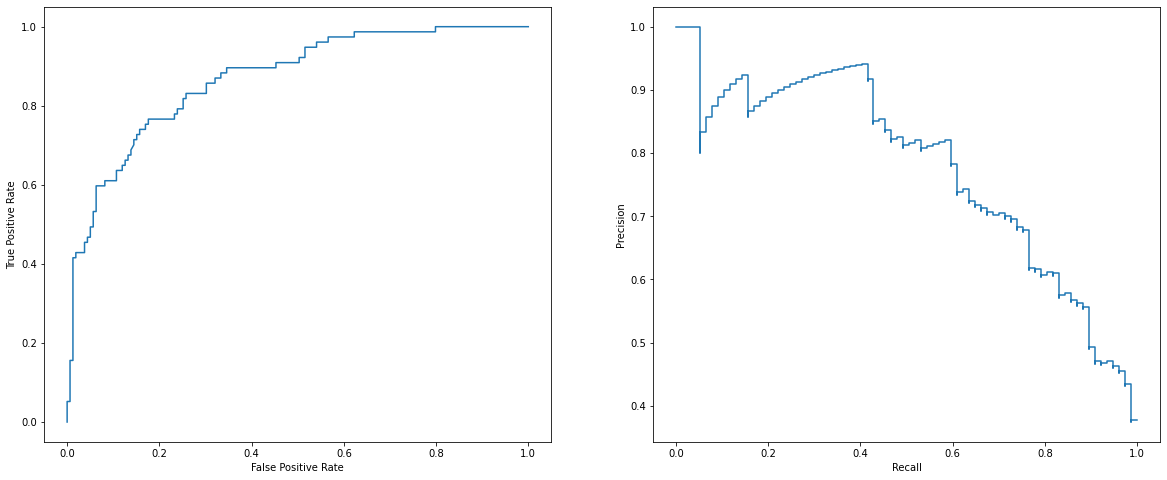

In [856]:
y_prob = clf_xgb.predict_proba(X_test_e)
probabilities = y_prob[:,1]

fpr_wgan_e, tpr_wgan_e, _ = roc_curve(y_test_e, probabilities)
roc_display_wgan_e = RocCurveDisplay(fpr=fpr_wgan_e, tpr=tpr_wgan_e)
roc_auc_wgan_e = auc(fpr_wgan_e, tpr_wgan_e)

prec_wgan_e, recall_wgan_e, _ = precision_recall_curve(y_test_e, probabilities)
pr_display_wgan_e = PrecisionRecallDisplay(precision=prec_wgan_e, recall=recall_wgan_e)
pr_auc_wgan_e = auc(recall_wgan_e, prec_wgan_e)

print('ROC AUC:', roc_auc_wgan_e)
print('Precision-Recall AUC:', pr_auc_wgan_e)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

roc_display_wgan_e.plot(ax=ax1)
pr_display_wgan_e.plot(ax=ax2)
plt.show()

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


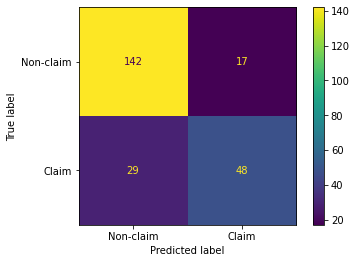

In [857]:
plot_confusion_matrix(clf_xgb, X_test_e, y_test_e, values_format='d', 
                      display_labels=['Non-claim', 'Claim'])

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:14:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight:  {'SubClass_FUND_MANAGERS': 1, 'SubClass_GLOBAL_FINANCIAL_SERVICES': 3, 'Full_GGTP': 1, 'Territory_FRANCE': 1, 'Limit_100Pct_USD': 1, 'StatsMinorClassCode_DS': 1, 'BrokerUltimateName_LONMAR_GLOBAL_RISKS_LIMITED': 1, 'ModelToActualRto': 1, 'PLR_band_Upper_Middle': 1}
gain:  {'SubClass_FUND_MANAGERS': 268.238983, 'SubClass_GLOBAL_FINANCIAL_SERVICES': 96.20392848666667, 'Full_GGTP': 56.9513893, 'Territory_FRANCE': 14.6944275, 'Limit_100Pct_USD': 4.58088684, 'StatsMinorClassCode_DS': 4.03530884, 'BrokerUltimateName_LONMAR_GLOBAL_RISKS_LIMITED': 0.220184326, 'ModelToActualRto': 4.60000038, 'PLR_band_Upper_Middle': 4.38383865}
cover:  {'SubClass_FUND_MANAGERS': 316.5, 'SubClass_GLOBAL_FINANCIAL_SERVICES': 164.08333333333334, 'Full_GGTP'

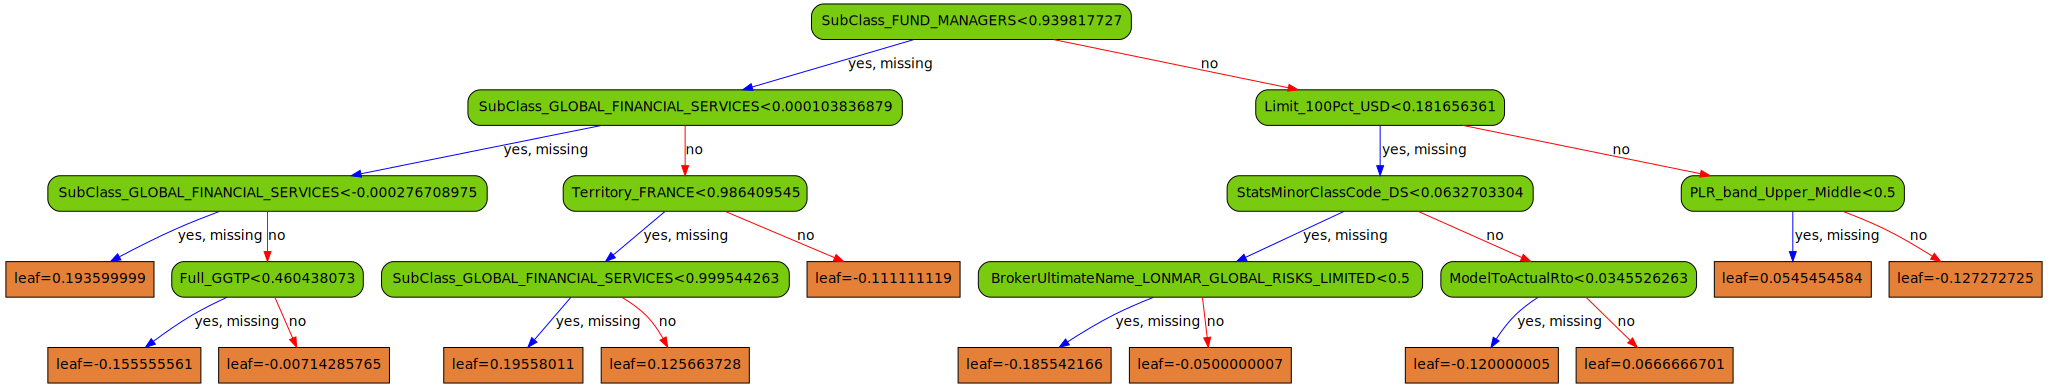

In [858]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                         gamma=0,
                          learning_rate=0.1,
                          max_depth=4,
                          reg_lambda=1,
                          scale_pos_weight=1,
                           seed=42,
                           n_estimators=1)
clf_xgb.fit(X_wgan_e, y_wgan_e)
bst=clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)


# WCGAN

#### Primary Business

In [859]:
X_encoded_w_classes_p = X_train_p.copy()
X_encoded_w_classes_p['Class'] = y_train_p
X_encoded_w_classes_p.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,BrokerUltimateName_RFIB_GROUP_LIMITED,BrokerUltimateName_R_K_HARRISON,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,BrokerUltimateName_WINDSOR_INSURANCE_BROKERS_LTD,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile,Class
117,0.143687,0.592525,1.000000,0.667851,0.147269,0.285714,0.733587,0.135368,0.220804,0.269055,...,0,0,0,0,0,0,0,1,0,0.0
1114,0.016369,0.417329,0.263158,0.523036,0.124463,0.276786,0.581446,0.198327,0.662413,0.163281,...,0,0,0,0,0,1,0,0,0,0.0
329,0.070934,0.483757,1.000000,0.489530,0.141073,0.285714,0.629164,0.161298,0.607212,0.183989,...,0,0,0,0,0,0,0,1,0,0.0
75,0.005456,0.334266,1.000000,0.667851,0.103390,0.419643,0.465869,0.235901,0.220804,0.068619,...,0,0,0,0,0,0,1,0,0,0.0
1132,0.012732,0.358926,1.000000,0.000000,0.066855,0.245536,0.539493,0.375409,0.662413,0.106699,...,0,1,0,0,0,0,1,0,0,0.0


In [860]:
# Finding rows with class '1'
train_p = X_encoded_w_classes_p.loc[ X_encoded_w_classes_p.Class == 1 ].copy()
claim_w_classes_p = train_p.copy()
claim_w_classes_p['Class'] = y_train_p
# claim_w_classes_p.head()
train_p = claim_w_classes_p.copy().reset_index(drop=True)
# train_p.head()

label_cols = ['Class']
data_cols = [ i for i in train_p.columns if i not in label_cols ]
train_no_label_p = train_p.copy()
train_no_label_p.drop('Class', axis=1, inplace=True)
# train_no_label_p = train_p[ data_cols ]
train_no_label_p.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,BrokerUltimateName_PRICE_FORBES_&PARTNERS_LIMITED,BrokerUltimateName_RFIB_GROUP_LIMITED,BrokerUltimateName_R_K_HARRISON,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,BrokerUltimateName_WINDSOR_INSURANCE_BROKERS_LTD,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile
0,0.180063,0.644623,0.368421,0.583595,0.135876,0.285714,0.621752,0.177593,0.220804,0.030962,...,0,0,0,0,0,0,1,0,0,0
1,0.043128,0.558817,1.000000,0.552863,0.133785,0.285714,0.686212,0.166015,0.496809,0.187871,...,0,0,0,0,0,0,1,0,0,0
2,0.023227,0.411010,0.473684,0.471489,0.130188,0.392857,0.571091,0.167652,0.618252,0.167896,...,0,0,0,0,0,1,1,0,0,0
3,0.043128,0.400612,0.684211,0.000000,0.135198,0.285714,0.531897,0.163792,0.552010,0.113608,...,0,0,0,0,0,0,1,0,0,0
4,0.020654,0.486240,1.000000,0.533263,0.146441,0.955357,0.557473,0.161298,0.441608,0.069642,...,0,0,0,0,0,0,0,0,1,0


In [861]:
# rand_dim = len(train_no_label_p.columns) # 32 # needs to be ~data_dim
# base_n_count = 128 # 128

# nb_steps = 10000 + 1 # 50000 # Add one for logging of the last interval
# batch_size = 128 # 64

# k_d = 1  # number of critic network updates per adversarial training step
# k_g = 1  # number of generator network updates per adversarial training step
# critic_pre_train_steps = 100 # 100  # number of steps to pre-train the critic before starting adversarial training
# log_interval = 100 # 100  # interval (in steps) at which to log loss summaries and save plots of image samples to disc
# learning_rate = 1e-4 # 5e-5
# # data_dir = 'cache/'
# # generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None
# # show = True 

In [862]:
# data_cols = train_no_label_p.columns
# data_cols_w_class = train_p.columns
# data_dim = len(data_cols)
# print('data_dim: ', data_dim)
# print('data_cols: ', data_cols)
    
# label_dim = len(label_cols)
# with_class = True
# print('label_dim: ', label_dim)
# print('label_cols: ', label_cols)
    
# K.set_learning_phase(1) # 1 = train

# cache_prefix = 'WCGAN'

# generator_input_tensor = layers.Input(shape=(rand_dim, ))
# labels_tensor = layers.Input(shape=(label_dim,)) # updated for class
# generated_image_tensor = generator_network_w_label(generator_input_tensor, labels_tensor, data_dim, label_dim, base_n_count) # updated for class

# generated_or_real_image_tensor = layers.Input(shape=(data_dim + label_dim,)) # updated for class

# discriminator_output = critic_network(generated_or_real_image_tensor, data_dim + label_dim, base_n_count) # updated for class

# generator_model = models.Model(inputs=[generator_input_tensor, labels_tensor], outputs=[generated_image_tensor], name='generator') # updated for class
# discriminator_model = models.Model(inputs=[generated_or_real_image_tensor],
#                                    outputs=[discriminator_output],
#                                    name='discriminator')

# combined_output = discriminator_model(generator_model([generator_input_tensor, labels_tensor])) # updated for class
# combined_model = models.Model(inputs=[generator_input_tensor, labels_tensor], outputs=[combined_output], name='combined') # updated for class

In [863]:
# _z = tf.placeholder(tf.float32, shape=(batch_size, rand_dim))
    
# _labels = None    

# _x = tf.placeholder(tf.float32, shape=(batch_size, data_dim + label_dim)) 
# _labels = tf.placeholder(tf.float32, shape=(batch_size, label_dim)) # updated for class
# _g_z = generator_model(inputs=[_z, _labels]) # updated for class

# epsilon = tf.placeholder(tf.float32, shape=(batch_size, 1))
    
# x_hat = epsilon * _x + (1.0 - epsilon) * _g_z
# gradients = tf.gradients(discriminator_model(x_hat), [x_hat])
# _gradient_penalty = 10.0 * tf.square(tf.norm(gradients[0], ord=2) - 1.0)

# # calculate discriminator's loss
# _disc_loss_generated = em_loss(tf.ones(batch_size), discriminator_model(_g_z))
# _disc_loss_real = em_loss(tf.ones(batch_size), discriminator_model(_x))
# _disc_loss = _disc_loss_generated - _disc_loss_real + _gradient_penalty

# # update f by taking an SGD step on mini-batch loss LD(f)
# disc_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.5, beta2=0.9).minimize(_disc_loss, var_list=discriminator_model.trainable_weights)

# sess = K.get_session()

# # compile models

# adam = optimizers.Adam(lr=learning_rate, beta_1=0.5, beta_2=0.9)

# discriminator_model.trainable = False
# combined_model.compile(optimizer=adam, loss=[em_loss])

# combined_loss, disc_loss_generated, disc_loss_real, xgb_losses = [], [], [], []

# # print(generator_model.summary())
# # print(discriminator_model.summary())
# # print(combined_model.summary())

In [864]:
# print('pre-training the critic...')
# K.set_learning_phase(1) # 1 = train
# for i in range(critic_pre_train_steps):
#     if i%20==0:
#         print('Step: {} of {} critic pre-training.'.format(i, critic_pre_train_steps))
#         loss = train_discriminator_step_p(step=0,seed=i)

# print('Last batch of critic pre-training disc_loss: {}.'.format(loss))

In [865]:
# for i in range(0, nb_steps):
#     K.set_learning_phase(1) # 1 = train
    
#     # train the discriminator
#     for j in range(k_d):
#         d_l_g, d_l_r = train_discriminator_step_p(step=i+1,seed=i+j)
#     disc_loss_generated.append(d_l_g)
#     disc_loss_real.append(d_l_r)
    
#     # train the generator
#     for j in range(k_g):
#         np.random.seed(i+j)
#         z = np.random.normal(size=(batch_size, rand_dim))
#         if with_class:
#             labels = get_data_batch(train_p, batch_size, seed=i+j)[:,-label_dim:] # updated for class
#             loss = combined_model.train_on_batch([z, labels], [-np.ones(batch_size)]) # updated for class
#         else:
#             loss = combined_model.train_on_batch(z, [-np.ones(batch_size)])
#     combined_loss.append(loss)
    
#     # Determine xgb loss each step, after training generator and discriminator
#     if not i % 10: # 2x faster than testing each step...
#         K.set_learning_phase(0) # 0 = test
#         test_size = np.sum(train_p['Class']==1) # test using all of the actual claim data
#         x = get_data_batch(train_p, test_size, seed=i)
#         z = np.random.normal(size=(test_size, rand_dim))
#         if with_class:
#             labels = x[:,-label_dim:]
#             g_z = generator_model.predict([z, labels])
#         else:
#             g_z = generator_model.predict(z)
#         xgb_loss = CheckAccuracyConditional( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim )
#         xgb_losses = np.append(xgb_losses, xgb_loss)
        
#     if not i % log_interval:
#         print('Step: {} of {}.'.format(i, nb_steps))
#         # K.set_learning_phase(0) # 0 = test
                        
#         # loss summaries   
#         print( 'Losses: G, D Gen, D Real, Xgb: {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(combined_loss[-1], disc_loss_generated[-1], disc_loss_real[-1], xgb_losses[-1]) )
#         print( 'D Real - D Gen: {:.4f}'.format(disc_loss_real[-1]-disc_loss_generated[-1]) )

In [866]:
# fig = plt.figure(figsize=(20,5))
# ax1 = fig.add_subplot(1, 3, 1)
# ax2 = fig.add_subplot(1, 3, 2)
# ax3 = fig.add_subplot(1, 3, 3)

# ax1.plot(combined_loss)
# ax1.set_title('Generator Loss')
# ax1.set_xlabel('Step')
# ax1.set_ylabel('Loss')

# ax2.plot(disc_loss_generated)
# ax2.set_title('Discriminator Loss of Generated Data')
# ax2.set_xlabel('Step')
# ax2.set_ylabel('Loss')

# ax3.plot(disc_loss_real)
# ax3.set_title('Discriminator Loss of Real Data')
# ax3.set_xlabel('Step')
# ax3.set_ylabel('Loss')

# plt.show()

In [867]:
# # Predicting the generated data
# samples = len(X_train_res_p) - len(X_train_p)
# new_z = np.random.normal(size=(samples,rand_dim))
# labels_z = np.ones((samples,1))
# new_g_z = generator_model.predict([new_z, labels_z])

In [868]:
# wcgan_samples_p = pd.DataFrame(new_g_z, columns=data_cols_w_class)
# # Saving the dataset
# wcgan_samples_p.to_csv('dandofi_wcgan_primary.csv',index=False)

In [869]:
# Loading the dataset
wcgan_samples_p = pd.read_csv('../input/project/dandofi_wcgan_primary.csv')
wcgan_samples_p.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,BrokerUltimateName_RFIB_GROUP_LIMITED,BrokerUltimateName_R_K_HARRISON,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,BrokerUltimateName_WINDSOR_INSURANCE_BROKERS_LTD,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile,Class
0,0.776430,0.769426,-0.049438,0.736073,0.180412,0.238519,0.741856,0.198105,0.306285,0.103518,...,0.068164,-0.125854,1.105786,0.024438,0.005660,-0.070616,0.665830,0.277568,-0.065673,1.0
1,0.172338,0.614163,0.647335,0.665720,0.182797,0.180938,0.745566,0.054735,0.398522,0.301966,...,-0.034337,-0.018150,0.016482,-0.063024,-0.025012,-0.050184,0.109953,-0.000808,1.062479,1.0
2,0.130525,0.683883,0.123298,0.718442,0.155672,0.338212,0.727258,0.126282,0.280300,0.097873,...,0.001788,-0.087447,0.034445,0.537625,-0.007631,0.038941,0.004349,0.912442,0.008358,1.0
3,0.059425,0.778809,0.125366,0.879902,0.212440,0.245111,0.836183,0.079841,0.193900,0.246548,...,0.016936,-0.008047,-0.032584,0.935571,0.011975,-0.046896,0.026059,-0.067573,1.107714,1.0
4,0.157499,0.662521,0.105314,0.589776,0.203737,0.256998,0.756144,0.067102,0.248244,0.249755,...,0.038906,-0.038929,0.047515,0.827066,0.016369,0.045112,0.037028,0.082123,0.896900,1.0


In [870]:
wcgan_samples_p.drop('Class', axis=1, inplace=True)
wcgan_samples_p.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,BrokerUltimateName_PRICE_FORBES_&PARTNERS_LIMITED,BrokerUltimateName_RFIB_GROUP_LIMITED,BrokerUltimateName_R_K_HARRISON,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,BrokerUltimateName_WINDSOR_INSURANCE_BROKERS_LTD,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile
0,0.776430,0.769426,-0.049438,0.736073,0.180412,0.238519,0.741856,0.198105,0.306285,0.103518,...,-0.031106,0.068164,-0.125854,1.105786,0.024438,0.005660,-0.070616,0.665830,0.277568,-0.065673
1,0.172338,0.614163,0.647335,0.665720,0.182797,0.180938,0.745566,0.054735,0.398522,0.301966,...,0.015119,-0.034337,-0.018150,0.016482,-0.063024,-0.025012,-0.050184,0.109953,-0.000808,1.062479
2,0.130525,0.683883,0.123298,0.718442,0.155672,0.338212,0.727258,0.126282,0.280300,0.097873,...,-0.030875,0.001788,-0.087447,0.034445,0.537625,-0.007631,0.038941,0.004349,0.912442,0.008358
3,0.059425,0.778809,0.125366,0.879902,0.212440,0.245111,0.836183,0.079841,0.193900,0.246548,...,0.018166,0.016936,-0.008047,-0.032584,0.935571,0.011975,-0.046896,0.026059,-0.067573,1.107714
4,0.157499,0.662521,0.105314,0.589776,0.203737,0.256998,0.756144,0.067102,0.248244,0.249755,...,-0.048278,0.038906,-0.038929,0.047515,0.827066,0.016369,0.045112,0.037028,0.082123,0.896900


In [871]:
X_wcgan_p = X_train_p.append(wcgan_samples_p, ignore_index = True)
X_wcgan_p.describe()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,BrokerUltimateName_PRICE_FORBES_&PARTNERS_LIMITED,BrokerUltimateName_RFIB_GROUP_LIMITED,BrokerUltimateName_R_K_HARRISON,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,BrokerUltimateName_WINDSOR_INSURANCE_BROKERS_LTD,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile
count,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,...,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000
mean,0.105710,0.498691,0.519102,0.420802,0.145310,0.290811,0.642838,0.175614,0.415296,0.200514,...,0.005803,0.014020,0.036264,0.031009,0.122568,0.005228,0.270098,0.195940,0.272741,0.272021
std,0.106248,0.118676,0.293992,0.230461,0.054595,0.070593,0.100319,0.089222,0.194698,0.121026,...,0.082310,0.125974,0.178254,0.167921,0.299516,0.066255,0.417668,0.383842,0.419945,0.421025
min,-0.151820,0.000000,-0.097246,-0.463128,-0.009468,0.000000,0.000000,-0.015193,-0.143824,-0.077696,...,-0.280515,-0.252838,-0.361943,-0.411148,-0.278615,-0.211490,-0.552951,-0.230798,-0.595601,-0.211529
25%,0.034558,0.424869,0.298211,0.331592,0.116758,0.263393,0.582110,0.127947,0.303411,0.124757,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.079895,0.495594,0.473684,0.495145,0.140198,0.285714,0.639672,0.161995,0.441608,0.183989,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.151740,0.564875,0.713341,0.560975,0.169045,0.297518,0.698757,0.200710,0.552011,0.250360,...,0.000000,0.000000,0.000000,0.000000,0.055059,0.000000,0.608900,0.102208,0.617898,0.658378
max,1.000000,1.000000,1.479327,1.192743,1.000000,1.122312,1.000000,1.000000,1.014939,1.174090,...,1.000000,1.943334,1.318775,1.257253,1.450597,1.000000,1.272766,1.816186,1.657141,1.453687


In [872]:
X_train_p.describe()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,ModelToActualRto,...,BrokerUltimateName_PRICE_FORBES_&PARTNERS_LIMITED,BrokerUltimateName_RFIB_GROUP_LIMITED,BrokerUltimateName_R_K_HARRISON,BrokerUltimateName_THB_GROUP,BrokerUltimateName_WILLIS,BrokerUltimateName_WINDSOR_INSURANCE_BROKERS_LTD,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile
count,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,...,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.00000,1158.000000,1158.000000
mean,0.082848,0.462421,0.592188,0.416114,0.141866,0.286037,0.610659,0.180815,0.458424,0.194989,...,0.007772,0.009499,0.042314,0.037133,0.105354,0.003454,0.246978,0.23057,0.246978,0.275475
std,0.099916,0.115641,0.310475,0.240415,0.052049,0.054713,0.095271,0.094588,0.189464,0.112795,...,0.087854,0.097041,0.201392,0.189169,0.307142,0.058696,0.431440,0.42138,0.431440,0.446946
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.020007,0.386800,0.336842,0.427066,0.120527,0.285714,0.549018,0.137357,0.441608,0.124368,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,0.060989,0.457086,0.473684,0.499757,0.137486,0.285714,0.609866,0.162395,0.496810,0.178387,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,0.107310,0.529260,1.000000,0.556543,0.157269,0.285714,0.662761,0.192947,0.563051,0.239935,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [873]:
ones = np.ones((len(wcgan_samples_p),))
one = pd.Series(ones)
y_wcgan_p = y_train_p.append(one, ignore_index=True)
# y_wcgan_p

#### Excess Business

In [874]:
X_encoded_w_classes_e = X_train_e.copy()
X_encoded_w_classes_e['Class'] = y_train_e
X_encoded_w_classes_e.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,...,BrokerUltimateName_JLT,BrokerUltimateName_LOCKTON,BrokerUltimateName_LONMAR_GLOBAL_RISKS_LIMITED,BrokerUltimateName_MARSH,BrokerUltimateName_R_K_HARRISON,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile,Class
1173,0.018223,0.411304,0.117671,0.011355,0.000000,0.102076,0.202335,0.004201,0.222524,0.714284,...,0,0,0,0,0,0,1,0,0,0.0
1021,0.015502,0.324901,0.241535,0.013098,0.000306,0.108668,0.252918,0.001830,0.208333,0.000000,...,0,0,0,0,1,0,1,0,0,0.0
907,0.044363,0.637673,0.035095,0.046947,0.027240,0.132911,0.408560,0.051429,0.166666,0.285714,...,0,1,0,0,0,1,0,0,0,0.0
1147,0.028986,0.425712,0.117671,0.005765,0.000681,0.189095,0.214008,0.005968,0.128996,0.535713,...,1,0,0,0,0,0,0,0,1,0.0
417,0.378246,0.686888,0.018868,0.145264,0.000000,0.174166,0.214008,0.163374,0.129454,0.100000,...,0,0,0,0,0,0,0,0,1,1.0


In [875]:
# Finding rows with class '1'
train_e = X_encoded_w_classes_e.loc[ X_encoded_w_classes_e.Class == 1 ].copy()
claim_w_classes_e = train_e.copy()
claim_w_classes_e['Class'] = y_train_e
# claim_w_classes_p.head()
train_e = claim_w_classes_e.copy().reset_index(drop=True)
# train_e.head()

label_cols = ['Class']
data_cols = [ i for i in train_e.columns if i not in label_cols ]
train_no_label_e = train_e.copy()
train_no_label_e.drop('Class', axis=1, inplace=True)
# train_no_label_e = train_e[ data_cols ]
train_no_label_e.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,...,BrokerUltimateName_HOWDEN,BrokerUltimateName_JLT,BrokerUltimateName_LOCKTON,BrokerUltimateName_LONMAR_GLOBAL_RISKS_LIMITED,BrokerUltimateName_MARSH,BrokerUltimateName_R_K_HARRISON,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile
0,0.378246,0.686888,0.018868,0.145264,0.0,0.174166,0.214008,0.163374,0.129454,0.100000,...,0,0,0,0,0,0,0,0,0,1
1,0.075119,0.764804,0.241535,0.058713,0.0,0.127382,0.233463,0.158930,0.191394,0.342857,...,0,0,0,0,0,0,1,0,0,0
2,0.050514,0.448737,0.066668,0.005765,0.0,0.133804,0.214008,0.007818,0.193402,0.785714,...,1,0,0,0,0,0,1,0,0,0
3,0.028986,0.516941,0.043352,0.352865,0.0,0.124617,0.214008,0.011594,0.192609,0.288677,...,0,0,0,0,1,0,1,0,0,0
4,0.075119,0.589562,0.043352,0.029298,0.0,0.121215,0.194553,0.008149,0.185013,0.285714,...,0,0,0,0,0,0,1,0,0,0


In [876]:
# rand_dim = len(train_no_label_e.columns) # 32 # needs to be ~data_dim
# base_n_count = 128 # 128

# nb_steps = 10000 + 1 # 50000 # Add one for logging of the last interval
# batch_size = 128 # 64

# k_d = 1  # number of critic network updates per adversarial training step
# k_g = 1  # number of generator network updates per adversarial training step
# critic_pre_train_steps = 100 # 100  # number of steps to pre-train the critic before starting adversarial training
# log_interval = 100 # 100  # interval (in steps) at which to log loss summaries and save plots of image samples to disc
# learning_rate = 1e-4 # 5e-5
# # data_dir = 'cache/'
# # generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None
# # show = True 

In [877]:
# data_cols = train_no_label_e.columns
# data_cols_w_class = train_e.columns
# data_dim = len(data_cols)
# print('data_dim: ', data_dim)
# print('data_cols: ', data_cols)
    
# label_dim = len(label_cols)
# with_class = True
# print('label_dim: ', label_dim)
# print('label_cols: ', label_cols)
    
# K.set_learning_phase(1) # 1 = train

# cache_prefix = 'WCGAN'

# generator_input_tensor = layers.Input(shape=(rand_dim, ))
# labels_tensor = layers.Input(shape=(label_dim,)) # updated for class
# generated_image_tensor = generator_network_w_label(generator_input_tensor, labels_tensor, data_dim, label_dim, base_n_count) # updated for class

# generated_or_real_image_tensor = layers.Input(shape=(data_dim + label_dim,)) # updated for class

# discriminator_output = critic_network(generated_or_real_image_tensor, data_dim + label_dim, base_n_count) # updated for class

# generator_model = models.Model(inputs=[generator_input_tensor, labels_tensor], outputs=[generated_image_tensor], name='generator') # updated for class
# discriminator_model = models.Model(inputs=[generated_or_real_image_tensor],
#                                    outputs=[discriminator_output],
#                                    name='discriminator')

# combined_output = discriminator_model(generator_model([generator_input_tensor, labels_tensor])) # updated for class
# combined_model = models.Model(inputs=[generator_input_tensor, labels_tensor], outputs=[combined_output], name='combined') # updated for class

In [878]:
# _z = tf.placeholder(tf.float32, shape=(batch_size, rand_dim))
    
# _labels = None    

# _x = tf.placeholder(tf.float32, shape=(batch_size, data_dim + label_dim)) 
# _labels = tf.placeholder(tf.float32, shape=(batch_size, label_dim)) # updated for class
# _g_z = generator_model(inputs=[_z, _labels]) # updated for class

# epsilon = tf.placeholder(tf.float32, shape=(batch_size, 1))
    
# x_hat = epsilon * _x + (1.0 - epsilon) * _g_z
# gradients = tf.gradients(discriminator_model(x_hat), [x_hat])
# _gradient_penalty = 10.0 * tf.square(tf.norm(gradients[0], ord=2) - 1.0)

# # calculate discriminator's loss
# _disc_loss_generated = em_loss(tf.ones(batch_size), discriminator_model(_g_z))
# _disc_loss_real = em_loss(tf.ones(batch_size), discriminator_model(_x))
# _disc_loss = _disc_loss_generated - _disc_loss_real + _gradient_penalty

# # update f by taking an SGD step on mini-batch loss LD(f)
# disc_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.5, beta2=0.9).minimize(_disc_loss, var_list=discriminator_model.trainable_weights)

# sess = K.get_session()

# # compile models

# adam = optimizers.Adam(lr=learning_rate, beta_1=0.5, beta_2=0.9)

# discriminator_model.trainable = False
# combined_model.compile(optimizer=adam, loss=[em_loss])

# combined_loss, disc_loss_generated, disc_loss_real, xgb_losses = [], [], [], []

# # print(generator_model.summary())
# # print(discriminator_model.summary())
# # print(combined_model.summary())

In [879]:
# print('pre-training the critic...')
# K.set_learning_phase(1) # 1 = train
# for i in range(critic_pre_train_steps):
#     if i%20==0:
#         print('Step: {} of {} critic pre-training.'.format(i, critic_pre_train_steps))
#         loss = train_discriminator_step_e(step=0,seed=i)

# print('Last batch of critic pre-training disc_loss: {}.'.format(loss))

In [880]:
# for i in range(0, nb_steps):
#     K.set_learning_phase(1) # 1 = train
    
#     # train the discriminator
#     for j in range(k_d):
#         d_l_g, d_l_r = train_discriminator_step_e(step=i+1,seed=i+j)
#     disc_loss_generated.append(d_l_g)
#     disc_loss_real.append(d_l_r)
    
#     # train the generator
#     for j in range(k_g):
#         np.random.seed(i+j)
#         z = np.random.normal(size=(batch_size, rand_dim))
#         if with_class:
#             labels = get_data_batch(train_e, batch_size, seed=i+j)[:,-label_dim:] # updated for class
#             loss = combined_model.train_on_batch([z, labels], [-np.ones(batch_size)]) # updated for class
#         else:
#             loss = combined_model.train_on_batch(z, [-np.ones(batch_size)])
#     combined_loss.append(loss)
    
#     # Determine xgb loss each step, after training generator and discriminator
#     if not i % 10: # 2x faster than testing each step...
#         K.set_learning_phase(0) # 0 = test
#         test_size = np.sum(train_e['Class']==1) - 1 # test using all of the actual claim data - 1
#         x = get_data_batch(train_e, test_size, seed=i)
#         z = np.random.normal(size=(test_size, rand_dim))
#         if with_class:
#             labels = x[:,-label_dim:]
#             g_z = generator_model.predict([z, labels])
#         else:
#             g_z = generator_model.predict(z)
#         xgb_loss = CheckAccuracyConditional( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim )
#         xgb_losses = np.append(xgb_losses, xgb_loss)
        
#     if not i % log_interval:
#         print('Step: {} of {}.'.format(i, nb_steps))
#         # K.set_learning_phase(0) # 0 = test
                        
#         # loss summaries   
#         print( 'Losses: G, D Gen, D Real, Xgb: {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(combined_loss[-1], disc_loss_generated[-1], disc_loss_real[-1], xgb_losses[-1]) )
#         print( 'D Real - D Gen: {:.4f}'.format(disc_loss_real[-1]-disc_loss_generated[-1]) )

In [881]:
# fig = plt.figure(figsize=(20,5))
# ax1 = fig.add_subplot(1, 3, 1)
# ax2 = fig.add_subplot(1, 3, 2)
# ax3 = fig.add_subplot(1, 3, 3)

# ax1.plot(combined_loss)
# ax1.set_title('Generator Loss')
# ax1.set_xlabel('Step')
# ax1.set_ylabel('Loss')

# ax2.plot(disc_loss_generated)
# ax2.set_title('Discriminator Loss of Generated Data')
# ax2.set_xlabel('Step')
# ax2.set_ylabel('Loss')

# ax3.plot(disc_loss_real)
# ax3.set_title('Discriminator Loss of Real Data')
# ax3.set_xlabel('Step')
# ax3.set_ylabel('Loss')

# plt.show()

In [882]:
# # Predicting the generated data
# samples = len(X_train_res_e) - len(X_train_e)
# new_z = np.random.normal(size=(samples,rand_dim))
# labels_z = np.ones((samples,1))
# new_g_z = generator_model.predict([new_z, labels_z])

In [883]:
# wcgan_samples_e = pd.DataFrame(new_g_z, columns=data_cols_w_class)
# # Saving the dataset
# wcgan_samples_e.to_csv('dandofi_wcgan_excess.csv',index=False)

In [884]:
# Loading the dataset
wcgan_samples_e = pd.read_csv('../input/project/dandofi_wcgan_excess.csv')
wcgan_samples_e.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,...,BrokerUltimateName_JLT,BrokerUltimateName_LOCKTON,BrokerUltimateName_LONMAR_GLOBAL_RISKS_LIMITED,BrokerUltimateName_MARSH,BrokerUltimateName_R_K_HARRISON,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile,Class
0,0.073199,0.616495,0.057166,0.112967,0.018486,0.326963,0.170135,0.057401,0.067933,0.459758,...,-0.025608,0.029061,-0.043821,-0.084711,0.075909,0.045158,-0.007857,0.059493,1.031382,1.0
1,0.157506,0.564992,0.013109,0.131132,-0.011192,0.208996,0.285288,-0.079467,0.123018,0.573706,...,0.467459,0.015240,0.029154,-0.062366,0.027358,0.227873,0.018379,-0.093425,0.694793,1.0
2,0.044067,0.588796,0.020912,0.042181,0.506066,0.175846,0.175104,0.179935,0.161099,0.368139,...,-0.026408,0.026709,0.025426,0.781249,0.087476,0.122553,0.070247,0.010249,0.752724,1.0
3,0.161932,0.619762,0.022405,0.474031,0.073639,0.121372,0.243435,0.205563,0.231459,0.002299,...,-0.082417,0.016563,0.026617,0.033308,0.047655,-0.128251,1.201685,-0.035973,-0.128375,1.0
4,0.085727,0.489501,0.072465,0.316740,-0.054276,0.140763,0.263544,-0.022699,0.250466,0.310394,...,-0.056827,-0.041736,-0.009873,0.956243,0.021256,-0.030303,1.084874,0.019129,-0.071883,1.0


In [885]:
wcgan_samples_e.drop('Class', axis=1, inplace=True)
wcgan_samples_e.head()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,...,BrokerUltimateName_HOWDEN,BrokerUltimateName_JLT,BrokerUltimateName_LOCKTON,BrokerUltimateName_LONMAR_GLOBAL_RISKS_LIMITED,BrokerUltimateName_MARSH,BrokerUltimateName_R_K_HARRISON,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile
0,0.073199,0.616495,0.057166,0.112967,0.018486,0.326963,0.170135,0.057401,0.067933,0.459758,...,-0.006502,-0.025608,0.029061,-0.043821,-0.084711,0.075909,0.045158,-0.007857,0.059493,1.031382
1,0.157506,0.564992,0.013109,0.131132,-0.011192,0.208996,0.285288,-0.079467,0.123018,0.573706,...,-0.036199,0.467459,0.015240,0.029154,-0.062366,0.027358,0.227873,0.018379,-0.093425,0.694793
2,0.044067,0.588796,0.020912,0.042181,0.506066,0.175846,0.175104,0.179935,0.161099,0.368139,...,-0.023939,-0.026408,0.026709,0.025426,0.781249,0.087476,0.122553,0.070247,0.010249,0.752724
3,0.161932,0.619762,0.022405,0.474031,0.073639,0.121372,0.243435,0.205563,0.231459,0.002299,...,0.077585,-0.082417,0.016563,0.026617,0.033308,0.047655,-0.128251,1.201685,-0.035973,-0.128375
4,0.085727,0.489501,0.072465,0.316740,-0.054276,0.140763,0.263544,-0.022699,0.250466,0.310394,...,0.027831,-0.056827,-0.041736,-0.009873,0.956243,0.021256,-0.030303,1.084874,0.019129,-0.071883


In [886]:
X_wcgan_e = X_train_e.append(wcgan_samples_e, ignore_index = True)
X_wcgan_e.describe()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,...,BrokerUltimateName_HOWDEN,BrokerUltimateName_JLT,BrokerUltimateName_LOCKTON,BrokerUltimateName_LONMAR_GLOBAL_RISKS_LIMITED,BrokerUltimateName_MARSH,BrokerUltimateName_R_K_HARRISON,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile
count,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,...,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000
mean,0.114936,0.559933,0.072271,0.122605,0.024780,0.151999,0.209328,0.070177,0.184236,0.322243,...,0.052089,0.050661,0.036836,0.004935,0.321845,0.058288,0.247581,0.258944,0.221176,0.271430
std,0.103210,0.115367,0.065430,0.145356,0.087662,0.073407,0.050945,0.109026,0.096343,0.280738,...,0.216295,0.218209,0.198764,0.061755,0.449570,0.219331,0.422661,0.429255,0.405115,0.435861
min,-0.168561,0.000000,-0.129357,-0.185763,-0.209717,-0.006456,0.002609,-0.284693,-0.062176,-0.143489,...,-0.195358,-0.195004,-0.145463,-0.130571,-0.271841,-0.180722,-0.223388,-0.203407,-0.232379,-0.296227
25%,0.047747,0.481418,0.030966,0.024775,0.000000,0.117737,0.195611,0.009737,0.139216,0.085714,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.090497,0.558219,0.055739,0.072573,0.000000,0.140700,0.214008,0.030580,0.169617,0.285714,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.152008,0.639577,0.100669,0.172658,0.013620,0.168651,0.214008,0.094107,0.208222,0.573588,...,0.000000,0.000000,0.000000,0.000000,0.957951,0.000000,0.365868,0.628476,0.106107,0.859070
max,1.102889,1.000000,0.673921,1.171921,1.000000,1.000000,1.000000,1.000000,1.000000,1.170530,...,1.000000,1.636036,1.000000,1.000000,1.319774,1.297435,1.187524,1.213926,1.256938,1.144713


In [887]:
X_train_e.describe()

,Limit_100Pct_USD,Full_GGTP,LeaderLinePct,XS_100Pct_USD,Ded_100Pct_USD,PLR,RARC,Full_GrossGrossModelPrice,PricingStrength,BrokerFeePct,...,BrokerUltimateName_HOWDEN,BrokerUltimateName_JLT,BrokerUltimateName_LOCKTON,BrokerUltimateName_LONMAR_GLOBAL_RISKS_LIMITED,BrokerUltimateName_MARSH,BrokerUltimateName_R_K_HARRISON,PLR_band_Lower_Middle,PLR_band_Lower_quantile,PLR_band_Upper_Middle,PLR_band_Upper_Quantile
count,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000,...,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000
mean,0.102701,0.543778,0.079275,0.103731,0.020291,0.151186,0.213656,0.057529,0.185358,0.347040,...,0.060510,0.056263,0.054140,0.004246,0.292994,0.055202,0.249469,0.248408,0.238854,0.263270
std,0.096010,0.119693,0.064176,0.135259,0.081219,0.071757,0.045375,0.099697,0.100351,0.292286,...,0.238555,0.230552,0.226414,0.065060,0.455377,0.228495,0.432936,0.432319,0.426610,0.440641
min,0.001686,0.000000,0.000000,0.000000,0.000000,0.013950,0.097276,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.040581,0.465665,0.035617,0.021690,0.000000,0.121215,0.214008,0.008653,0.143851,0.085714,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.075119,0.535565,0.059542,0.058713,0.000000,0.141268,0.214008,0.020312,0.169073,0.285714,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.124396,0.626045,0.117671,0.132036,0.002674,0.162486,0.214008,0.061430,0.203404,0.642856,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,0.965456,1.000000,0.673921,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [888]:
ones = np.ones((len(wcgan_samples_e),))
one = pd.Series(ones)
y_wcgan_e = y_train_e.append(one, ignore_index=True)
# y_wcgan_e

### XGBoost (WCGAN)

#### Primary Business

In [889]:
# param_grid ={
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.1, 1.0],
#     'reg_lambda': [1.0, 5.0, 10.0],
#     'scale_pos_weight' : [1, 2, 3]
# }

# # AUC since data is imbalance
# # Choose only 90% random subset of the data and for each tree, choose only 50% of the columns to
# # improve the speed and prevent overfitting
# optimal_params = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42, 
#                                                 subsample=0.9, colsample_bytree=0.5),
#                              param_grid=param_grid,
#                               scoring='roc_auc',
#                              verbose=2,
# #                               n_jobs=10,
#                              cv=3)

# optimal_params.fit(X_wcgan_p, y_wcgan_p, verbose=False, early_stopping_rounds=10, 
#             eval_metric='aucpr', eval_set=[(X_test_p, y_test_p)])

In [890]:
# print(optimal_params.best_params_)

In [891]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0,
                          learning_rate=0.1,
                          max_depth=4,
                          reg_lambda=10,
                          scale_pos_weight=2,
                           seed=42,
                           subsample=0.9, 
                            colsample_bytree=0.5)
clf_xgb.fit(X_wcgan_p, y_wcgan_p, verbose=True, early_stopping_rounds=10, 
            eval_metric='aucpr', eval_set=[(X_test_p, y_test_p)])

[0]	validation_0-aucpr:0.38455
[1]	validation_0-aucpr:0.44044
[2]	validation_0-aucpr:0.40322
[3]	validation_0-aucpr:0.44645
[4]	validation_0-aucpr:0.47176
[5]	validation_0-aucpr:0.49215
[6]	validation_0-aucpr:0.49693
[7]	validation_0-aucpr:0.48403
[8]	validation_0-aucpr:0.48087
[9]	validation_0-aucpr:0.47854
[10]	validation_0-aucpr:0.49675
[11]	validation_0-aucpr:0.51740
[12]	validation_0-aucpr:0.51114
[13]	validation_0-aucpr:0.50536
[14]	validation_0-aucpr:0.50899


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15]	validation_0-aucpr:0.50696
[16]	validation_0-aucpr:0.50876
[17]	validation_0-aucpr:0.52091
[18]	validation_0-aucpr:0.52554
[19]	validation_0-aucpr:0.51669
[20]	validation_0-aucpr:0.51762
[21]	validation_0-aucpr:0.51054
[22]	validation_0-aucpr:0.51646
[23]	validation_0-aucpr:0.52200
[24]	validation_0-aucpr:0.52494
[25]	validation_0-aucpr:0.52029
[26]	validation_0-aucpr:0.51301
[27]	validation_0-aucpr:0.51741
[28]	validation_0-aucpr:0.52413


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=10, scale_pos_weight=2, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [892]:
print('Best score:', clf_xgb.best_score)
print('Best iteration:', clf_xgb.best_iteration)

Best score: 0.52554
Best iteration: 18


In [893]:
# make predictions for test data
y_pred = clf_xgb.predict(X_test_p)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test_p, predictions)
report = classification_report(y_test_p, predictions)
roc_auc = roc_auc_score(y_test_p, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC:", roc_auc)
print(report)

Accuracy: 91.03%
ROC AUC: 0.6758720930232558
              precision    recall  f1-score   support

         0.0       0.93      0.98      0.95       258
         1.0       0.67      0.38      0.48        32

    accuracy                           0.91       290
   macro avg       0.80      0.68      0.72       290
weighted avg       0.90      0.91      0.90       290



/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ROC AUC: 0.7707122093023255
Precision-Recall AUC: 0.5260237649722922


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


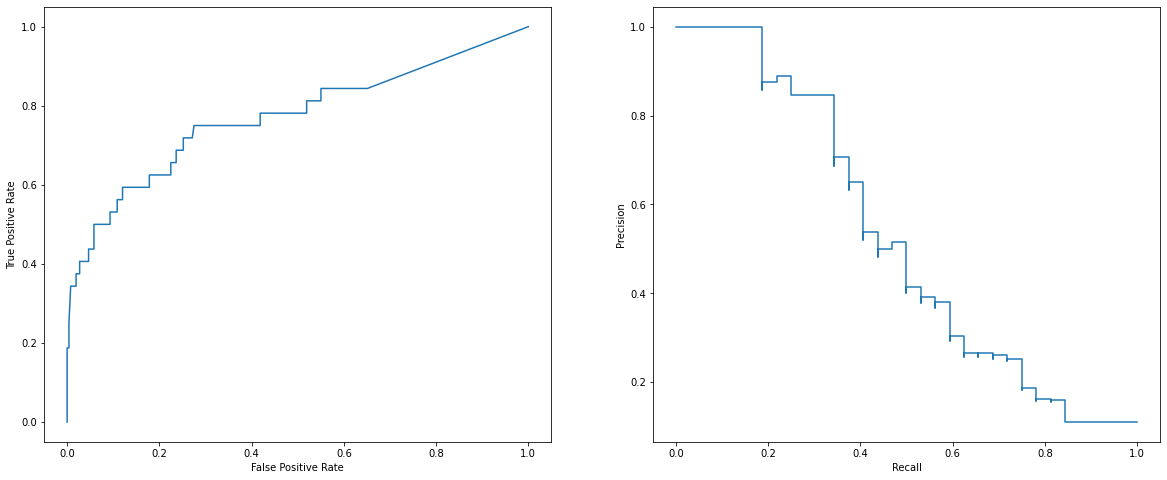

In [894]:
y_prob = clf_xgb.predict_proba(X_test_p)
probabilities = y_prob[:,1]

fpr_wcgan_p, tpr_wcgan_p, _ = roc_curve(y_test_p, probabilities)
roc_display_wcgan_p = RocCurveDisplay(fpr=fpr_wcgan_p, tpr=tpr_wcgan_p)
roc_auc_wcgan_p = auc(fpr_wcgan_p, tpr_wcgan_p)

prec_wcgan_p, recall_wcgan_p, _ = precision_recall_curve(y_test_p, probabilities)
pr_display_wcgan_p = PrecisionRecallDisplay(precision=prec_wcgan_p, recall=recall_wcgan_p)
pr_auc_wcgan_p = auc(recall_wcgan_p, prec_wcgan_p)

print('ROC AUC:', roc_auc_wcgan_p)
print('Precision-Recall AUC:', pr_auc_wcgan_p)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

roc_display_wcgan_p.plot(ax=ax1)
pr_display_wcgan_p.plot(ax=ax2)
plt.show()

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


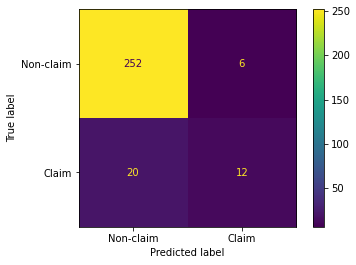

In [895]:
plot_confusion_matrix(clf_xgb, X_test_p, y_test_p, values_format='d', 
                      display_labels=['Non-claim', 'Claim'])

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:14:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight:  {'Territory_IRELAND_(EIRE)': 3, 'Full_GGTP': 2, 'SubClass_FUND_MANAGERS': 1}
gain:  {'Territory_IRELAND_(EIRE)': 614.1257936666667, 'Full_GGTP': 57.96183775, 'SubClass_FUND_MANAGERS': 13.4254322}
cover:  {'Territory_IRELAND_(EIRE)': 516.0, 'Full_GGTP': 274.375, 'SubClass_FUND_MANAGERS': 66.75}
total_gain:  {'Territory_IRELAND_(EIRE)': 1842.377381, 'Full_GGTP': 115.9236755, 'SubClass_FUND_MANAGERS': 13.4254322}
total_cover:  {'Territory_IRELAND_(EIRE)': 1548.0, 'Full_GGTP': 548.75, 'SubClass_FUND_MANAGERS': 66.75}


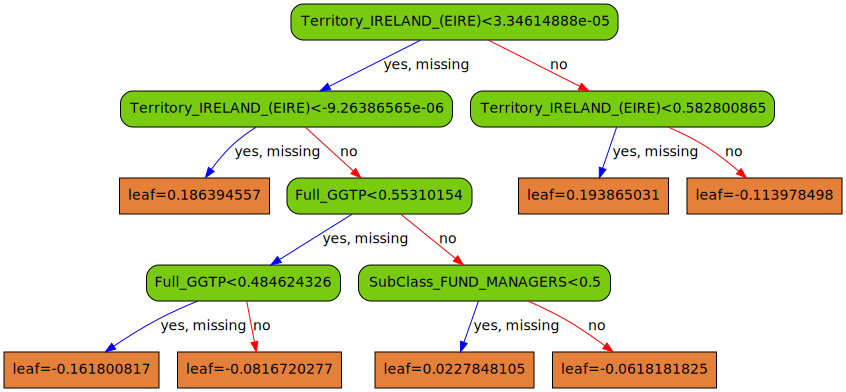

In [896]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                         gamma=0,
                          learning_rate=0.1,
                          max_depth=4,
                          reg_lambda=10,
                          scale_pos_weight=2,
                           seed=42,
                           n_estimators=1)
clf_xgb.fit(X_wcgan_p, y_wcgan_p)
bst=clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)


#### Excess Business

In [897]:
# param_grid ={
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.1, 1.0],
#     'reg_lambda': [1.0, 5.0, 10.0],
#     'scale_pos_weight' : [1, 2, 3]
# }

# # AUC since data is imbalance
# # Choose only 90% random subset of the data and for each tree, choose only 50% of the columns to
# # improve the speed and prevent overfitting
# optimal_params = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42, 
#                                                 subsample=0.9, colsample_bytree=0.5),
#                              param_grid=param_grid,
#                               scoring='roc_auc',
#                              verbose=2,
# #                               n_jobs=10,
#                              cv=3)

# optimal_params.fit(X_wcgan_e, y_wcgan_e, verbose=False, early_stopping_rounds=10, 
#             eval_metric='aucpr', eval_set=[(X_test_e, y_test_e)])

In [898]:
# print(optimal_params.best_params_)

In [899]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                          gamma=0,
                          learning_rate=0.1,
                          max_depth=5,
                          reg_lambda=1,
                          scale_pos_weight=1,
                           seed=42,
                           subsample=0.9, 
                            colsample_bytree=0.5)
clf_xgb.fit(X_wcgan_e, y_wcgan_e, verbose=True, early_stopping_rounds=10, 
            eval_metric='aucpr', eval_set=[(X_test_e, y_test_e)])

[0]	validation_0-aucpr:0.54819
[1]	validation_0-aucpr:0.61743
[2]	validation_0-aucpr:0.64788
[3]	validation_0-aucpr:0.68982
[4]	validation_0-aucpr:0.68737
[5]	validation_0-aucpr:0.67992


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[6]	validation_0-aucpr:0.68873
[7]	validation_0-aucpr:0.71076
[8]	validation_0-aucpr:0.71749
[9]	validation_0-aucpr:0.72983
[10]	validation_0-aucpr:0.72782
[11]	validation_0-aucpr:0.72924
[12]	validation_0-aucpr:0.74457
[13]	validation_0-aucpr:0.74042
[14]	validation_0-aucpr:0.71948
[15]	validation_0-aucpr:0.71928
[16]	validation_0-aucpr:0.71884
[17]	validation_0-aucpr:0.72050
[18]	validation_0-aucpr:0.72064
[19]	validation_0-aucpr:0.72194
[20]	validation_0-aucpr:0.72301
[21]	validation_0-aucpr:0.72118
[22]	validation_0-aucpr:0.72340


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [900]:
print('Best score:', clf_xgb.best_score)
print('Best iteration:', clf_xgb.best_iteration)

Best score: 0.744575
Best iteration: 12


In [901]:
# make predictions for test data
y_pred = clf_xgb.predict(X_test_e)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test_e, predictions)
report = classification_report(y_test_e, predictions)
roc_auc = roc_auc_score(y_test_e, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC:", roc_auc)
print(report)

Accuracy: 79.66%
ROC AUC: 0.7284979171771624
              precision    recall  f1-score   support

         0.0       0.80      0.92      0.86       159
         1.0       0.77      0.53      0.63        77

    accuracy                           0.80       236
   macro avg       0.79      0.73      0.75       236
weighted avg       0.79      0.80      0.78       236



/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


ROC AUC: 0.8483214898309237
Precision-Recall AUC: 0.7445183136442589


/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


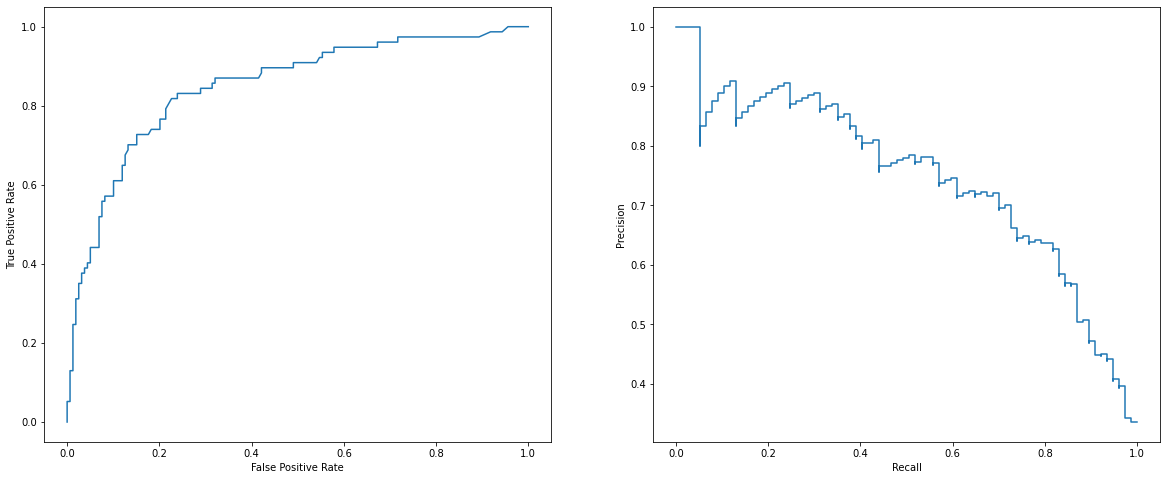

In [902]:
y_prob = clf_xgb.predict_proba(X_test_e)
probabilities = y_prob[:,1]

fpr_wcgan_e, tpr_wcgan_e, _ = roc_curve(y_test_e, probabilities)
roc_display_wcgan_e = RocCurveDisplay(fpr=fpr_wcgan_e, tpr=tpr_wcgan_e)
roc_auc_wcgan_e = auc(fpr_wcgan_e, tpr_wcgan_e)

prec_wcgan_e, recall_wcgan_e, _ = precision_recall_curve(y_test_e, probabilities)
pr_display_wcgan_e = PrecisionRecallDisplay(precision=prec_wcgan_e, recall=recall_wcgan_e)
pr_auc_wcgan_e = auc(recall_wcgan_e, prec_wcgan_e)

print('ROC AUC:', roc_auc_wcgan_e)
print('Precision-Recall AUC:', pr_auc_wcgan_e)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

roc_display_wcgan_e.plot(ax=ax1)
pr_display_wcgan_e.plot(ax=ax2)
plt.show()

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


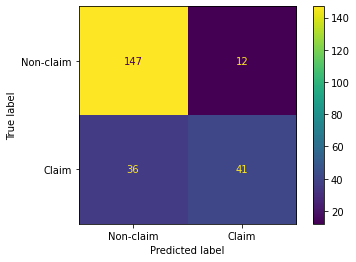

In [903]:
plot_confusion_matrix(clf_xgb, X_test_e, y_test_e, values_format='d', 
                      display_labels=['Non-claim', 'Claim'])

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:14:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight:  {'SubClass_GLOBAL_FINANCIAL_SERVICES': 3, 'SubClass_FUND_MANAGERS': 1, 'Full_GGTP': 2, 'BrokerFeePct': 2, 'Limit_100Pct_USD': 1, 'StatsMinorClassCode_DS': 1, 'PLR_band_Upper_Middle': 1, 'Territory_FRANCE': 1, 'PricingStrength': 1}
gain:  {'SubClass_GLOBAL_FINANCIAL_SERVICES': 159.89484680666666, 'SubClass_FUND_MANAGERS': 80.9521942, 'Full_GGTP': 30.388784400000002, 'BrokerFeePct': 18.35979271, 'Limit_100Pct_USD': 4.69367981, 'StatsMinorClassCode_DS': 2.23460388, 'PLR_band_Upper_Middle': 4.38383865, 'Territory_FRANCE': 10.8441925, 'PricingStrength': 3.77358627}
cover:  {'SubClass_GLOBAL_FINANCIAL_SERVICES': 210.41666666666666, 'SubClass_FUND_MANAGERS': 213.25, 'Full_GGTP': 88.25, 'BrokerFeePct': 68.75, 'Limit_100Pct_USD': 69.5, 'S

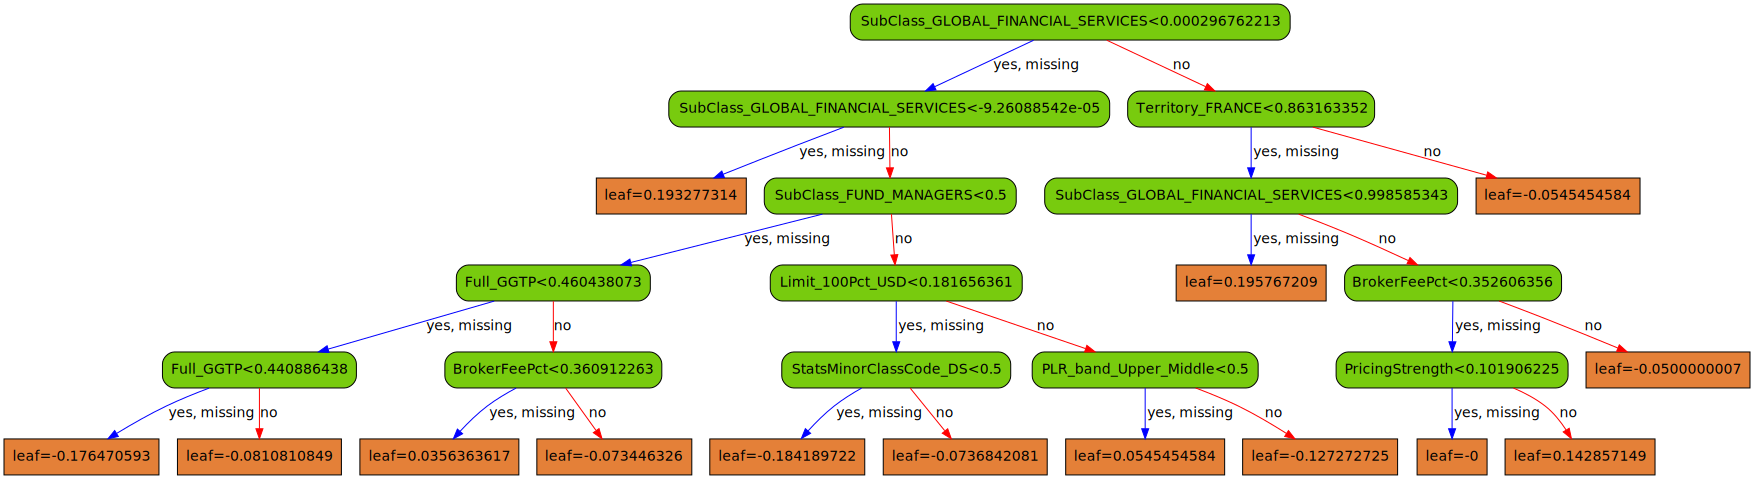

In [904]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                         gamma=0,
                          learning_rate=0.1,
                          max_depth=5,
                          reg_lambda=1,
                          scale_pos_weight=1,
                           seed=42,
                           n_estimators=1)
clf_xgb.fit(X_wcgan_e, y_wcgan_e)
bst=clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
               condition_node_params=node_params,
               leaf_node_params=leaf_params)


## Comparison Plots

In [905]:
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
fpr, tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

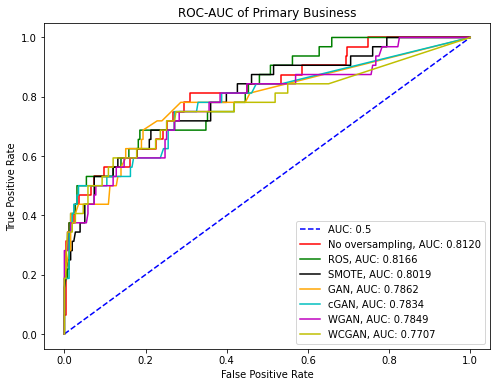

In [906]:
plt.figure(figsize=(8,6))

plt.plot(fpr, tpr, color='b', linestyle='--', label='AUC: 0.5')
plt.plot(fpr_p, tpr_p, color='r', label='No oversampling, AUC: %.4f' % roc_auc_p)
plt.plot(fpr_ros_p, tpr_ros_p, color='g', label='ROS, AUC: %.4f' % roc_auc_ros_p)
plt.plot(fpr_sm_p, tpr_sm_p, color='k', label='SMOTE, AUC: %.4f' % roc_auc_sm_p)
plt.plot(fpr_gan_p, tpr_gan_p, color='orange', label='GAN, AUC: %.4f' % roc_auc_gan_p)
plt.plot(fpr_cgan_p, tpr_cgan_p, color='c', label='cGAN, AUC: %.4f' % roc_auc_cgan_p)
plt.plot(fpr_wgan_p, tpr_wgan_p, color='m', label='WGAN, AUC: %.4f' % roc_auc_wgan_p)
plt.plot(fpr_wcgan_p, tpr_wcgan_p, color='y', label='WCGAN, AUC: %.4f' % roc_auc_wcgan_p)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC of Primary Business')
plt.legend(loc='lower right')

plt.show()

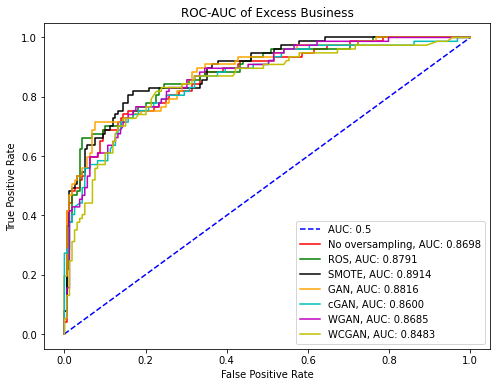

In [907]:
plt.figure(figsize=(8,6))

plt.plot(fpr, tpr, color='b', linestyle='--', label='AUC: 0.5')
plt.plot(fpr_e, tpr_e, color='r', label='No oversampling, AUC: %.4f' % roc_auc_e)
plt.plot(fpr_ros_e, tpr_ros_e, color='g', label='ROS, AUC: %.4f' % roc_auc_ros_e)
plt.plot(fpr_sm_e, tpr_sm_e, color='k', label='SMOTE, AUC: %.4f' % roc_auc_sm_e)
plt.plot(fpr_gan_e, tpr_gan_e, color='orange', label='GAN, AUC: %.4f' % roc_auc_gan_e)
plt.plot(fpr_cgan_e, tpr_cgan_e, color='c', label='cGAN, AUC: %.4f' % roc_auc_cgan_e)
plt.plot(fpr_wgan_e, tpr_wgan_e, color='m', label='WGAN, AUC: %.4f' % roc_auc_wgan_e)
plt.plot(fpr_wcgan_e, tpr_wcgan_e, color='y', label='WCGAN, AUC: %.4f' % roc_auc_wcgan_e)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC of Excess Business')
plt.legend(loc='lower right')

plt.show()

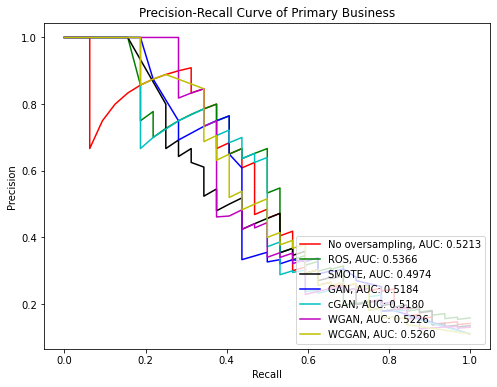

In [908]:
plt.figure(figsize=(8,6))

plt.plot(recall_p, prec_p, color='r', label='No oversampling, AUC: %.4f' % pr_auc_p)
plt.plot(recall_ros_p, prec_ros_p, color='g', label='ROS, AUC: %.4f' % pr_auc_ros_p)
plt.plot(recall_sm_p, prec_sm_p, color='k', label='SMOTE, AUC: %.4f' % pr_auc_sm_p)
plt.plot(recall_gan_p, prec_gan_p, color='b', label='GAN, AUC: %.4f' % pr_auc_gan_p)
plt.plot(recall_cgan_p, prec_cgan_p, color='c', label='cGAN, AUC: %.4f' % pr_auc_cgan_p)
plt.plot(recall_wgan_p, prec_wgan_p, color='m', label='WGAN, AUC: %.4f' % pr_auc_wgan_p)
plt.plot(recall_wcgan_p, prec_wcgan_p, color='y', label='WCGAN, AUC: %.4f' % pr_auc_wcgan_p)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve of Primary Business')
plt.legend(loc='lower right')

plt.show()

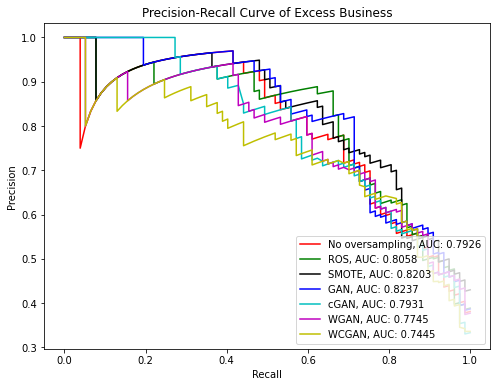

In [909]:
plt.figure(figsize=(8,6))

plt.plot(recall_e, prec_e, color='r', label='No oversampling, AUC: %.4f' % pr_auc_e)
plt.plot(recall_ros_e, prec_ros_e, color='g', label='ROS, AUC: %.4f' % pr_auc_ros_e)
plt.plot(recall_sm_e, prec_sm_e, color='k', label='SMOTE, AUC: %.4f' % pr_auc_sm_e)
plt.plot(recall_gan_e, prec_gan_e, color='b', label='GAN, AUC: %.4f' % pr_auc_gan_e)
plt.plot(recall_cgan_e, prec_cgan_e, color='c', label='cGAN, AUC: %.4f' % pr_auc_cgan_e)
plt.plot(recall_wgan_e, prec_wgan_e, color='m', label='WGAN, AUC: %.4f' % pr_auc_wgan_e)
plt.plot(recall_wcgan_e, prec_wcgan_e, color='y', label='WCGAN, AUC: %.4f' % pr_auc_wcgan_e)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve of Excess Business')
plt.legend(loc='lower right')

plt.show()